# DSRM Report: The PAMAP2 Physical Activity Monitoring dataset

### RegNo: 22116789

- <a href='#the_introduction'>1 introduction</a>
    - <a href='#the_background'>1.1 Background</a>
    - <a href='#the_datadesceiption'>1.2 Data Description</a>
    - <a href='#the_problemstatement'>1.3 Problem Statement</a>
- <a href='#the_dataexploration'>2 Data Exploration</a>
    - <a href='#the_loaddata'>2.1 Load Data</a>
    - <a href='#the_renamecolumns'>2.2 Rename Columns</a>
    - <a href='#the_mappingactivities'>2.3 Mapping Activities</a>
- <a href='#the_datacleaning'>3 Data Cleaning</a>
    - <a href='#the_missingvalues'>3.1 Missing Values</a>
    - <a href='#the_droppingcolumns'>3.2 Dropping Columns</a>
- <a href='#the_datavisualisation'>4 Data Visualisation</a>
    - <a href='#the_41'>4.1 For the same person can we distinguish the difference between the activities?</a>
    - <a href='#the_42'>4.2 Do people have similar measurements while doing the same activity?</a>
    - <a href='#the_43'>4.3 Are the three axes of the sensor following the same behaviour?</a>
    - <a href='#the_44'>4.4 Distribution of activities across all subjects</a>
    - <a href='#the_45'>4.5 Correlation and Multicollinearity </a>
    - <a href='#the_46'>4.6 Summary</a>
- <a href='#the_datapreprocessing'>5 Data Pre-proccessing</a>
    - <a href='#the_51'>5.1 Aggregated windows</a>
    - <a href='#the_52'>5.2 Creating Target</a>
    - <a href='#the_53'>5.3 splitting Data</a>
- <a href='#the_hypothesistesting'>6 Hypothesis Testing</a>
    - <a href='#the_61'>6.1 Splitting Hypothesis Data </a>
    - <a href='#the_62'>6.2 Hyothesis Conclusion</a>
- <a href='#the_modeling'>7 Modeling</a>
    - <a href='#the_71'>7.1 Implementing the algorithm</a>
    - <a href='#the_72'>7.2 Feature importance</a>
    - <a href='#the_73'>7.3 Validation</a>
    - <a href='#the_74'>7.4 Testing</a>
- <a href='#the_conclusion'>8 Conclusion</a>
    - <a href='#the_81'>8.1 Technical Improvements</a>
    - <a href='#the_82'>8.2 Actionable Plan</a>
    


<a id='the_introduction'></a> 

## 1 Introdution   

<a id='the_background'></a> 

### 1.1 Background 

The ["UK Chief Medical Officers' Physical Activity Guidelines" ](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/832868/uk-chief-medical-officers-physical-activity-guidelines.pdf) provides recommended physical activity guidelines including duration and intensity for different ages to achieve optimal health. Types of physical activities and their intensities are divided into 5 categories: Sedentary, Light, Moderate, Vigorous, and Very vigorous. 

<a id='the_datadesceiption'></a> 

### 1.2 Data Description

The dataset contains data of 18 different physical activities (such as walking, cycling, playing soccer etc) performed by 9 subjects wearing 3 inertial measurement units (IMU) and a heart rate monitor. This data is stored in individual text files per subject. Each row in each file represents one reading and contains 54 attributes (including timestamp, activity ID, heart rate and IMU sensory data).. Synchronized and labeled raw data from all the sensors (3 IMUs and the HR-monitor) is merged
into 1 data file per subject per session (protocol or optional), available as text-files (.dat).

Each of the data-files contains 54 columns per row, the columns contain the following data:
   - 1 timestamp (s)
   - 2 activityID 
   - 3 heart rate (bpm)
   - 4-20 IMU hand
   - 21-37 IMU chest
   - 38-54 IMU ankle

The IMU sensory data contains the following columns:
   - 1 temperature (°C)
   - 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
   - 5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
   - 8-10 3D-gyroscope data (rad/s)
   - 11-13 3D-magnetometer data (μT)
   - 14-17 orientation


<a id='the_problemstatement'></a> 

### 1.3 Problem Statement 

To develop a software which can determine the amount and type of physical activity carried out by an individual we need to analyse the dataset to answer these questions:
- For the same person can we distinguish the difference between the activities?
- Do people have similar measurements while doing the same activity ?
- In case different people have different behaviour for the same activity, do we have enough data to build a model for every person based on their history?
- Are there more insightful features that needs to be created?

The results can help making a software that distiguish the intensitiy and duration of the activities an individual is doing, send daily/weekly remminders to do more of a specific category, send motivation and encouragement in case of exceeding the goals. 

<a id='the_dataexploration'></a> 

## 2 Data Exploration   

<a id='the_loaddata'></a> 

### 2.1 Load Data 

In [83]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_auc_score, roc_curve, f1_score
import shap

In [129]:
from IPython import display
from base64 import b64decode

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
sns.set(rc={"figure.figsize":(20, 8)})

In [36]:
#Read the files with the flexablity to:
#add more participants, and to link the protocol and optional files to the same person_id 

protocol_files = os.listdir("protocol")
optional_files = os.listdir("optional")

df_pro = pd.DataFrame()
df_opt = pd.DataFrame()

for filename in protocol_files:
    df_ = pd.read_table('protocol/{}'.format(filename), header=None, sep='\s+')
    df_['id'] = [filename[8:10] for i in range(len(df_))]
    df_pro = df_pro.append(df_)
    
for filename in optional_files:
    df_ = pd.read_table('optional/{}'.format(filename), header=None, sep='\s+')
    df_['id'] = [filename[8:10] for i in range(len(df_))]
    df_opt = df_opt.append(df_)

<a id='the_renamecolumns'></a> 

### 2.2 Rename Columns

According to the data description there are 3 IMU sensors and every one of them have 3 columns to describe its measurements (x,y,z). For the oriention it is descriped by four columns (x,y,z,w). 'subjeID' column is added to distiguish between the 9 subjects. 

In [37]:
col_names = ['timestamp', 'activityID', 'heart_rate'] 

organs = ['hand', 'chest', 'ankle']
sensors = ['acceleration_16', 'acceleration_6', 'gyroscope', 'magnetometer', 'orientation']

for organ in organs:
    col_names.append('{}_temperature'.format(organ))
    for sensor in sensors:
        col_names.append('{}_{}_x'.format(organ, sensor))
        col_names.append('{}_{}_y'.format(organ, sensor))
        col_names.append('{}_{}_z'.format(organ, sensor))
        if sensor == 'orientation':
            col_names.append('{}_{}_w'.format(organ, sensor))
            
col_names.append('subjectID')

df_pro.columns = col_names
df_opt.columns = col_names

In [38]:
for col in df_pro.columns:
    print(col)

timestamp
activityID
heart_rate
hand_temperature
hand_acceleration_16_x
hand_acceleration_16_y
hand_acceleration_16_z
hand_acceleration_6_x
hand_acceleration_6_y
hand_acceleration_6_z
hand_gyroscope_x
hand_gyroscope_y
hand_gyroscope_z
hand_magnetometer_x
hand_magnetometer_y
hand_magnetometer_z
hand_orientation_x
hand_orientation_y
hand_orientation_z
hand_orientation_w
chest_temperature
chest_acceleration_16_x
chest_acceleration_16_y
chest_acceleration_16_z
chest_acceleration_6_x
chest_acceleration_6_y
chest_acceleration_6_z
chest_gyroscope_x
chest_gyroscope_y
chest_gyroscope_z
chest_magnetometer_x
chest_magnetometer_y
chest_magnetometer_z
chest_orientation_x
chest_orientation_y
chest_orientation_z
chest_orientation_w
ankle_temperature
ankle_acceleration_16_x
ankle_acceleration_16_y
ankle_acceleration_16_z
ankle_acceleration_6_x
ankle_acceleration_6_y
ankle_acceleration_6_z
ankle_gyroscope_x
ankle_gyroscope_y
ankle_gyroscope_z
ankle_magnetometer_x
ankle_magnetometer_y
ankle_magnetometer

<a id='the_mappingactivities'></a> 

### 2.3 Mapping Activities

Activities ids are replaced by their values to simplify the labeling of the visualisations

In [39]:
def activity_map(df):
    df['activityID'].replace({1  :'lying'
    ,2  :'sitting'
    ,3  :'standing'
    ,4  :'walking'
    ,5  :'running'
    ,6  :'cycling'
    ,7  :'Nordic_walking'
    ,9  :'watching_TV'
    ,10 :'computer_work'
    ,11 :'car_driving'
    ,12 :'ascending_stairs'
    ,13 :'descending_stairs'
    ,16 :'vacuum_cleaning'
    ,17 :'ironing'
    ,18 :'folding_laundry'
    ,19 :'house_cleaning'
    ,20 :'playing_soccer'
    ,24 :'rope_jumping'
    ,0  :'other'}, inplace = True)

activity_map(df_pro)
activity_map(df_opt)

Check for duplicates

In [40]:
df_pro.duplicated().sum(), df_opt.duplicated().sum()

(0, 0)

Concat the two DataFrames to make the analysis easier  

In [41]:
df_ = df_pro.append(df_opt)
df_.shape

(3850505, 55)

<a id='the_datacleaning'></a> 

## 3 Data Cleaning

<a id='the_missingvalues'></a> 

### 3.1 Missing Values

To choose the right method for handling the NaN values, we need to understand the percentage of missing values in every column.

In [42]:
df_.isnull().sum(axis = 0).sort_values(ascending=False)/3850505 * 100

heart_rate                 90.869951
hand_orientation_z          0.372367
hand_gyroscope_x            0.372367
hand_orientation_w          0.372367
hand_orientation_y          0.372367
hand_orientation_x          0.372367
hand_magnetometer_z         0.372367
hand_magnetometer_y         0.372367
hand_gyroscope_z            0.372367
hand_gyroscope_y            0.372367
hand_magnetometer_x         0.372367
hand_acceleration_6_z       0.372367
hand_acceleration_6_y       0.372367
hand_acceleration_6_x       0.372367
hand_acceleration_16_z      0.372367
hand_acceleration_16_y      0.372367
hand_acceleration_16_x      0.372367
hand_temperature            0.372367
ankle_orientation_w         0.352058
ankle_acceleration_16_x     0.352058
ankle_acceleration_16_y     0.352058
ankle_acceleration_16_z     0.352058
ankle_acceleration_6_x      0.352058
ankle_acceleration_6_y      0.352058
ankle_acceleration_6_z      0.352058
ankle_gyroscope_x           0.352058
ankle_orientation_y         0.352058
a

heart_rate had 90% NaNs because IMUs have a sampling frequency of 100Hz (0.01s between points), HR-monitor was 9Hz (0.11s between points), so handling it will be done in the step of creating new time window features

<a id='the_droppingcolumns'></a> 

### 3.2 Dropping Columns

In the data file desciption it's adviced to use the acceleration_16 data, that's why the acceleration_6 is dropped. Same for the orientation data because it is invalid in this data collection.

In [43]:
def drop_fun(df):
    
    df.drop(columns=[
     'hand_orientation_x'
    ,'hand_orientation_y'
    ,'hand_orientation_z'
    ,'hand_orientation_w'
    ,'chest_orientation_x'
    ,'chest_orientation_y'
    ,'chest_orientation_z'
    ,'chest_orientation_w'
    ,'ankle_orientation_x'
    ,'ankle_orientation_y'
    ,'ankle_orientation_z'
    ,'ankle_orientation_w'
    ,'hand_acceleration_6_x'
    ,'hand_acceleration_6_y'
    ,'hand_acceleration_6_z'
    ,'chest_acceleration_6_x'
    ,'chest_acceleration_6_y'
    ,'chest_acceleration_6_z'
    ,'ankle_acceleration_6_x'
    ,'ankle_acceleration_6_y'
    ,'ankle_acceleration_6_z']
    , inplace=True)

drop_fun(df_pro)
drop_fun(df_opt)

In [26]:
#df_pro = df_pro[df_pro['activityID'] != 'other']
#df_opt = df_opt[df_opt['activityID'] != 'other']
#df_ = df_[df_['activityID'] != 'other']

<a id='the_datavisualisation'></a> 

## 4 Data Visualisation

<a id='the_41'></a> 

### 4.1 For the same person can we distinguish the difference between the activities?

To answer this question activities done by subject06 will be plotted accross all the avilable time period

In [45]:
#Same subject different activities - different data 

def ssda(df_, id_, sensor):
    sns.set(rc={"figure.figsize":(20, 8)})
    sns.scatterplot(data=df_[df_['subjectID'] == id_], x="timestamp", y=sensor,hue="activityID")
    plt.title("{} for all activities done by subject {}".format(sensor, id_), fontsize = 20)

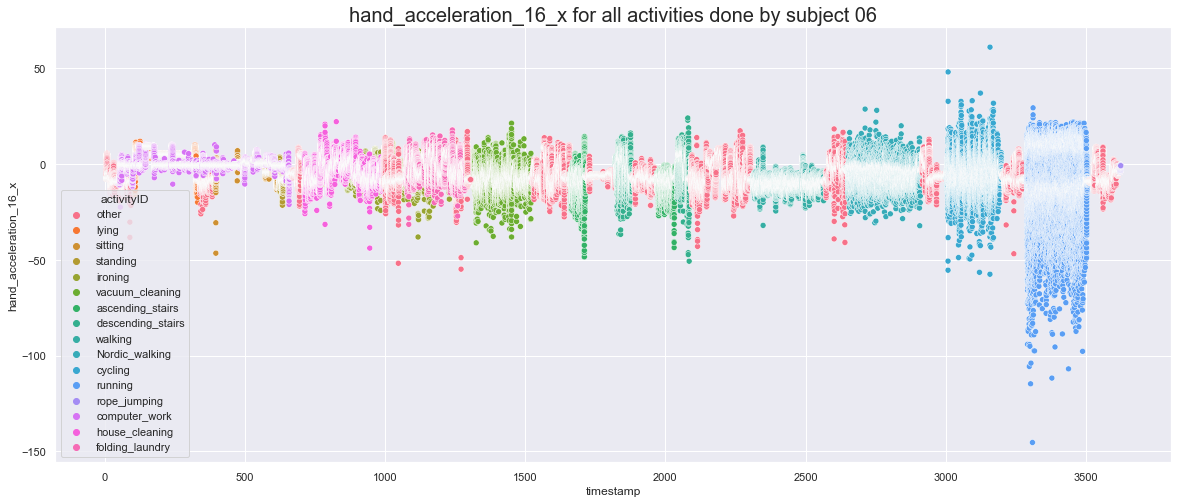

In [46]:
#Protocol and optional data

ssda(df_, '06', 'hand_acceleration_16_x')

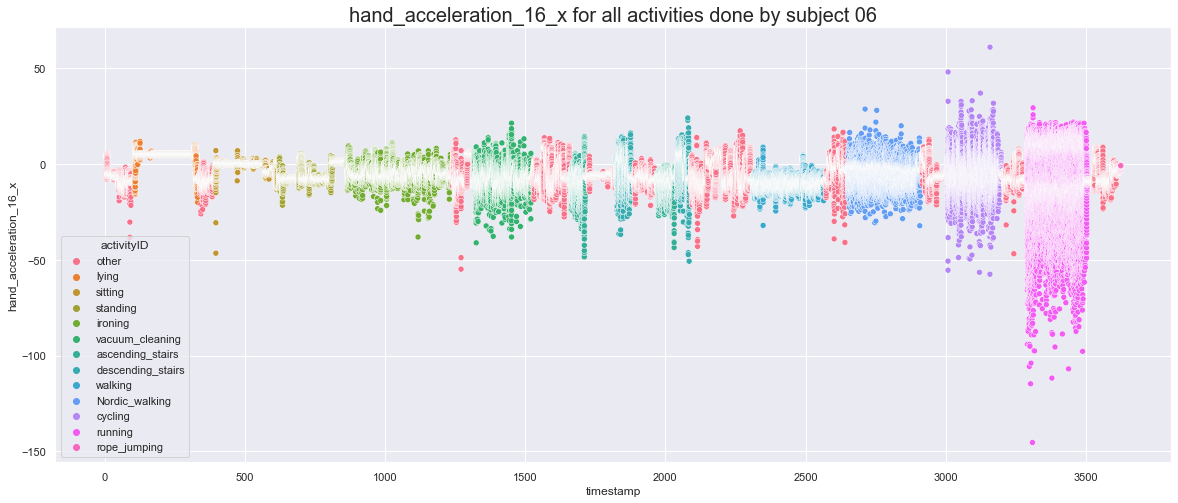

In [47]:
#Protocol data

ssda(df_pro, '06', 'hand_acceleration_16_x')

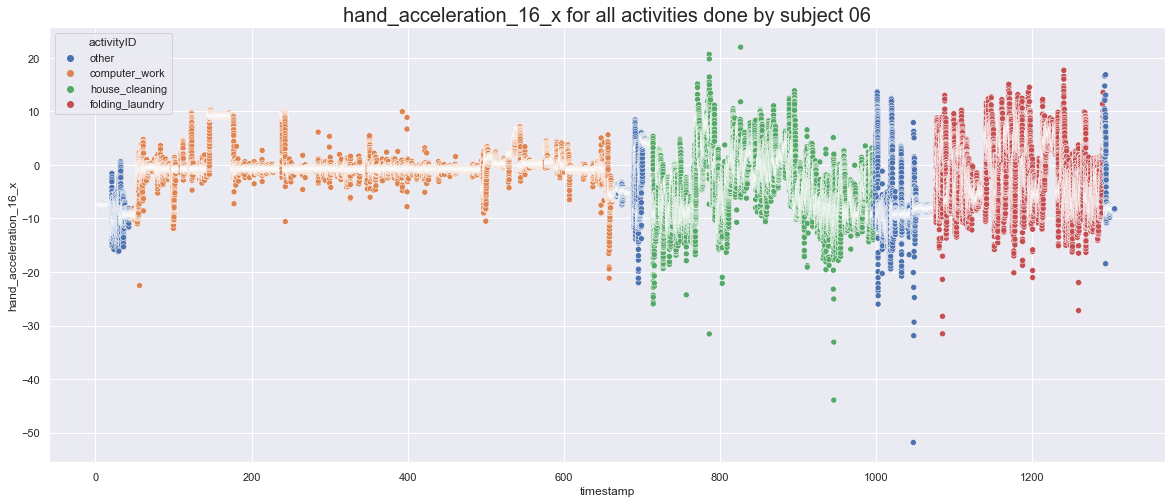

In [48]:
#Optional data

ssda(df_opt, '06', 'hand_acceleration_16_x')

The answer to our question is yes, but from the previous plots if we depend on classifying every point(record) separately, it will be hard for a model to distinguish between the activities. But if we look at periodic time windows, we see that the more aggressive the activity is, the more the variance within every time window. Hence new accumlative features need to be created to help the model. 
We can also see that the optional data is overlapping with the protocol data yet they are not contradicting each other, which means we can use both of them. Ex: while protocol data is predicting lying and setting, optional data is predicting computer work for the same time period. Standard deviation is the key to divide the activities into 5 types.

<a id='the_42'></a> 

### 4.2 Do people have similar measurements while doing the same activity?

To answer this question one sensor data will be plotted for all the subjectIDs.

In [49]:
# Different subject different activities same sensor

def dsda(sensor):
    sns.set(rc={"figure.figsize":(18, 8)})

    for i in range(9):
        plt.figure()
        sns.scatterplot(data=df_[df_['subjectID'] == '0{}'.format(i+1)], 
                        x="timestamp", y=sensor,hue="activityID")
        plt.title("{} for subject 0{}".format(sensor, i+1), fontsize = 20)

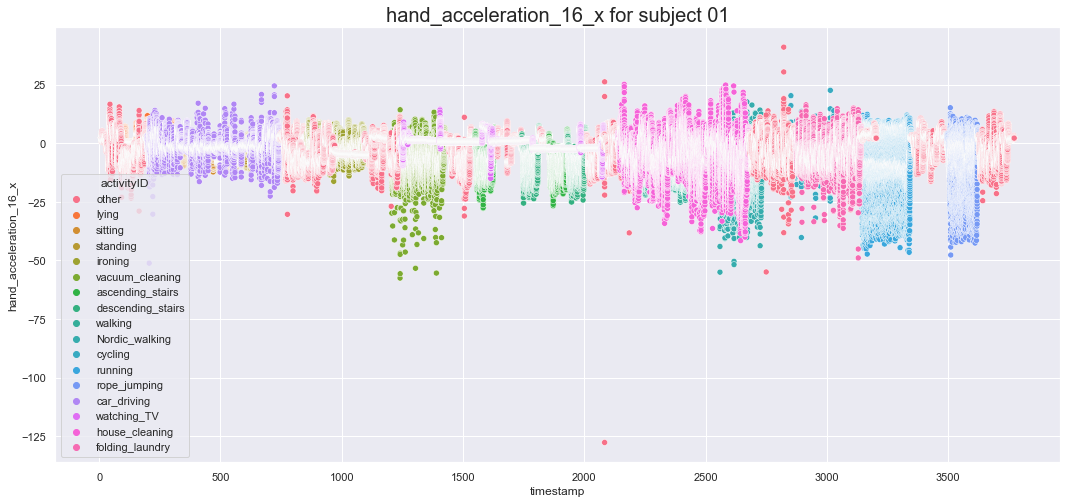

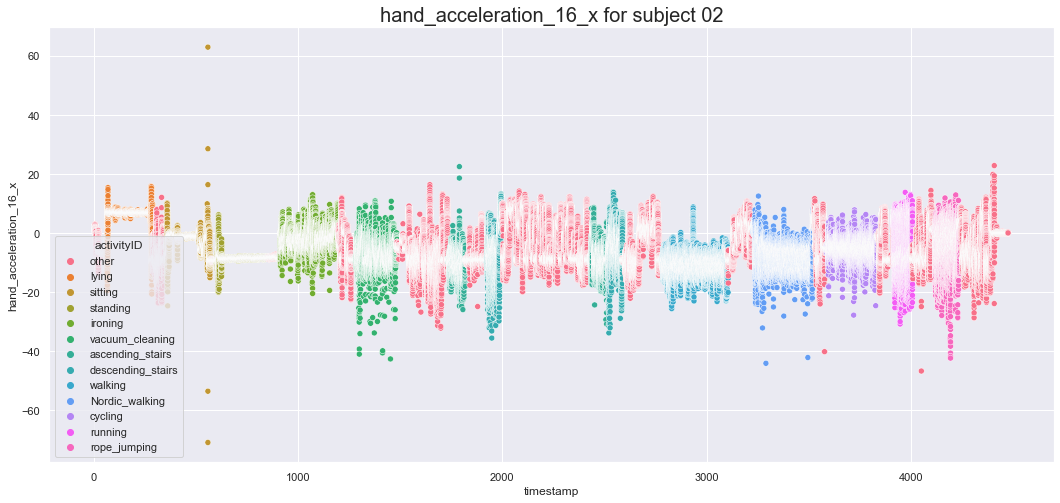

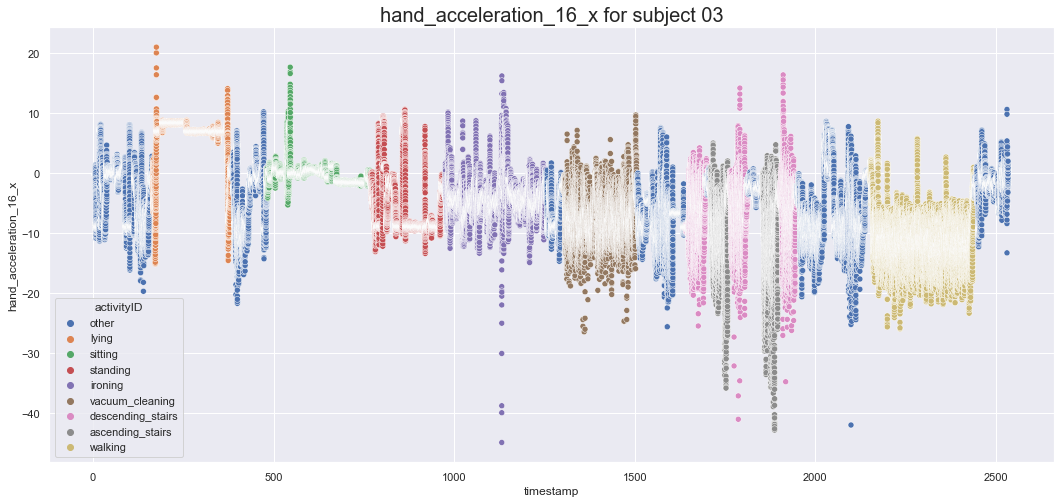

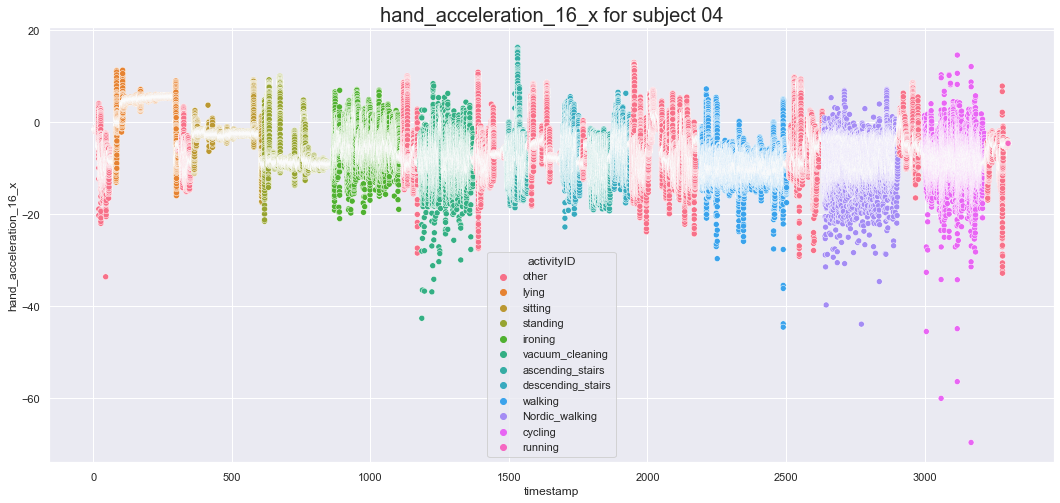

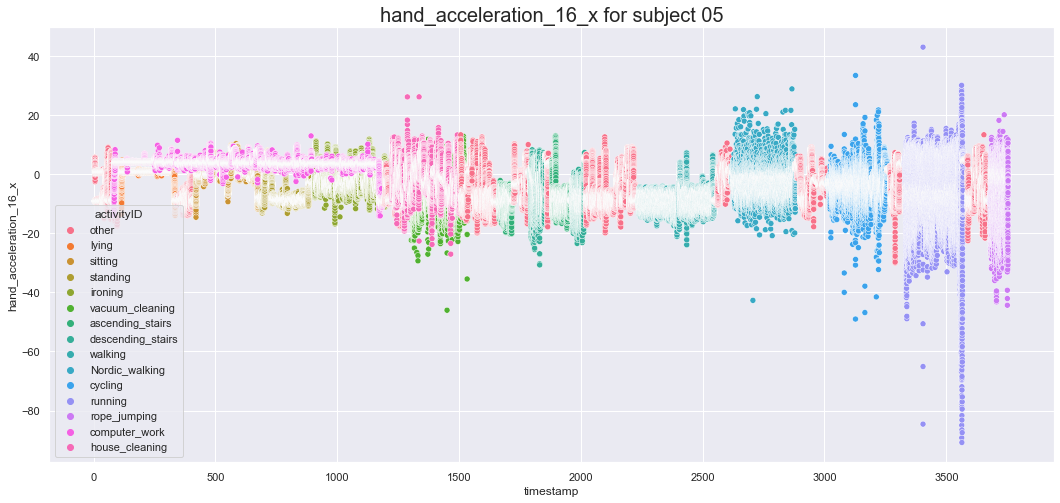

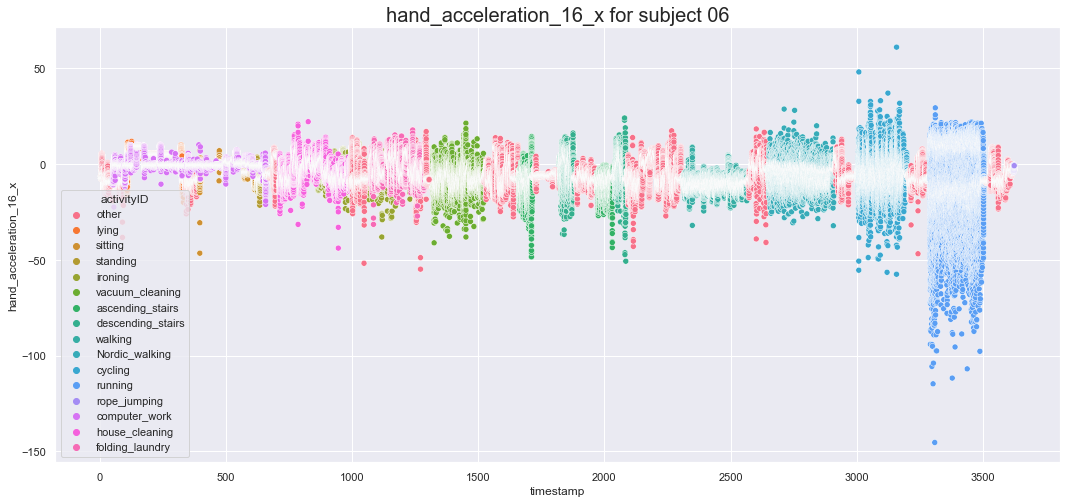

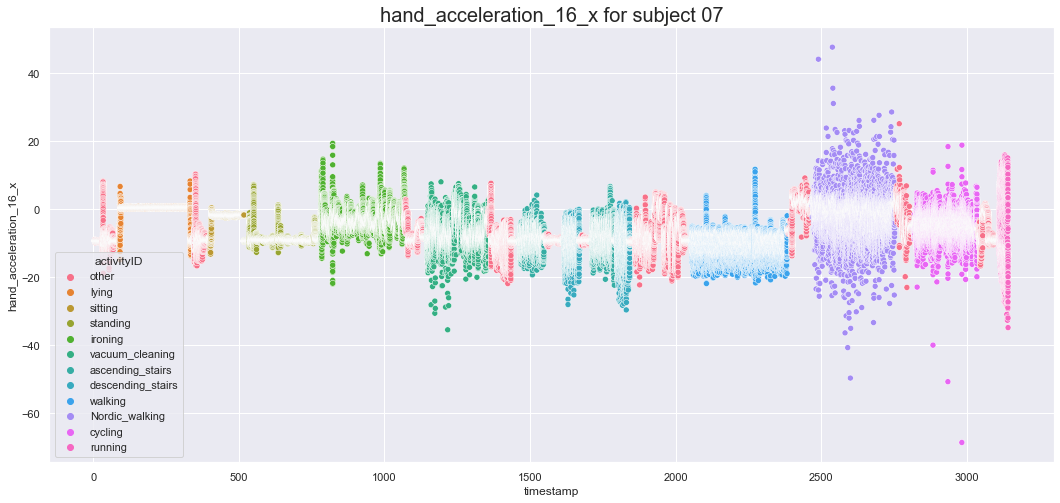

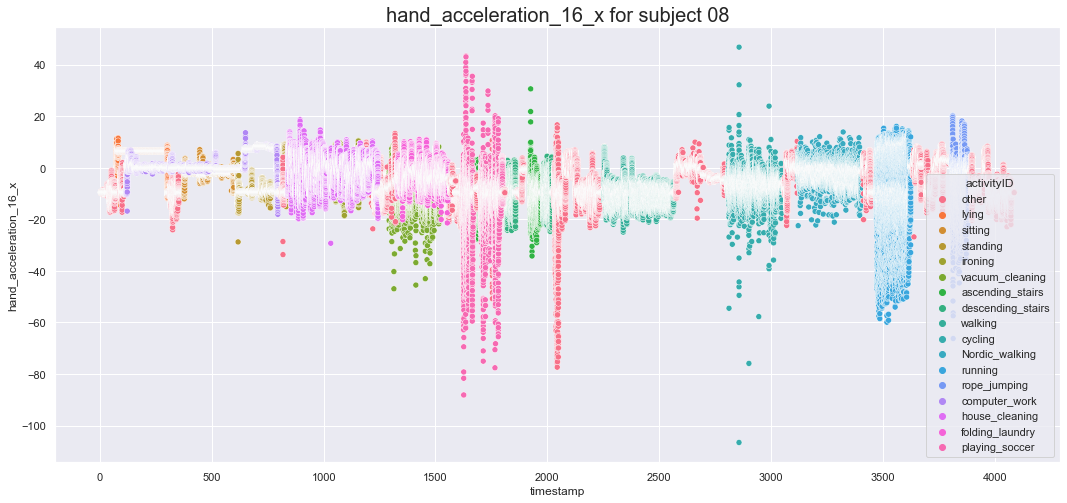

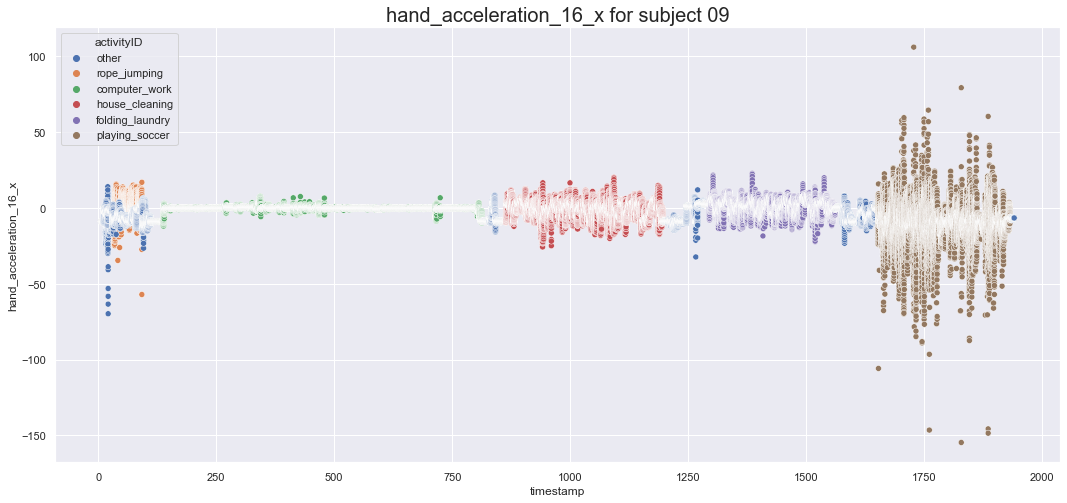

In [50]:
dsda('hand_acceleration_16_x')

We can conclude from these figures that change in measurement variablity is happening accross all subjects, which means we can use our model to classify new users data without depending on history about them. Saying that and since our subjects are doing the same activity with slightly different intensities, integrating our model with another model which has features about every subject's history will boost the accuracy of our overall predictions. Also there are some spikes that needs to be deleted because it might confuse the model. Ex: Looking at subject03 there are two time windows with a high variablity yet a 'lying' label. Deleting these spikes will avoid confusing the model between 'lying' and 'running' during the training process. 

<a id='the_43'></a> 

### 4.3 Are the three axes of the sensor following the same behaviour?

To answer this question chest_gyroscope sensor for subject0 data will be plotted across the 3 axes while 'lying' and 'rope_jumping'.

In [51]:
#Same subject same activity - all sensor data
def sssa(sensor, id_, activity):
    dfm = df_[(df_['subjectID'] == id_) & (df_['activityID'] == activity)][['timestamp', '{}_x'.format(sensor), '{}_y'.format(sensor) ,'{}_z'.format(sensor)]].melt('timestamp', var_name='cols', value_name='vals')

    plt.title("{} for subject {} while {}".format(sensor, id_, activity), fontsize = 20)
    sns.scatterplot(data=dfm, x="timestamp", y="vals", hue="cols")

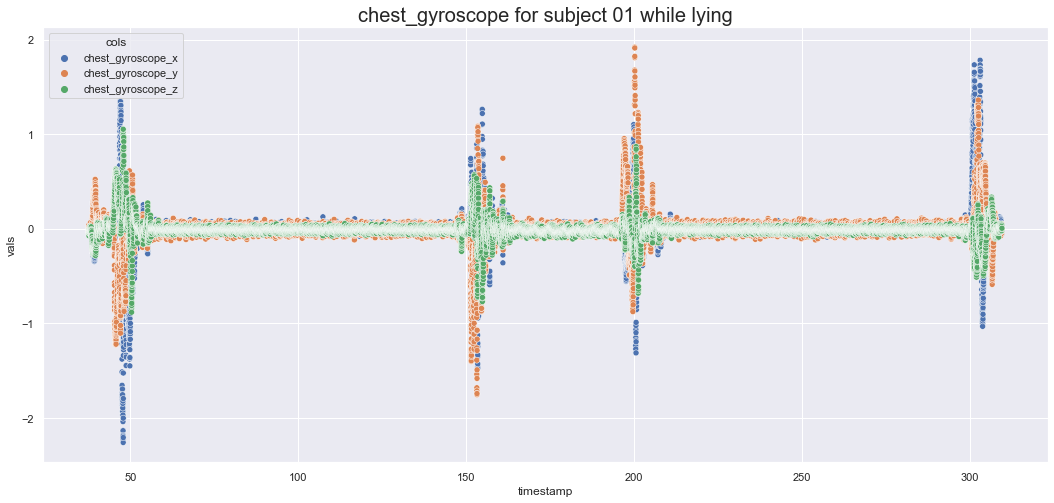

In [52]:
sssa('chest_gyroscope', '01', 'lying')

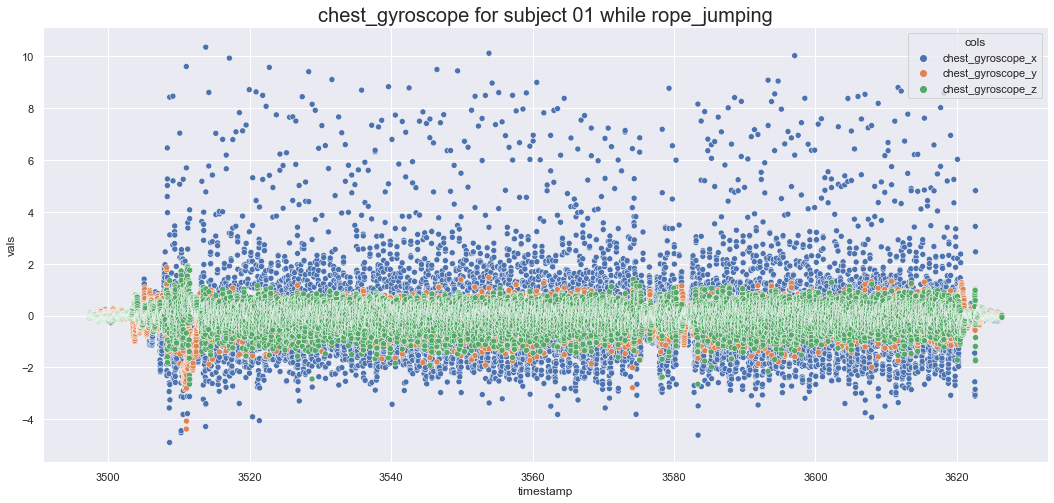

In [53]:
sssa('chest_gyroscope', '01', 'rope_jumping')

From the previous plots we can conclude that all the axes are following the same behaviour(High variablity in measurements for intense activities and vice versa), which means we can do the same pre-processing on all of them. The diffenece will be in the maximum threshold of deviation to consider it having a specific label or a spike(noise). 

<a id='the_44'></a> 

### 4.4 Distribution of activities across all subjects

To choose either to train on all subjects or to hold one of them to be used only for testing to mimic the real life case, the number of avilable activities need to be plotted for every subject. 

<AxesSubplot:xlabel='subjectID', ylabel='activity_count'>

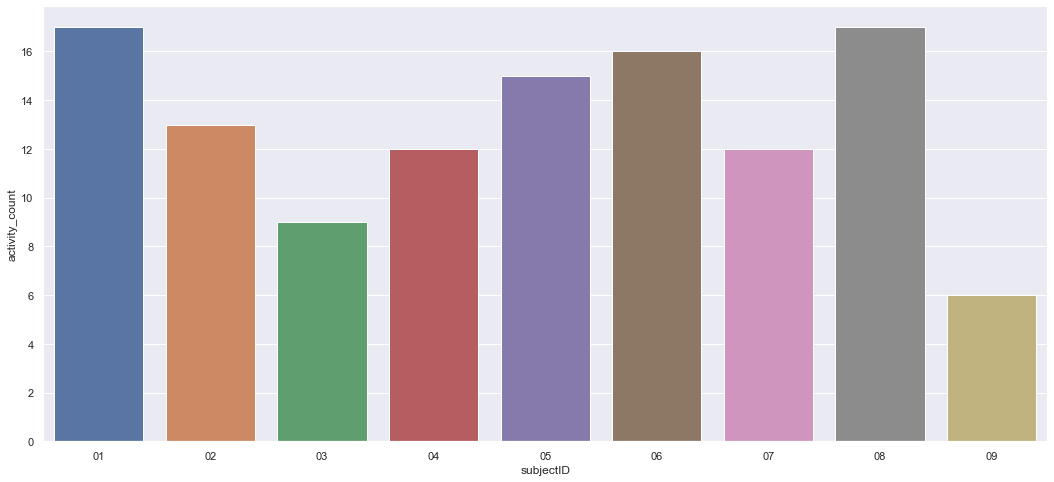

In [54]:
df_agg = df_.groupby('subjectID')['activityID'].unique().reset_index()
df_agg['activity_count'] = [len(df_agg['activityID'][i]) for i in range(9)]

sns.barplot(data=df_agg, x="subjectID", y="activity_count")

In [55]:
df_agg = df_.groupby('subjectID')['activityID'].count().reset_index()
df_agg['data%'] = (df_agg['activityID']/3850505)*100 
df_agg

subjectID  activityID      data%
0        01      695769  18.069552
1        02      447000  11.608867
2        03      252833   6.566230
3        04      329576   8.559293
4        05      529556  13.752897
5        06      491780  12.771831
6        07      313599   8.144360
7        08      588443  15.282229
8        09      201949   5.244741

All subject09 will be held to be part of the testing phase to evaluate the model performance on new users, knowing that its records are 5% of the total records.

<a id='the_45'></a> 

### 4.5 Correlation and Multicollinearity  

To try the logistic regression (linear based) in the modeling stage, we need to check the correlation between the features in order to avoid multicollinearity. 

In [56]:
corr_coff = df_pro.corr().unstack()
corr_coff = corr_coff[(corr_coff != 1) & (corr_coff != -1)]
corr_coff = corr_coff[(corr_coff >= 0.5) | (corr_coff <= -0.5)]
corr_coff.sort_values(ascending=False)

chest_temperature        hand_temperature           0.783425
hand_temperature         chest_temperature          0.783425
timestamp                heart_rate                 0.731796
heart_rate               timestamp                  0.731796
chest_temperature        ankle_temperature          0.605721
ankle_temperature        chest_temperature          0.605721
ankle_magnetometer_x     chest_magnetometer_y       0.539288
chest_magnetometer_y     ankle_magnetometer_x       0.539288
hand_temperature         ankle_temperature          0.530370
ankle_temperature        hand_temperature           0.530370
hand_temperature         timestamp                 -0.506329
timestamp                hand_temperature          -0.506329
chest_magnetometer_x     ankle_magnetometer_z      -0.530562
ankle_magnetometer_z     chest_magnetometer_x      -0.530562
hand_magnetometer_z      hand_acceleration_16_z    -0.533155
hand_acceleration_16_z   hand_magnetometer_z       -0.533155
hand_magnetometer_x     

The features are moderately corrlated so no features will be deleted.

<a id='the_46'></a> 

### 4.6 Summary 

Step we need to do in the pre-processing based on the visualization process:
- Deciding the time window size for the features to be created and for the predictions.
- Deleting others atiities and concating the optional and protocol data.
- Deleting the spikes within every activity.
- Handling NaNs using the mean after deleting the spikes.
- Spliting the data into train, dev, test, and hold subject09 to be part of the test stage.

<a id='the_datapreprocessing'></a> 

## 5 Data Pre-Processing   

<a id='the_51'></a> 

### 5.1 Aggregated windows

["Subject Cross Validation in Human Activity Recognition" ](https://arxiv.org/abs/1904.02666) paper concluded that overlapping windows are not worth their extra computational cost while dealing with Human Activity Recognition systems. That's why subject activities were grouped into windows of 100 non overlapping observations. And since the timestamp is based on the IMUs, which have a sampling frequency of 100Hz, each window will be 1 sec. For the HR-monitor with a sampling frequency of 9Hz, there will be almost 11 non NaN observation within each window.

In [57]:
#Obervation/Hz
100/9

11.11111111111111

Text(0.5, 1.0, 'Snap of Subject01 activities measured by hand_acceleration_16_x windows grouping')

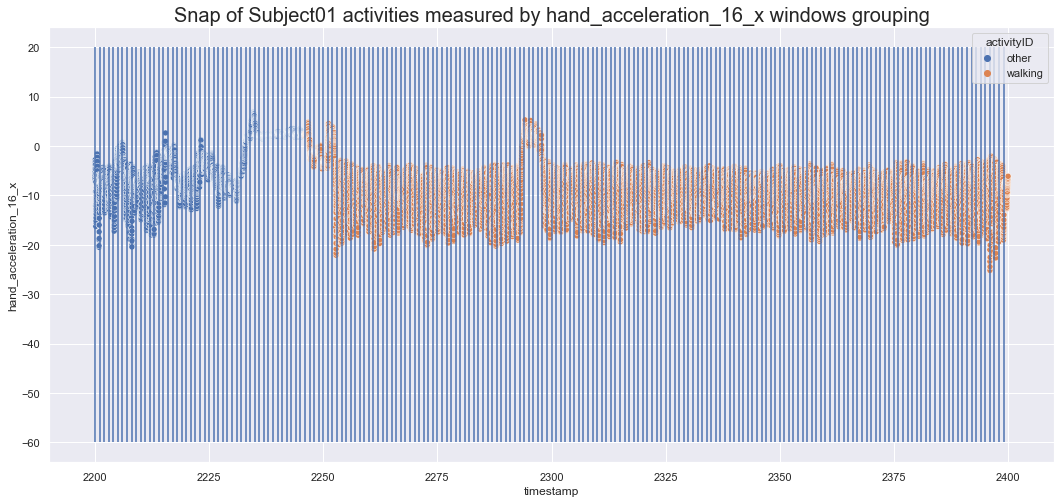

In [58]:
# This is only for visualising the concept 

dummy = df_pro[(df_pro['timestamp']>=2200) & (df_pro['timestamp']<=2400)]

sns.scatterplot(data=dummy[dummy['subjectID'] == '01'], x="timestamp", y='hand_acceleration_16_x',hue="activityID")
for i in range(2200, 2400,1):
    plt.vlines(i, -60, 20)

plt.title("Snap of Subject01 activities measured by hand_acceleration_16_x windows grouping", fontsize = 20)

In [59]:
# Test the aggregation

dummy = dummy.append(dummy)
dummy

timestamp activityID  heart_rate  hand_temperature  \
219162    2200.00      other       122.0           33.5625   
219163    2200.01      other         NaN           33.5625   
219164    2200.02      other         NaN           33.5625   
219165    2200.03      other         NaN           33.5625   
219166    2200.04      other         NaN           33.5625   
...           ...        ...         ...               ...   
239407    2399.96    walking         NaN           32.9375   
239408    2399.97    walking         NaN           32.9375   
239409    2399.98    walking         NaN           32.9375   
239410    2399.99    walking         NaN           32.9375   
239411    2400.00    walking         NaN           32.9375   

        hand_acceleration_16_x  hand_acceleration_16_y  \
219162                -6.67875                1.308640   
219163                -6.34798               -0.211221   
219164                -5.89369               -0.668987   
219165                -5.22979               -0.526843   
219166                -4.55467               -0.306138   
...                        ...                     ...   
239407                -6.60335               -0.283840   
239408                -6.75397               -0.396155   
239409                -6.67652               -0.320525   
239410                -7.09087               -0.316979   
239411                -7.16671               -0.354335   

        hand_acceleration_16_z  hand_gyroscope_x  hand_gyroscope_y  \
219162                3.245550         -3.183260          0.160071   
219163                3.294120         -2.648130          0.025069   
219164                3.417930         -1.911180         -0.080095   
219165                2.927060         -1.025360         -0.197337   
219166                2.743990         -0.310470         -0.248959   
...                        ...               ...               ...   
239407               -0.789122          0.635842         -1.641300   
239408               -0.752512          0.564708         -1.557820   
239409               -0.713120          0.452549         -1.461360   
239410               -0.680851          0.247984         -1.329380   
239411               -0.681861          0.169392         -1.164980   

        hand_gyroscope_z  ...  ankle_acceleration_16_x  \
219162         -0.265123  ...                  29.0967   
219163         -0.016827  ...                  27.1981   
219164          0.184098  ...                  20.2813   
219165          0.427520  ...                  19.3181   
219166          0.613173  ...                  17.2052   
...                  ...  ...                      ...   
239407         -2.023140  ...                  11.3723   
239408         -1.833360  ...                  12.1620   
239409         -1.601920  ...                  12.4452   
239410         -1.388090  ...                  12.3722   
239411         -1.140650  ...                  12.3748   

        ankle_acceleration_16_y  ankle_acceleration_16_z  ankle_gyroscope_x  \
219162                20.447300                 2.933770          -0.346782   
219163                16.713200                 1.355300          -0.316045   
219164                15.977900                -0.949269          -0.056947   
219165                12.586100                 1.338690          -0.268443   
219166                15.234100                 4.156210          -0.051918   
...                         ...                      ...                ...   
239407                 0.106470                -3.334690           1.091040   
239408                 0.822894                -3.331040           1.036840   
239409                 1.091920                -3.947230           0.890459   
239410                 0.597515                -3.790560           0.746232   
239411                 0.890258                -2.441710           0.689588   

        ankle_gyroscope_y  ankle_gyroscope_z  ankle_magnetometer_x  \
219162   

In [136]:
def create_agg_data(df_rest):
    
    sub_ls = df_rest['subjectID'].unique()
    df_agg_sub = pd.DataFrame()

    for id_ in sub_ls:
        df_subject = df_rest[df_rest['subjectID'] == id_]
        df_subject.reset_index(drop=True, inplace=True)

        for i in range(0, len(df_subject), 100):
            if i+100>len(df_subject):
                print(i, 'here')
                break

            dummy = df_subject[i:i+100].groupby('subjectID', as_index=False).aggregate({
            'activityID':['max']
            ,'heart_rate':['mean']
            ,'hand_temperature':['mean', 'std', 'min', 'max']
            ,'hand_acceleration_16_x':['mean', 'std', 'min', 'max']
            ,'hand_acceleration_16_y':['mean', 'std', 'min', 'max']
            ,'hand_acceleration_16_z':['mean', 'std', 'min', 'max']
            ,'hand_gyroscope_x':['mean', 'std', 'min', 'max']
            ,'hand_gyroscope_y':['mean', 'std', 'min', 'max']
            ,'hand_gyroscope_z':['mean', 'std', 'min', 'max']
            ,'hand_magnetometer_x':['mean', 'std', 'min', 'max']
            ,'hand_magnetometer_y':['mean', 'std', 'min', 'max']
            ,'hand_magnetometer_z':['mean', 'std', 'min', 'max']
            ,'chest_temperature':['mean', 'std', 'min', 'max']
            ,'chest_acceleration_16_x':['mean', 'std', 'min', 'max']
            ,'chest_acceleration_16_y':['mean', 'std', 'min', 'max']
            ,'chest_acceleration_16_z':['mean', 'std', 'min', 'max']
            ,'chest_gyroscope_x':['mean', 'std', 'min', 'max']
            ,'chest_gyroscope_y':['mean', 'std', 'min', 'max']
            ,'chest_gyroscope_z':['mean', 'std', 'min', 'max']
            ,'chest_magnetometer_x':['mean', 'std', 'min', 'max']
            ,'chest_magnetometer_y':['mean', 'std', 'min', 'max']
            ,'chest_magnetometer_z':['mean', 'std', 'min', 'max']
            ,'ankle_temperature':['mean', 'std', 'min', 'max']
            ,'ankle_acceleration_16_x':['mean', 'std', 'min', 'max']
            ,'ankle_acceleration_16_y':['mean', 'std', 'min', 'max']
            ,'ankle_acceleration_16_z':['mean', 'std', 'min', 'max']
            ,'ankle_gyroscope_x':['mean', 'std', 'min', 'max']
            ,'ankle_gyroscope_y':['mean', 'std', 'min', 'max']
            ,'ankle_gyroscope_z':['mean', 'std', 'min', 'max']
            ,'ankle_magnetometer_x':['mean', 'std', 'min', 'max']
            ,'ankle_magnetometer_y':['mean', 'std', 'min', 'max']
            ,'ankle_magnetometer_z':['mean', 'std', 'min', 'max']})

            dummy.columns = dummy.columns.map('_'.join)
            df_agg_sub = df_agg_sub.append(dummy)
            print(i+100)
    return df_agg_sub

df_agg_sub = create_agg_data(df_pro)

In [62]:
2872533/100

28725.33

Holding subject09 data based on the analysis done in section 4.4 to evaluate odel on completely new subjects.

In [64]:
df_09 = df_pro[df_pro['subjectID'] == '09']
df_rest = df_pro[df_pro['subjectID'] != '09']

len(df_09), len(df_rest)

(8477, 2864056)

<a id='the_52'></a> 

### 5.2 Creating target

Cretaing the 5 Types of physical activities: Sedentary, Light, Moderate, Vigorous, and Very vigorous which we refered to in the background section

In [65]:
def target(df_):
    df_copy = df_.copy()
    df_copy['activityID_max'].replace({
    'lying' : 0
    ,'sitting': 0
    ,'standing':0
    ,'computer_work':0
    ,'watching_TV':0

    ,'car_driving':1
    ,'folding_laundry':1
    ,'house_cleaning':1
    ,'walking':1

    ,'ironing':2
    ,'playing_soccer':2

    ,'ascending_stairs':3
    ,'descending_stairs':3
    ,'vacuum_cleaning':3
    ,'cycling':3


    ,'Nordic_walking':4
    ,'running':4
    ,'rope_jumping':4
    }, inplace = True)
    return df_copy
    
df_copy = target(df_agg_sub)

In [66]:
df_copy = df_copy[df_copy['activityID_max'] != 'other']
df_copy['activityID_max'] = df_copy['activityID_max'].astype(int)
df_copy

subjectID_  activityID_max  heart_rate_mean  hand_temperature_mean  \
0          01               0       101.000000              30.380000   
0          01               0       101.555556              30.437500   
0          01               0       102.000000              30.437500   
0          01               0       102.000000              30.437500   
0          01               0       102.000000              30.440000   
..        ...             ...              ...                    ...   
0          09               4       160.777778              25.125000   
0          09               4       161.000000              25.125000   
0          09               4       161.000000              25.161250   
0          09               4       161.333333              25.125000   
0          09               4       162.000000              25.143125   

    hand_temperature_std  hand_temperature_min  hand_temperature_max  \
0               0.017041               30.3750               30.4375   
0               0.000000               30.4375               30.4375   
0               0.000000               30.4375               30.4375   
0               0.000000               30.4375               30.4375   
0               0.012309               30.4375               30.5000   
..                   ...                   ...                   ...   
0               0.000000               25.1250               25.1250   
0               0.000000               25.1250               25.1250   
0               0.031003               25.1250               25.1875   
0               0.000000               25.1250               25.1250   
0               0.028503               25.1250               25.1875   

    hand_acceleration_16_x_mean  hand_acceleration_16_x_std  \
0                      0.003111                    1.851536   
0                     -1.386363                    0.645769   
0                     -1.669550                    0.919339   
0                     -1.230244                    0.713014   
0                     -0.947785                    1.017167   
..                          ...                         ...   
0                      2.637819                    5.199234   
0                      0.806296                    7.642980   
0                     -4.455263                    4.974691   
0                      0.277999                    3.600045   
0                      4.867479                    0.556919   

    hand_acceleration_16_x_min  ...  ankle_magnetometer_x_min  \
0                     -2.67148  ...                  -62.6839   
0                     -2.78134  ...                  -61.0291   
0                     -3.36202  ...                  -58.9047   
0                     -2.70514  ...                  -57.7905   
0                     -4.11759  ...                  -59.0407   
..                         ...  ...                       ...   
0                     -4.39983  ...                  -38.9669   
0                    -57.04570  ...                  -40.5297   
0                    -27.33250  ...                  -46.3777   
0                     -6.15837  ...                  -46.6853   
0                      3.99680  ...                  -46.9241   

    ankle_magnetometer_x_max  ankle_magnetometer_y_mean  \
0                   -60.1262                 -36.129588   
0                   -56.7821                 -39.773064   
0                   -56.4431                 -42.232818   
0                   -55.9808                 -42.690312   
0                   -56.2136                 -42.282675   
..                       ...                        ...   
0                   -12.7967                 -32.004810   
0                   -16.2428                 -30.745734   
0                   -33.9318                 -18.108341   
0                   -44.7538                  -1.562064   
0                   -45.1468                  -0.913690   

    ankle_magn

In [67]:
#Shuffle the DataFrame to make sure the model is taking differenct subjectIDs 
df_copy = df_copy.sample(frac=1)

In [68]:
df_copy

subjectID_  activityID_max  heart_rate_mean  hand_temperature_mean  \
0          03               2             83.0               32.81250   
0          03               0             79.0               32.15875   
0          02               1            120.0               31.37500   
0          06               0             72.0               33.46000   
0          02               3            119.0               29.27625   
..        ...             ...              ...                    ...   
0          06               1             93.0               31.75000   
0          03               0             76.0               31.43750   
0          08               0             72.0               34.31250   
0          04               3            109.8               33.68750   
0          06               4             91.0               31.00000   

    hand_temperature_std  hand_temperature_min  hand_temperature_max  \
0               0.000000               32.8125               32.8125   
0               0.031307               32.1250               32.1875   
0               0.000000               31.3750               31.3750   
0               0.030151               33.4375               33.5000   
0               0.031003               29.2500               29.3125   
..                   ...                   ...                   ...   
0               0.000000               31.7500               31.7500   
0               0.000000               31.4375               31.4375   
0               0.000000               34.3125               34.3125   
0               0.000000               33.6875               33.6875   
0               0.000000               31.0000               31.0000   

    hand_acceleration_16_x_mean  hand_acceleration_16_x_std  \
0                     -5.447120                    0.995050   
0                     -1.659626                    0.072216   
0                    -10.711670                    1.742663   
0                      0.170090                    0.083946   
0                     -7.345580                    1.027523   
..                          ...                         ...   
0                    -10.115542                    1.576248   
0                      7.013412                    0.093590   
0                     -2.972670                    0.241815   
0                     -0.578992                    0.879440   
0                     -3.516357                    0.232193   

    hand_acceleration_16_x_min  ...  ankle_magnetometer_x_min  \
0                   -10.250000  ...                  -36.1898   
0                    -1.855330  ...                  -14.4590   
0                   -13.860000  ...                  -36.1046   
0                    -0.015002  ...                  -21.4370   
0                   -10.387900  ...                  -43.0469   
..                         ...  ...                       ...   
0                   -14.695300  ...                  -38.6931   
0                     6.732010  ...                  -14.9158   
0                    -3.446190  ...                  -19.3187   
0                    -2.638630  ...                  -23.2289   
0                    -4.173570  ...                  -27.1276   

    ankle_magnetometer_x_max  ankle_magnetometer_y_mean  \
0                  -32.93550                  19.839834   
0                  -13.22310                  -4.355892   
0                  -18.46170                  12.572545   
0                  -18.29310                  -3.419405   
0                  -35.95600                  -8.614614   
..                       ...                        ...   
0                   -8.45525                 -17.057571   
0                  -13.34460                  22.627950   
0                  -17.77930                  15.705969   
0                   13.54800                  18.686810   
0                  -25.05380                 -12.384087   

    ankle_magn

<a id='the_53'></a> 

### 5.3 Split Data 

Data need to be splited before creating new features to avoid data leakage and mmisleading evaluation matrix. As we explained subject09 will be held as part of the test data to mimic the new user's evaluation matrix

In [69]:
# For the rest of the subjects devide them into 60 train- 20 validate- 20 test
def train_split(all_train_df):
    target_variable = 'activityID_max'
    vars_to_select = all_train_df.columns.drop(['subjectID_','activityID_max'])
    msk = np.random.rand(len(all_train_df)) < 0.8
    x_train_original = all_train_df[msk][vars_to_select]
    x_test = all_train_df[~msk][vars_to_select]
    y_train_original = all_train_df[msk][target_variable]
    y_test = all_train_df[~msk][target_variable]

    msk = np.random.rand(len(x_train_original)) < 0.8
    x_train = x_train_original[msk][vars_to_select]
    x_val = x_train_original[~msk][vars_to_select]
    y_train = y_train_original[msk]
    y_val = y_train_original[~msk]

    return x_train, y_train, x_val, y_val, x_test, y_test

In [70]:
x_train, y_train, x_val, y_val, x_test, y_test = train_split(df_copy)
len(x_train)/len(df_copy)*100, len(x_val)/len(df_copy)*100, len(x_test)/len(df_copy)*100

(64.1178895300907, 16.055234954657873, 19.826875515251444)

In [71]:
y_val.value_counts()

0    914
3    889
4    566
2    378
1    369
Name: activityID_max, dtype: int64

<a id='the_hypothesistesting'></a> 

## 6 Hypothesis testing 

We assumed from the previous visualisations that the standard deviation of the measurement changes according to the activty. To test this hypothesis we will look at std of for activity 0 (Sedentary) and activity 4 (Very vigorous).

- H0: mean(hand_acceleration_16_x_std during activity 0) = mean(hand_acceleration_16_x_std during activity 4)
- H1: mean(hand_acceleration_16_x_std during activity 0) != mean(hand_acceleration_16_x_std during activity 4) 

In [110]:
def hypothesis_test(df_, feature):
    value_for_0 = df_[df_['activityID_max'] == 0][feature]
    value_for_4 = df_[df_['activityID_max'] == 4][feature]

    
    
    ttest, p_value = ttest_ind(value_for_0, value_for_4)

    print('H0: mean({} during activity 0) = mean({} during activity 4)'.format(feature, feature))
    print('H1: mean({} during activity 0) != mean({} during activity 4)'.format(feature, feature), '\n')
    print("p-value", p_value)

    if p_value < 0.05:
          print("Reject null hypothesis, which mean this data can't be seen under the assumption the null hypothesis is true")
    else:
          print("Accept null hypothesis")

<a id='the_61'></a> 

### 6.1 Splitting Data 

In [132]:
#Train 80% and test on 20% for the hypothesis testing 

msk = np.random.rand(len(df_copy)) < 0.8
training = df_copy[msk]
testing = df_copy[~msk]

In [134]:
#Train result

hypothesis_test(training, 'hand_temperature_std') 

H0: mean(hand_temperature_std during activity 0) = mean(hand_temperature_std during activity 4)
H1: mean(hand_temperature_std during activity 0) != mean(hand_temperature_std during activity 4) 

p-value 0.011206494182439863
Reject null hypothesis, which mean this data can't be seen under the assumption the null hypothesis is true


In [135]:
hypothesis_test(testing, 'hand_temperature_std')

H0: mean(hand_temperature_std during activity 0) = mean(hand_temperature_std during activity 4)
H1: mean(hand_temperature_std during activity 0) != mean(hand_temperature_std during activity 4) 

p-value 0.04676264190406926
Reject null hypothesis, which mean this data can't be seen under the assumption the null hypothesis is true


<a id='the_62'></a> 

### 6.2 Hyothesis Conclusion

Both training and testing data sets rejected the null hypotheseis. We can conclude from that the model will have features to use to distinguish between the activities, and there is a significant difference between the hand_temperature_std during Sedentary compared to Very vigorous activities

<a id='the_modeling'></a> 

## 7 Modeling

The problem is a classification one and there is a list of models that can be used including logistic regression, SVM, decision trees .. etc

Decision trees are fast when it comes to their performance, and they are robust to outliers to some extent. There most obvious drawback was the interpretability, and it's solved by having the SHAP graphs from which we can tell how the splits are done and if it's a positive or a negative relation with the target

XGB is based on decision trees, yet it uses the ensembling method to boost the classifier results by adding more weight in each step to every misclassified point. It's also easy to control the depth of each tree and to set a threshold of information gain for every split.

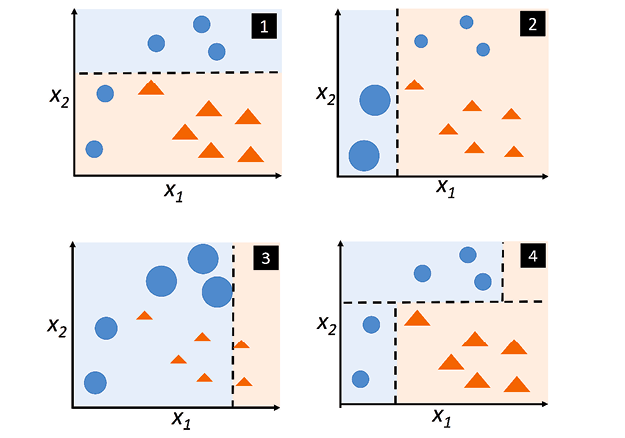

In [130]:
base64_data = "iVBORw0KGgoAAAANSUhEUgAAAnEAAAG2CAYAAAAQiNCpAAAYe2lDQ1BJQ0MgUHJvZmlsZQAAWIWVeQk4Vd/39z53vrjmeZ7HzHOSeZ7nIZVrHi9dU4SEZCpkSCGFRIpGU0KGlGRKlCKFUCoNppD/MdTv+//+3ud9n3ffZ5/zuWuvvdZeaw/rrHMA4OggBgcHIGgBCCSFkq0NtHkdnZx5sZMAgn9owAvoiO4hwVqWlqYALn/u/7ssDcO8cHkuuSXrv9v/r4XewzPEHQDIBcZuHiHugTBuBQAV7x5MDgUAowvTBSJCg7ewD4wZyfAAYRy9hb13cOYWdtvBZds8ttY6MK4HAEdFJJK9AaDugOm84e7esBzqKbiNnuThS4JZV2C8392H6AEAhwrMsycwMGgLwxWIwvzBME6HsYrbP2R6/y/5bn/lE4nef/GOXdsFp+sbEhxAjPz/dM3/uwQGhP3RIQxXKh+yofWW/bAPX/oHmWxhKhjPk9zMLbZ8DeMVX48dvwOAoPAJM7Tb4UdwuofowP4DzDCW8SDqmsCYE8b6pABz0126m5evvhGM4dWCOOobamS72zfZM0TPZldmITnI2uIP9iLraO32rSaSt/Vu8XeE+dtp7cp/6eNp9Ef+zygfWwcYUwCApAj3tTeHMTWMGUP8bUx2eJD8UT465n94yGHWW+MXhLGKJ8lAe0c+0sWLrG+9yx8cGPLHXmSSj6+R+S7OD/WxNdzxD/KaO3F7/KwwrvUkadn9keMZ4mj6xxYPT129HduRvZ4ku117kePBodrWu30XggMsd/lROM8Agy06P4zZQ8Jtdvui9oXCi3NHPso0ONTSdmecKFc/orHlznhQ4cAU6ABdePeFwdUNBAE/4Ns7XzcP/9tp0QdEQAbewBNI7lL+9HDYbiHBVxsQBT7DyBOE/O2nvd3qCcJh+sZf6s5VEnhtt4Zv9/AHH2AcCExAAPw/bLsX6a82ezAFU3z/S7s7PNYAuG61/TdNC6aY7lLC/sjlpfnDidHD6GIMMfoYMRQ7aj9KDWUKXzXhKodSQan+Ge1/+NEf0APo9+gX6An0q8O+8eR/jcUMTMDy9XctdvunxShhWKYiShulDkuHJaOYUexAEqUA69FCacCaFWGqzu64t2zn/T/Y+deCf/h8lw8vg0fgWfCaeNF/96QWp1b8K2XLo//0z85Y3f56Vedvy7/16/zDzx7w3eTfnMhk5B1kF/Ih8gmyCVkHeJEtyHpkD/LBFv67hqa219Afbdbb4/GH5fj+lz7irs4tT4bIVMnMyazvtoFQz6OhWxtMJyg4kuzr7RPKqwVHAU9eI5K71B5eORlZVQC2YsrOMfXDejtWQMx9/6ER4ZihIgdvae3/0ILgs6E6F94a5/9DE4b3Lhss7ba1exg5fIeG2rqg4dOABt5RbIAbCABR2CI5oATUgCbQA8bAAtgCJ3AI9rMPvJ7JIAJEgxMgCaSBTJALLoBiUAoqwA1wG9SBJvAQPAJPQT94AV7D62cafAILYAmsQRCEhQgQA8QG8UBCkAQkB6lA+yE9yBSyhpwgV8gbIkFhUDSUAKVBZ6EL0GWoEroFNUAPoSfQAPQKegfNQd+hXwgkggrBiOBCCCOkESoILYQJwhZxEOGNOIKIQiQiziDyESWI64haxEPEU8QLxATiE2IRCZCUSGYkH1ISqYLUQVognZFeSDIyFpmKzEOWIKuRjfBMP0dOIOeRqygMigHFi5KE17Ahyg7ljjqCikWloy6gKlC1qA7Uc9Q71ALqN5qA5kRLoPeijdCOaG90BDoJnYcuR99Dd8K7aRq9hMFgmDEiGGV4Nzph/DDHMOmYIkwNphUzgJnELGKxWDasBFYda4ElYkOxSdjz2OvYFuwgdhq7gqPE8eDkcPo4ZxwJF4/Lw13DNeMGcTO4NTwtXgi/F2+B98BH4jPwZfhGfB9+Gr9GQUchQqFOYUvhR3GCIp+imqKT4g3FD0pKSn5KVUorSl/KOMp8ypuUjynfUa5S0VOJU+lQuVCFUZ2hukrVSvWK6geBQBAmaBKcCaGEM4RKQjthnLBCzUAtRW1E7UF9nLqAupZ6kPoLDZ5GiEaL5hBNFE0ezR2aPpp5WjytMK0OLZE2lraAtoF2hHaRjoFOls6CLpAune4a3RO6WXosvTC9Hr0HfSJ9KX07/SQDkkGAQYfBnSGBoYyhk2GaEcMowmjE6MeYxniDsZdxgYmeSYHJnukoUwHTA6YJZiSzMLMRcwBzBvNt5mHmXyxcLFosniwpLNUsgyzLrBysmqyerKmsNawvWH+x8bLpsfmzZbHVsY2xo9jF2a3YI9gvsneyz3MwcqhxuHOkctzmGOVEcIpzWnMe4yzl7OFc5OLmMuAK5jrP1c41z83Mrcntx53D3cw9x8PAs5/HlyeHp4XnIy8TrxZvAG8+bwfvAh8nnyFfGN9lvl6+NX4Rfjv+eP4a/jEBCgEVAS+BHIE2gQVBHkEzwWjBKsFRIbyQipCP0DmhLqFlYRFhB+FTwnXCsyKsIkYiUSJVIm9ECaIaokdES0SHxDBiKmL+YkVi/eIIcUVxH/EC8T4JhISShK9EkcTAHvQe1T2kPSV7RiSpJLUkwyWrJN9JMUuZSsVL1Ul9kRaUdpbOku6S/i2jKBMgUybzWpZe1lg2XrZR9rucuJy7XIHckDxBXl/+uHy9/DcFCQVPhYsKLxUZFM0UTym2KW4oKSuRlaqV5pQFlV2VC5VHVBhVLFXSVR6rolW1VY+rNqmu7lXaG7r39t6vapJq/mrX1Gb3iezz3Fe2b1KdX52ofll9Yj/vftf9l/ZPaPBpEDVKNN5rCmh6aJZrzmiJaflpXdf6oi2jTda+p72ss1cnRqdVF6lroJuq26tHr2end0FvXJ9f31u/Sn/BQNHgmEGrIdrQxDDLcMSIy8jdqNJowVjZOMa4w4TKxMbkgsl7U3FTsmmjGcLM2Czb7I25kDnJvM4CWBhZZFuMWYpYHrG8b4WxsrQqsPpgLWsdbd1lw2Bz2OaazZKttm2G7Ws7UbswuzZ7GnsX+0r7ZQddh7MOE47SjjGOT53YnXyd6p2xzvbO5c6LB/QO5B6YdlF0SXIZPihy8OjBJ4fYDwUcenCY5jDx8B1XtKuD6zXXdaIFsYS46GbkVui24K7jfs79k4emR47HnKe651nPGS91r7Nes97q3tnecz4aPnk+8746vhd8v/kZ+hX7Lftb+F/13wxwCKgJxAW6BjaQ6En+pI4g7qCjQQPBEsFJwRNH9h7JPbJANiGXh0AhB0PqQxnhh/eeMNGwk2HvwveHF4SvRNhH3DlKd5R0tCdSPDIlciZKP+rKMdQx92Nt0XzRJ6LfxWjFXI6FYt1i244LHE88Ph1nEFdxguKE/4ln8TLxZ+N/JjgkNCZyJcYlTp40OFmVRJ1ETho5pXaqOBmV7JvcmyKfcj7ld6pHaneaTFpe2nq6e3r3adnT+ac3z3id6c1QyriYickkZQ5naWRVnKU7G3V2MtssuzaHNyc152fu4dwneQp5xecozoWdm8g3za8/L3g+8/z6BZ8LLwq0C2oKOQtTCpeLPIoGL2perC7mKk4r/nXJ99LLywaXa0uES/JKMaXhpR/K7Mu6rqhcqSxnL08r37hKujpRYV3RUalcWXmN81pGFaIqrGruusv1/hu6N+qrJasv1zDXpN0EN8Nufrzlemv4tsnttjsqd6rvCt0tvMdwL7UWqo2sXajzqZuod6ofaDBuaGtUa7x3X+r+1Sa+poIHTA8ymimaE5s3W6JaFluDW+cfej+cbDvc9rrdsX2ow6qjt9Ok8/Ej/UftXVpdLY/VHzc92fukoVulu+6p0tPaHsWee88Un93rVeqt7VPuq+9X7W8c2DfQPKgx+PC57vNHQ0ZDT1+YvxgYtht+OeIyMvHS4+Xsq4BX30bDR9dex71Bv0kdox3LG+ccL3kr9rZmQmniwTvddz3vbd6/nnSf/DQVMrU+nfiB8CFvhmemclZutmlOf67/44GP05+CP63NJ32m+1z4RfTL3a+aX3sWHBemv5G/bX5P/8H24+pPhZ9ti5aL40uBS2vLqStsKxWrKqtdvxx+zaxFrGPX8zfENhp/m/x+sxm4uRlMJBO3HwWQcEV4eQHw/SoABCcAGPrhZ4oDOznfbkHCDx8I+G4PSUGfEB3IBJQNWhMjgmXHseJ5KNQpzan8CZnUDTTzdJL0ngyljJPM4iyRrC3sNBwOnGVcP3j28SbyPROgE7QWOi38VBSIyYt7SZzb0y25LC0qYyUbJ1cl/0IRoSSrfFAlVbV277t9BHWV/a4aKZq3tN7o4HSV9Nz1Mw3qDceNIRNBUwMzP/MMi7uWL61WbJht5e0s7AMdTjtWOz11fndgwWX54Nph4EpBZHOTdNfysPY87OXpTfSx8d3nx+sP+U8EtAReIiUE+QRbHlEh84bgQr6GDoc1h1dEZB+NjQyIcjpmFK0eoxyrdFw1TuuESbxDgmdi6MmTSTmnypLvpLSm9qQNp789PXPmc8b3zMWspbOL2Ys5v/JQ55jy95w3uOBecLwwv6j6Ykvx00tDl0dLJkrnyn6WI68yVYhXal9zqYq4nnPjdvVAzbdbdLfl79jcDbmXWVtZ11j/sKG9sfX+/aZ7D2qaK1tKW4se5raltkd3+HXaPFLqYu1afTzxpK/70dP2nofPmnpr+vL7QwZ0BgmDz58XDHm9UBxGD4+MVLwMf6U5ihntgteX4puZsaxxtfHJt6cn1CY+vSt+bz2JnKyZsptanc75sOdDy4z1zNTsyTnpuamPFZ9I8/Lzi59rvrh/pft6b8Fy4cO36O8s3x/9yPhJWiQuecHraOpX54bU5ub2/AtANxF+SDnkLOoWOg7jiFXHSeJFKEQo+alkCHuprWjcaWPpiumbGeaYaJlVWIisyWx32cc5KbnkuQ/wxPFe5mvhfy2wKEQpzCOiKGok5ioeKZG955Zkj9SsDEqWT26fvLNCqGKaUplyg8oz1fd7f+7DqHPsl9Uw0wzQytC+qdOv+1kfZ8BlKGekZ2xn4m5KMjtqHmuRYHnSKsk62SbVNt0u1T7RIdLRx8nWWfeAhov+QedDEYdzXW8S29y63Ts97nkWeh3zdvCR8aXynffr928MqAwsIGUExQeTj7iQNUN4QtZCX4TdCE+KcDuqFykTJXiMK5othimW9jjm+FLc+xPd8bcSchMjTh5MMj6lm2yaQkw9kXYl/dHp8TNfMhYzl7MWz/7IXsj5nDuf9+XcynnaC6oFpMLyot6Lk8Vzl6Yvvy15VTpQ9vhKc3nT1e6Kz9f4qg5eL7zxqobxpvmtZPj0Wr0nVetRV1A/2Ii+r9B0+MHJ5vKWptbmh9faMttjOiI64x5ldBU9Ln1ysfvM07Aem2eSvaje0b7b/WkDfoNWz/WG9F5YDbuNhL1MfHVqNOa11xudMfax+fGGt6cmHN9Jvse9/zDZPlU0feSD5gzVzNBs6dzxj76fPOZ9Pgd+Cf4avBD8jfw9/Efkz4hF3yWDZZrlOyt6K09XnVc//+pfp9oY3Z5/CdABmUAvEZ5IDDIDJYHqQ0dhpDFz2Cs4H7w0fpWim7KYKoJgTS1HQ02zRPuKrpW+kiGbMYbJm9maRZ1VjI2JbZ19lmOQs5mrmruUp4A3jy+HP0MgSTBciCisJ8IrsiLaI1YsHiJhuIdPEiE5JzUi/VimUfaaXL58nIKroqoSRqlPOVfFUZVN9dXeIjWPfXLqGPXx/bUaGZo+Wrrawjq0ukD3h96M/rDBfcM8I09jIeMJk3xTCzOsWbt5goWRJavlR6tm62wbH1s1O4LduP0Nh2hHYycmp7fOFQeC4Pi/evDBobjDOq441wFioZu/+z4PKo9Rz6teR7xVvNd9Wnzj/DT9gX9rwIlAHRKK1Bl0MlgreOVIFdkJjtmVoRahP8Pyw/eFj0fEHeU6+iDSNYo5avRYVXRCjGOsaOzS8fa47BPe8boJ4omsJymTQNLPU5PJz1JqUtPTiOkKp7GnR8/czEjN9M8yOEt/9lH2gez5nKhcrTztc8nncRdSC6aK2C7KFateUr2sWCJdKlrGd4WtnO4qRQW+kgZeSerXXW+cqr5R8/zm+m3RO853z94bqGOsd2oobBxpQj8QazZocWs9/vBiW3P7247NR3xdOo+9n6R333o63LPRK9Z3oP/cwPhzuaHTL76M2LxsGOV7nTsm/Zb6XcRU2mzkZ/PvS6tWW/O/8+5vq2CUAMiG80z703CdAyCrDs4z7wPAQgGAJQEAW1WAOFUNEAbVAPI/+Td+QHDiiYNzTmbAA8SAApxpmgJnOG8+ClLgjPI6aAaD4ANYh+ghMUgTzg9DoNNwPtgJTSIgBB9CG+GBOAVneYOIX0gBpBkyClmBHEHhUHtRgahS1Cs0PdoEzsjaMRBGExOHacOiscbYTOxLHB8uANeAx+Id8BX4XxRmFJcplinNKSuoUFRuVO0EIUIK4Qu1LXUTnOlk0QLaI7RTdE50ffT69A8YVBhqGfcytjNZM00yh7FgWPJYhVnr2czZZtmTOWQ5JjmLudy4JbhXeB7x5vJ58CsIYAReC94RyhAOEDERlRAjiC2Iv5C4v+eiZKyUi7SqDKPMguwzuWvyKQo+isZKUspMypsqn1XH9w6qde/rVO/Y36XRqzmqNau9pAv0MPA5hzPEGeGNqUwYTfnMFMzNLUiWOVZN1tO2BDsFeyeHGMdLTh3OMy6UB2UO2R+Odi0j9rqteAh62nid9G7y+eWn438+YJXkHjR4RJ/cFKoQVhMhefRW1L5j/TFBxznjhuNzEk1PLp3KSdmT2pnueYYp423Ws+yx3M183guqhaYXD1+KLLlUNnpVsvLSdZnqiVuX7x6qo2yobjrYItHG06n/uKSHqk90YGkoa0T01cCbi2/PvR/84Dq3+pn+6/Xv4KfMkury5mrqr/q1ofX7G6W/gzeVt88PaPudAz3gAMJADmgAM+ACAkEsyAJloAH0gWmwATFD0pAx5AUlQCXQQ+g9AoUQQZgiyIgLiHbEVyQn0gQZjaxBTqHYUdaoNFQnGkKro4+h76PXMRqYBMwTLC3WCXsF+x2nhcvGfcCr4bPx8xT68JyvUzpS3oUzYTLVEEGVcImakvoo9QyNE00vrT5tK91+uhZ6HfpuBhuGMTgz/cWUwSzO/JTlCCszay2bFdsH9kgOAkcZpybnFFcWtzEPNc8Y7x2+M/y+AtqCrIKfhB4IZ4p4iWqLCYnTS+D2oCVxUtTS9DJ0sjjZVblZ+RGFbsWHSg+Vu1Veq35Xo94no26131cjVJOs5aPtqGOgq6qnoK9iYGB42CjW+LJJl+mCOYeFnqU/HNNybM7Z5trl2F9yaHH85qx4IM7l2SHuw6GufW4C7l4euZ73vHq9p3zW/Jj95QNsA8NJF4Jagz+SWUL0Q8PDroaPHqWNNIvKOPYyRjg25vjkCe8E2sTupNBkTMqpNFR68hmOjPas+GzHXJ1zaufVCtSKVIvFLqNKHpWFl3NcfVDpVsV0fay682bf7cV7snXRDU+baJp1W8lt5R1zXdpPbvfI9hb2jw3+HPo2PPNycnT2zc+30DuKScZpwRnDubx55a+pP8qXA1Z71xLX2zd+/l7dnn8EvPvpADeQBPuBFfACMSAP3AQ94COEhyQgM4gM5UOt0EcEM0IXEYooR4wi6ZBGyERkK3IDpYaKQjWi1tFa6FT0CEYMcwIzht2PLcHhcEG4IbwqvogCQeFH8YJSl/I+lSrVQ4Il4QN1PA0fTSutC+0SXSa9JP0zBhIjgbGCSZvpDXMkCzdLL+sZNjd2bQ5xTkbONa4x7nqes7yBfKb8MgKsghjBVaFvwl9FfohuiFNLCO7RlHSVipMukqmXfS73Q4Fd0UgpXrldlWqvi9pNdSz8rNqsxa+drcusV23gbERnPGB6wTzI0s5azmbUztm+x9HQ6fkBL5eVQwmuEDHY7YWHsmehN97nhB+Ff2mgWRAIriMHhXKHtUeERXoc+xJbFhd5Yjh+PRFxEpdEe0o+OSRlKM0ufe5McqZU1qvs5Fy1vG/5lRcOFVIUXS1WvvSgRKO09YpueXeFZeVQle31/mr9moZborfP3cXdi6ldr09pFL7f/yC+Ral1rq2ww+IRquv+k5CnEj1TvRf7HQcZnw++yBgxfrk5ev2Nxdjs27CJjffxU8jp+BnEbMJH1Kfj81++6H+NXCj6dvp72A/dH8s/ry2aL75e8llaWg5fnltxWelb1Vmt+kX4FfxrcE1xLX/t27rResn62obtxo3fyN+Ov69vQpt2m9e25j/ES15uO3xAVNoAoMc3N38IA4A9C8BG1ubmWsnm5kYpnGy8AaA1YOd70nasoQWg8O0W6hZ/Tvr3t5ydb03/yGP+fQfbkWhbKxyJtspWVAL/A3r26ef3jOwmAAAAVmVYSWZNTQAqAAAACAABh2kABAAAAAEAAAAaAAAAAAADkoYABwAAABIAAABEoAIABAAAAAEAAAJxoAMABAAAAAEAAAG2AAAAAEFTQ0lJAAAAU2NyZWVuc2hvdBf1XhwAAAHWaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjQuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjYyNTwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAgICAgIDxleGlmOlVzZXJDb21tZW50PlNjcmVlbnNob3Q8L2V4aWY6VXNlckNvbW1lbnQ+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj40Mzg8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KtgWcDQAAQABJREFUeAHsXQd4G1XWPbJVLMs9jtNIJxA6hN47LL0usPQWFtil/LSFhYWl90CWTkLvvfdeQygJAZJAeo+TuNvq7T93ZCWysVxkyZbk+74okmfmtfNm7px33733mcJM0KQIKAKKgCKgCCgCioAikFEI5GRUa7WxioAioAgoAoqAIqAIKAIGAkri9EZQBBQBRUARUAQUAUUgAxFQEpeBg6ZNVgQUAUVAEVAEFAFFQEmc3gOKgCKgCCgCioAioAhkIAJK4jJw0LTJioAioAgoAoqAIqAIKInTe0ARUAQUAUVAEVAEFIEMREBJXAeDFggE1l7h9/vW/tYfioAioAjEyodsR6N1X/2BYLZ3WfunCKQ9AiaNE9fxGK1asRyvvPIqzj3vPIRCIeTkKPftGDW9QhHoGwjMnzMHgwYNQn5hYdZ3+JknnsCKFSuxy07bY8dddwF8nqzvs3awpxBgyFqzlZ+8nqowK+oxZ0UvUtyJBx94EP+94QZsOm4HbLXdtnA3+lNcoxavCGQHAhJJPMcE9C+yZEeHYnohmimz2YxJDz+MgoICXPXf/8aczc6fF1x8MaqrqzH++GOw485bA01rsrOj2qsIArm5gImfVKYQV7uoHEGImt38EqBASVxX4FZNXAdoNdbVoqxiAAJ+Pw477Ai89OqrWFOvJK4D2PS0IrAWASFxA0uyj8RJB1dXVmLI0KEYst5QzJq3AI1N2SsbHA4Lxm28AebOnYsLzzoNd903EWioXjvO+iPLEDDloLamFnV19cjNTc3qUzAYwsAB/WF35ANBkjl7MeAozzIgU9sd1cTFwTc6y77u2usMAieXvfHGa5g7fxkGDBkMn1ftQeJAp4cVgbUIiCbORBKXbSkqH675z1WQ34sXLcRTjz6Ok04/FXUN2UnkQi02aMzCQc22m7S7/bEXYI/DDsAvM2chz+FgacbT3Fxq9HcYuXzAg8a9ET0WW3Hbx6J5PE4nbrziEvz7miuBRp0QxCLX2d9K4uIgJcskHo8br775pnGFiTeqbDN79+034L4HH0SVkrg4yOnhdEQgEPDDXmhHeZ4JLV/GyWutaNzksVhd4+IyY3Zq3qJoiXwIcfnnsaefiR7CffdMwKkkcUFine39X9tp/ZHVCHg8EZtHIVupSv4Y58FU1ZHN5SqJa2d0/3bMMViwYIFxhQhtP5dUJ016CIcddSx23HNPeJ3ZOeNuBxI9laEI5Jfk47O338GE229EoaMgbi/CzQoWkzGzjnvZn05IvoDPj/W4rHj3o09m9bMR1cL94+9nw8uXnEzwJP366694jNq4E049FU1ZvKz6p8HXA1mLQE848UWfn6wFMcUdUxIXB2CZZf/1qKNxxhln4IYbbsTUH3/ExZdchlGj1kduTi5n4V18y8WpRw+nJwKidc2zm2Gz5BiLCNJKHsrYl7ONPGPB/LmYMmVKSgEfNmwY8mgH7U1pLb1buEzoVi5bhgcnTzYaIi+6YDBiXnHtNf/Gsaec2rsN1Np7BgHh7pQPkG/5yCtBPn4x0m8+xi9NikAqEVASFxddE44/5RTj7KSHJxnffznoMOyzx06o8oThcXpI5hS+uPBl6IkQmZoYcDssJkybU4PKKg/MXCeU4xZzDrbfvAI2a45hwE6bXEN2Z0JXhYBarXTfT3EqoO2M1JXtKYdee++8+Qa++uJL3HLnnUZ3H578OBwFhfC6s1NDLzzF5XIZffX5GDOThu99MskEnjJAbvRpvzkxY5kHX85zYofhdmw7Mh/jxtC70iYzmQwSEH1yILOj08pC4oxjrBrZTxsXSfX0VK2l7PK7A0rg4uCWyYdzc03oX2jB1JnVePGzhfh+lRNVnFXbuVxGvylY+RYb/ekC7LlhPxy110jk5Zm5nKYOLpk85om2fQDjwh14yKHUzK6zFTr4yOMZasSSsdrajrBwuvx4+sU3YGtYjmFD+vddz1SqmmfNdeHGd6rwaVMIQ/OsKLTYMGtOADf8vAbbFphw+T7l2G4zOgP4RCWnSRFIHQJK4lKHrZacQQiYqWXLs+Xg2kdn4N15tci32zGguBCDSOzWrqeyP25fEPf+UImv5lTjplO2REV5PhobfWvtojKoy9rUJCDgijH4rq6qRK55cBJKTc8iJBzEJluNQ//gUBpAehHmDjYmiSPWV5Jo4BxmvPVFDU7/pAablhRgx/5mw+FNICii9m1IoRWNnNj95dVK3LWsGKccRLLr4hRQvH4yMIVjhV8b7c9h6JGQLEkwiaZfguGbeU94vNlsUNEGEL14qI/qw3sRca067RCQVaFcLo9c/fBPeHFuLdbrV4Ty/Ih3ZYi+82L/GP1YSfY27l9EDV0uTpj4HX6auRolxdYORF3adVkbpAh0GYEcPih+TwBhLz0WGaC1TxE4QYv2b6uWezHx23psXV6EUmriRS6I+UD0I/KigLJkp/7FuGNaA5YscUeWXruMdnpkMHVgMCIEbqvNt8CUr7+Gl8RNnP/cdPZ5/aUX0qMDfaAVSuL6wCBrF+MjIOZb/biE+vpHC/Di4npsVlEC8cxsz65LBHVxvhXW/Hw8xnxOzrTNorHLotTaY0xm15oUgT6NAO0pbnlrNepMVuRzMhfPuU1kh5XywEFt/v0fM/ZZBsuGjjRxcj9cdP4D2HLrTXE8ozkcc+QR+GX2Hzjs6GPw8mP39unbpac6rySup5DWetISASFfy9e48PL0lRhXUYpA89JAR40VAV7B7WGm1njx1LtzGbYjOywTorag4p17Cr0sJz/wAI7ZZwfiorZ/Hd0Tej6LEeCbctlSL36uDWAwl0zjEbgoAnJ+sMOKl5f7aStHZxBzZk7yOtLESX9vnnAGbUH74bmXXsJLr72OHfbYHStqm3DUqWfTRMUWhUS/U4SAkrgUAavFZgYCBSRfb3y1FJVeep920W5FCN+Y0gJ8wyVYN6PcCvHJ9CQ2LQMGDsT7H3yExx9/DGecfTb23Zw2UJr6PAJBLqHa6bltKuDWSNyoPNSXgrRSNjQ2BbEmmEs+1klCxstEJjjFPKyLsiVTbjbR2M+aNXttiJ1cht9xr16Fyjm/wkOnjiDJrKbUIqAkLrX4aulpjoDwrm/nVKHcYetwdt1WV2RPwXoKqpnzqumtmh1LjpUrV2KXnbfA//39OqPLDR66ZGvq8wiI4fobLzyP+yfeh+k/TEeOzd6nMGE4QOSLIX9ne03ZIi/YHLHP6HSmzhaeHte1nrgGSeytDCY+bJNxyKueiyCdXzSlFgElcanFV0tPcwRknphnkaXQTs6uW/VHJtiLnT7MX9oEu8SGyvA0oKICJxx7DJdHKvDBJ59leG+0+clEIN+ei0svOg//+NeVeOAxbjdWVJLM4tO+LCqpUUfD/U4r1SgbPNzKJCCWCH3oTXvpP69HeYENx515YbZy17S6V/vQrZVWuGtj0ggBsQNrbcjf6eaRBVop1SUQsBDCTE+rVq/Gsy++ZHSjpLAw07uj7U8iArIyVlpaapTocOSDa2VJLD3Ni6Iz00Yj8rB1YQ6aGGaoM8kbCGNzxozbdDg93f3ZIB067vWwsZvihlsuxFeffoIX3v2o4wx6RbcRUBLXbQi1gExGQPRvRpwjCunOmrq06C8LoKyGX/K3OJH5f7ReKsn8HmkPFIEEERC+SnOJAzcowLJGD3I68DiV83Pq3Th9y0I4Smncn8W2YVFnqNKSQfj2I27rF6rBX487JkGgNVtXEVAS11XE9PqsQyAQDtEAWT5d75oY7g5nuJEtxpTA6e7cDL3rtfRuDkKjSRFohUACD0urEjLqT5mhMYjvSQf3w8EDcvDNaifDCokGv2Uv5G+xk51d7cJOBSEctTs1l7KrS6vrWuZK3786CjEiKxjiDCVAzJgzC0PWs2KH9UZj1Zqa9O1UlrVMSVyWDah2p2sIyKto780GoJbG+x3NrluXLALby6WVAXk5GDWsBL5OLrO0Lifd/+6rW2Sm+7j0bvsylJV0FzQSsquPGoQzhuZiyqpG1HALRlkplVBF8l3LYMg/rW7EftyoYcLx3L0jw7luRyFGRFtvMedi5qw5GNrPj3132h5TV9a1QDlhU5UWpegf8RDIjuBW8XqnxxWBDhBoavLj0N2G4x3GiXNSANutuZ3WyOXSlm5xfT1O23cUBRnFnbC6LEyqicvCQe12lzKcnSTaf9pOFDhMuOnUIdh7agNenV6PKq8fH1f5sVuRBcPygAu3KsLhooGjiQW493LnPSESbVTq8nWkiZOaJ7/0CTYeuz6u+r9zMH3OEmy+ySbsehhmkrvKylUQO1tNqUNASVzqsNWSMwABWUK109bluJ2G4sp352HTgWK4HdlKp73mi9ZuYU0j9h9ahEP3HI66Bn97l2f0OdXEZfTwpajx2Tlh6RAscU0V8wJvCHtvV4S9dyhCY40Pvy7yYSyXEssqmu3fohvfd9qVtcOae+WCjjRxOWYL9t9zJ6NtN9z1AOQTm8496yw8MGlS7CH9nWQElMQlGVAtLvMQqG/w4ag9hqGOWrm7vlmK9UsKYeY+ifGisguBW1nnwnp8ev551MZwic1LFiYPwylICvqyl6Bm4bClrEtC22R/TEmyRyb6OrsXosZJYCEDIO+0pTXi4ZTBm90bA9vqv440caGAH9tyy60yuwUBsY2LMf6LauJaFal/JhkBJXFJBlSLyzwEZBm0ss6P8YeMRjF3cLj3s0WoC+dgvcJ8mDmTllVSI14nZVQVbeecbg8OHFWMC4/bBPl2KxobfVmzlGrnfo+LFy5EWXkpl5Uj4uHSSe/gvPv8qF42EyM23BqBgAhrTX0NAafLj2dfeQf5TcsweEA/oIH7gvb1JMxW1Pk+fiRluOYt0ol1/3ekiZMrl86fg6Xrsvzpl8hX9XT/EyxJO6AkLmlQakGZjIDI4hW1fhyy+3BsvH4ZPvpuOaYtqsPqRj/MNjO3lQkjJxzAfiPKsNtmI7DDFgPhojdqNhE4Gb8AI67fdvPNsDA6f4CzbK/XR62klXsg5sFTX4mwMdvO5JHWtieKgNhGjtl4Y1SEaLXv9yLMe8VET0xNikB7CCiBaw+d7p9TEtd9DLWEDhCQ7WrMDIZrpdMAvyJ76pEU+cXoN42SEDmxbRtYlo//O2asoZ3z0Gi50ennllpm2Lizw6B+NrjohlbfbAOXbc4Mskx2x8SJaTQq2pR0QiAgewSHvNQ8B5NL4ESDZaVwkG/RbEmS5UpxDtCkCCgCcRFQEhcXGj3RHQRE9Ap5K6fHVhONgBcva8TSNU6sZPykjUeUon9pHjYY4gAVXRAP0XRKQi5X1oaM9tvzLHDk24zlAJlRVtWnV1vTCTdtiyLQJQQMIcEcNu4/TO/O176jp2dTALmGCYMJh29TiBGjuDME5YdB5mSWpSnrEJAYnZoSR0BJXOLYac44CAjZyaexr8ROeui1OfhlcQOmrW5Cvs1Kxy7ubPB9JfJzwthiUCH24rLkLtsMNLRd6fYsR1cOjWCWcfqqhxUBRSABBITAMSyP2ME//X4NHpxWD2eO1VDCRSP1PD93DQ4YYsF/jq5ADomeEYhNiVwCYCeYhY4r1bW1CWbufDZTX3eQ6TxUbV6pJK5NWPRgoggIgSsptmLBkgZc/cwvWOIOoYz7LA7tX2zsPENRbCSJIzR1lRcvvToLJ89eg/+ethlWUcsVJU6J1q/5FAFFIDUIBEMBFBXZ6eTDje89TQh5XMgxJ/gKEUHA3U7GP7wU7zE27DblRaiQQ/xEZYT04rmVHsybvBxPjR/CrRB4hnJDUw8h4G7EE/fcSROTRu5CkRu3Uu5bYUzO417QxoloHrG53X/vXQBXQxtX6aHOIJDgE9iZovWavohAHmOuzVvUgIuf+Bk+sxXDymxGqI5Qs21LVHEuE+rSfAv6FZThjXm1CD/6Cy47eXM0yPqqpqQjINoNHwVmqlNjU5PhzZvqerT8nkcgv9COw/fdE7/N/A3/N/5UXHH1v/nyre96Q4SHUU489k4VXqOiZ4+KAgQoH6KyIfotBW9akodfGrw47/HluOfsobyJu16d5kgMgbDfhwMO/gtZtdCE2FFJrLw2c4kWzuOkk4xf5UabAHV8UElcxxjpFV1AQAz9r6EGzpNrRf8CErh2DJNlUh0MhjCyXyGe+qMGgxlsd/wh66OyNntCdnQBupRe6iXWG4zdCLvvvjvjWhUYdYlYjmo9Yn9HG9LVYz4K/SHrDTW2ioyWod/Zg4CFE4F5C+ZjTVUVlq2sBF2YE+scl1GXL/Pg+h/rsVtFsUHg4hUk5G50oQ2fVAcwbZYL48Y66EKdIkIRrxF99LhJtG8+d4/03qgrlJ3xNlMNoJK4VCPch8ovphPD258vwTxPGGPK2ydwsbAI0duEyynP/bAC223UH8MGF3AfUhXUsRh197eLwYl32Xc/HH7I/t0tqt38dF7E6hoXvZEt7V6nJzMPAUOBlsd9pZisVo5vokastJX9ZbEbBZ0kgWKiUcp4jM9+W4txm3ICEsg87LTFikCqEFASlypk+1i5IuCpVMPbP63AkII8ync50vlkoWBfEzTh299WYywD6SqJ6zx2nblSSJWfm3Wv7IGJtRK4zoxIpl/TDQ8Dep9+OqsJJVaz4fXdERKisbfTHs4VYp1qNNsRXHq+jyEQXU3pY93W7iYbAUe+Gd//sgpzuYVVHoPjdtX+WLRxwwrs+GZ2lRFHLtnt663yLNy+K5cEVZMioAg0I8DHQeRDV6Z58gyFxbBTzDOy6XESEEQ+iKeufFRW6GPSRQRUE9dFwPTythGQcCK1DIBb5w9iEGVRIouhORRi5pzcTs3O225F7x4VeSw45JPQ0m7biFW6vJKhVbiv4BA6eMhSo4vLxJ4s3Wu1d9HX2jMGATK4IWUWBOs7JyXClCc+2sGFcvgAWfhgZcvzI5HPGeB4xVIP3Nz9ReyJc2l4OHwYbQ1F66gmJRlzS/dmQ5XE9Sb6WVa3BOm0yGy5K1PsGAxkn74cRghO1NQmpqge/yl2O0VFVri4AfYH3y7DN1wWDptysajWiQJqJsvz6OhRZMb+Ow7BWAY7dvI6MdomWpoUgb6FAG3a9tm4AFf9xjhwdFoIiB1GOymXMqXaG8Cu4tTQVRV/O+X26inGvZs6owmvMT7eD6sDqA5SY89+crM7bNPPjCO3LMKe2xcx0DGFabb0uVcBz97KlcRl79j2aM+EuwWDQbhF4CTITELM6/dzP8YMW+QXAtePsfGm/VGNB96eiynVbgx22GFlDC2bOQ/VgTCW1XEf0lVOPP7rapy+xQCcefhYEl7ZqzRBxtujo6uVKQKRx7qJIWQkeb1eHkjwQSVp22x0Pk7sn4PZTh/KqamWZ7+tJHLFT/vaIOvbbeNyPjBtX9dW3rQ8Js235+Ddb+pw7sc1GEg5MaC4AMUxjf2NE7zX3q/C+N+bcM1JgyNBjjO82zHd059JRiDBpzDJrdDiMh4BL1X/A8rtKOdyR1edGqTzBgkMBGHjcmROBm2qLQSuf4kVn/9QidMen4Hl/lxsMaAUZflWOGgPJ2YuVmooi7lv7MDifGzKcy/OrsEF90xFLpdTZGsyTYpAJiAgIdp2230P7LDt1thq04243OdJrNmieONzftWhFahzutDoC/KZ//PMzyBwJC8zqhow6RB6rQ+3CaNLrM50yUWZ8CM1cBd/Uost+hdhEGNlmkhSQzGfElsuthtQjHsW+3Hva6tJ+qhrURKXLiOYdu3QV0jaDUlmNshNz8dtNumPHYcUoN7d9cCNYg+yosmFPTcdQA3WnwV6uqJSWGjFD7OrcfnrszGmrBjFXDqV5aG2FAtRQT2irAALnEHczIDIeXmqDE/XsdV2tURAwtQ88MSzmPL1pxj/99MQakxwSyY+3mESt6FD8/DcMQONYK+zuaey7OLi50e+xQl1hdOPhvomPLJvGXYaVwhw9xdwQpSxiU0P0TD20nfWYHhpgRGjsS05IcfE0Wvncgee+8OFuXOo/cwgmZix45OhDVcSl6EDl27NFhImUUV232wAlpCM5XZBxSQzbg+F+hDOUvelzVhjU2bs2iBaOHFgeOLD+SjKt0M8UeMtC8WOlwjoQRTibyxswGffr4DE19OkCKQ7AhI6xuPis+nkLg0M7JzwllvsqIlkLOwKYpP18/HeP4fhos3sCDudyHW5YHK74XM24qBBwLtnD6FM4DZfQuAymL8ZY0s7uJe+qcfKcC7yKSvaInCx94DYyFWZLPhitgtcoog9pb8VgbUIqBpgLRT6o7sIyJZZ++wwBIf8vBIfrmjEhuUF7e7YIPUJgZM0r7YB/ztqY3p2WuDMEBInWrgPvluJqatdGCV7w0r4g04muXZEiQMvfbsUu4wbaCyragisToKnl/UaAkI8xFzCZJJ7vXusSoic7L5gJqEZf2g5zti7dG2/gqzDYidxkdVTbxYQOKNnJiOWps1i5nfHTk2iuZfl1jlruJBNxw5NikBbCKgmri1U9FjCCPhos3LWYWOxQ7kVS+iZmUNBHSVqrQuVcwEKqkXV9Th1iwrsuvVANGUIgZO+iKnK3GXUSuQmZrMiXqs/c3eDX+gQYaew1qQI9EkEhBl6QtTs0R62+WNh6A3DiYHyIasSVygkDJHBgTvRsRLazX69wsOJbbYQ2U50Wi/pEgJK4roEl17cEQJiGzeofz7+d/722GdoAX5fU4cqeqC5SO6EtMlH4j7Vc2a5rM6J6rpGXLjncPz7hE3RSBuY7s3tO2pdcs9XMy7edwtqMZRBimXW3OXELHZ6sIpAT8QZpMv1aQZFIJ0RkEco9pPObU2wbfKcd2WLUBfta7fkhNiRz1e1YKNJEWiFgC6ntgJE/+weAmIbJ4ErfQzMedXpW+KwOdV477vlWEUN28+V9Ua4gP5UYW3RLx8VpSU4eo+RGDnIgRW1mUXgBKUgl0RdHi5z0BM1kSQ2dXbuQblwTRO2y61IpAjNowj0GALBUAD5hXZ6U0r8MiedEzwwNi7vsRZkekXyvEdCMeXkWDuc+MkKRiVtEP86ws7ZHpeWaUOoSRFojYCSuNaI6N9JQUDid8rS6Eajy7DtRv3A0EeYPbfa8Dor4NLhRiOLDPuQJkZfX1Pn45JrJung1kEUpBrNLKrFBJsvnqylDgp0nWWvA1V/pSUCDhK4Q/feFb/MmIFLzjkT/7nuajo51KVlW9OyUbTtO3DrQtz6bS3NSPIM79T22iky0Rz0Y5vRjCKnuze0B1WfPqfLqX16+FPbeTF1cZO9rWGgWxdnlBuMLMXY0aUYPMBhHKvhcqRsdJ+pBE4cG7YdXooGb9dDqgjyYthd4/WhJEFNXmpHT0tXBFoiIFEulixZgobGRqxaU8WwF2rH2RKhDv6iPMwrNOOKnUsxu6YDe2Hazf1Ke9ljR9kYk4/hVfw6y+sA3T57Wklcnx36nu24bKUle4bKR4hbNiRxbBhalo8aD5eVSMi6mvxcjh1Az7yKfnZiokslXcVPr+9ZBIRG2GwMuMtksZDAZeL+eEbre/E/yr7D9y7D9ds5MGV1E5z0zo3aCke/RRL8Xu3ELoVhXHb4gCzyzu1F3LO4al1OzeLB1a6lFoGaxgB232Ygnv9xBfwUxhLXqbNJBPayejeOHFuOjYYXorI2c5eUO9tnvS6bEFDNUMKjSdu24/YvZ2xJM56Z1og59WGs8knYFu7skhvGMO7Hd9kW+Tj1wH40oGMtstVY50VLws3SjJmJgJK4zBw3bXUaICCODSMGOnD89oNx41dLsVVFSYebeUuzhcBJcGNLwIfj9hmJ6qZgxi4pp8EwaBN6BQFlFd2CnSFVDty5BAfuWIyfZrmwvJqTOC6hFjAg8J5bFjBsERfJZIsx4coKdbegzvbMSuKyfYS1fylFoKrej2P2H405yxrx/tImrF/mMAJ5ij1gW0kInCydLq5rwBV7jcJAhmOpq1ctXFtY6bF0RiDODZ7OTU63tolZCWHceuN8bG12RFonliZynJp9TYpAZxBQm7jOoKTXKALtIOCi88b147fE3oPzMW1lLZwUwrKhtxC22I+stq5q9KC6sQmX7zkSJ+4/AnV07shUx452INFTWY+AqoeSMsQCoyyXUjNnfITAaVIEuoCAauK6AJZeqgi0hYAsq9Y2BfDf8eOwE7fRev6bpZjLrXIKrVbK57CxZ7eJMUT8DBewz6gykrdNMWpwYUbGxmur/3qsbyAgfEM8UyW5ub+pseRn/KX/KQKKQG8hoCSut5DXerMKASFyToZROXCXodht3CCsXO3Ed7PWYPkqJ43gTNhjqwEYVO7A8MEFDBAchOz2oLqMrLoFsr4zXt7jBx90MJbOn4Ndtt+GwWd5b2tSBBSBXkVASVyvwq+VZxMCEnFBlkdlKXXIwAKcNKLYCLQufazzhhGgobKcl6QEzoBB/8sgBNyNbtz30CTYchm5u6kagcZ6mLnjiCZFQBHoPQSUxPUe9lpzliIQosbCJx/at2g8+ywd5D7YLTOD+4oGeVBoJe04g0rg+uA9oF1OPwTUsSH9xkRbpAgoAoqAIqAIKAKKQIcIKInrECK9QBFQBBQBRUARUAQUgfRDQElc+o2JtkgRUAQUgbRDIBgKoKDAAlNhCfdNtSEUoG2cJkVAEehVBNQmrlfh18oVAUVAEcgMBKwMmfPc44+hccUC7LrDOGy/4/aMcebLjMZrKxWBLEVASVyWDqx2SxFQBBSBZCKQb8/FlVdciurqaow/4Vhsv99+QO2aZFahZSkCikAXEdDl1C4CppcrAoqAItAXEWC8apSVlRlddzjyuTm77i7QF+8D7XN6IaAkLr3GQ1ujCCgCikAGIKCRDjNgkLSJfQABXU7tA4PcVhdNzfRd9u0UcSzfoVCInz9fLdda8iNBPU1t7Hst+X2eAPx+P3fiWXdLiSF0nt2GHHP8uUKIGz173N4W+aQFYUbOtRXa0FZ9cl7qDPiD8Hp8LfJKnWK7Y7Hlyt7SbaYwM/uaIkF3Yy+QvLY8K8yW+HlDVEd4nJ4WdUo9uexigaMZI5Yv7ZNec7MGIzH+L6qagowd17K9gYAfdkceyvNzIJqOeGk143MFqfnIiQ4cL5T2Diyzw8yy28orddfSZKmhtpGY5LUoWoqpKIofqFXyVnnCkACvEh8smnw+D8r7FcLBYY5XpzsIrKluhMXSss5oGfqtCCgCioAikBwE1r1xk1NeVpcS5ttf3rNCAgKBIPqV5BkR+dvgPcYLXPY0XlPj5stsHczyIrbYzKhw5KKtfAKgvPxXNwopCiJX2EFz8vsDyC/IQ3+7ydgzOXo89ptbdWKN7AogDWU7Y1N/vrRlE3ZZBZE9lxmPFrLfcpBEys+PNCgUkjpzY7PxfBir5y0i2XKThHjh58dHwhakd1qIZCvg92GDTbZAWb/+/FsqjiSzzYqZM35GffUaErl1RCB6PkQCU8w8G262BT3dWHlzkmaHQib8+OXX8HndMOW0bI9cFmD9g9cbhmFjNmiR12yxYNmSxVjMrYEsJHN/SmxfrtmMLbbd6U+npL3zf/8dlSuWkci10d5gEPmOQmw6bhu2b10/ZZP7urpavPbSu5BAvwE/MWL7vCRsPq/HIG6NdXU48fS/Y8SGGyLIcY0me1E+vnz/fdxx63UodBRED//p+84HH0d5/4oW9Up7jz7iCDQ2MHJ+7rp7LJq5sakRRx9zPE77x3lwc0uwaBLCLu097ZiTWN463OW83NuSmrhH5vkXXY59Dz8MXue6vGVlhfjPZZfihx++Q36ePXIx/5d8Qri9Xi9Gc0xue3CSkU9uh3VIrb1cfygCioAioAgkAYE/S/4kFJqtReSCWhO+qcJhDwoLC3Dtv6/Aj99PNYhRgIQmQAIU1Rx5+PIeM3p9PPn8C6ivb1oLidVux09Tv8EBF10Ah512JW0kyXv/g5Ox4Uabkgx4115RWuLA808/iQkT7kBxYdHa49Ef/mAA/UrL8NhTz5I4WtZqSiLUEzhg37/A6XSSFFHrQxIi2i75FuJVU1+H8/5+Ds6/+CK+4Ne1V7QwixbOwT4H7GsQV5/HQ0Lg4pu55ct/MrfjOfGMM0ko1uUtLyjAkRediynfTY028U/fO+6wPb6d8h2qarmhdnOSOhtdDTjxhKNRtWpV9PCfvo/761/x3IsvtshbXlSA2yffiwl33/Wn62MPVNU0GH+GY5iutPfMqy7BOyRV8VJFRQVWVq5CTQxGNpsDv86egXPGnxovm3F8l513wuabjYWTJDiaijlOC+fMxJQpU6KH2vwONNXAPqA//MF1eW25+XjjjdfbvD56cOTIkbjIeh6CznX5ckmK69x1eP/DD6KXtfl9wMwZOO6vh6EqvC5vIdv7xeefYtr0aW3mkYNzFizA/Zx7mOA1SH6OwQz/TIrjFqAnFAFFQBFQBDqFgJK4TsEUuag41AS7pxJ2kjjqsPDFJ+/h+2kz4pZQuXIFLOFGlIdiPLhCdrhXzMXPP/8cN5+cCFctQHG4giqpdS9QBEuwYs6v+O2339rNOyC42ojjRIbW4rpPPv20xd+t/6hc+DvMwXq2t3rdqaAZDt8aVLdDpuRiR9gFm3c1bMRobeLL2xyjmVt7POaHcT7sZJ1sczQFclBi5rJj9O8435Yw41S1zkttpcMU0RzZqKmykzRbbTaD1IpG1MR1xLKiIvSLHZNo+VyaHbfxBli6dAlJcoGxxBw9Jd9enx8jh62HHOdKtncd6YTbgpElOdhu3JbIY11tJafLjQ0q7LC7lsMeignL4KzHZsPLseWmm6CIdbZOAp9oT9ezeVDsX8H7YZ0WD14zDtxnLzQ28b40+mhGXp4N+fwt3wGqXI86cE+q1SrZXhLvaOK45BcG8OjEW2EmobPwejO1k1ZqYE38luT1+rDj1ptxPXYx88bUWVeDh269GstWrEJuG9pK0VCXlxTBVr8INoPoiypORrLQKFf/UwQUAUVAEUgeAkriuoCloVAwbJL4VuVy2QF77YmS4hIuK/3Z9sfDpbQxI4aDa5B8C69bEpW1zKHDhmL/PXeHvVU+WTq1GS/RMAYPHsQXNhsXm5f2SEce8heUlRahhEREtG2G/RfJiZW/5UVs58ubrIUvzlZ5+efPn73LFzu1hWx+6yRLtcOHDgG4qXWLOkkER5C4/PjxW23mk3Jk2XfsmJF887fqa101Hr3nNtTW1nMJMwaD5splGbe0tJi7w5M0xvZT2m624uOXnoDH4+WG8n/OK2Rh4ACS3NZ5mxpw/tmn4djDD0J+fh7xsSCfRE6WEHOogZRPrpmkIra+5vb4WdZ1//0Xrrvl2sj5VsvKRh4uHQdq1nC5dd2jE+ax9TdYH1N/+pa4tyTOzUVHyqurQphaOFNMuSEuUe/3l32x3zHHMm8MWVqbsfkH8xrr4Gx/NIV5D77z/hs0yGN/ovWurZ4gyrXOBgScTS3aK/lt+fk4bfwZkftEbrQo2Y5+y01CLbD0Lba9Uuc222+LbWT5NnpttEHyLfnYjzDve9H4Rq5Z1+bYS/V3ZiHAkaVdZuQeDcsEsS1Bklld0tYqAhmPgCnMlPG9SHEHDtx/P7z34Uf4+JWnsfd++1AJ56ZdmB+WknLQcp+1twVh5CXor1pFTcc626ywkCgL/y7pHyefdIZ5a1cjTJuxFi9QyWtjfXnU2Ih2RIbOGL7ml7Dxm8dI9tpMUq+U3VaSw1wSbv3SNi6Vc4zQHjfJeb7sIyRjXflGX8WgXkhYHIgkT5jtje2nUY/YnBlarXXltahfDrfRXqNOsb8TLVG0zthbPPo7uM7Oq2W5zfVFr2txUv/oMgKCo9g0lg7rctZMyPD45Mkkw+ONpv46ZwkqBg42bEwzoe1dbaPMe5YuXoQC1zJU9CtBv3KGG9HnpKsw6vXxEJB3mp2Tegffq5o6jcA6dUKns+iFgoCFGh64qLWSTzsplsDJZQZZkZu1prKdXJFTrYmN8bdESKd9VEJJiFYHqXWdxuVChmJs8+IWEXXFbL7AKEvIUmTyHjdbm3VKWQm01yhLtFIxdmdxK27rhL6U2kJFjykChrJ3+KhRqAhzaTxALa1MKmM0wwqRIqAI9DwCSuJ6HnOtURFQBBSBjEQg4KfmnDadJlNICVxGjqA2OtsQUGOVbBvRdOiPaLNk+TWXy7eq2UqHEdE2KAJpggBlg6zLFgzgt5guiJpfkyKgCCSKgJK4RJHTfPERkCCvtUtoVF9Luzba7ymRi4+VnlEE+hICOZzYUT6EXr8qMtEz0V5SkyKgCCSMgJK4hKHTjG0iILProkHwvXA53DdvSrs2hrawxHP+aLMEPagIKAJpiIDsEFJYwIDhRXRosNgYZJshfrqSRAOXXwbv5DPhvH8Cwh9MiDi86CSvKyjqtYpACwSUxLWAQ//oNgKFA+B/5Az4vv8cwZWMOnL3fhFtnM64uw2tFqAI9CYCsiXdYw89iBuuvhbffvENcvLaDlbeZhuFwNFD2ffY3xH49C3kjKFP2Ku3I/zd00DZCGrr6YykSRFQBLqMgJK4LkOmGdpEQIRw8RCEPpwA7+uPwlRKkxdO2P2/zkHovduaZ9wqqNvETg8qAhmAgJ37EV97zZX4zy134PHnX2H85pLOtVpkQ8lQBJ/8O/yfPMVNe5uzcWXV9b+TEP6Zu44UD1Ui1zk09SpFoAUCSuJawJFGf4i9ryxNys7p0U8aNW9tU0RA5zOuT90KuP5hheelK2Ea2HxWbJj7Ae53rofzb+zHH581z7rVmHktfvpDEUgSAhYLg4Xn5TK8YvN3zG85190koRv79eMDzeRwUAvXHPg3brnGxI7kbPlMuE7PgefLh0nWeDVFgZEYpQkOErn7joTzdDK6miX8m/EzdXm1GSD9UgQ6RkBDjHSMUc9fIaSNgjhQ78fSqgBj5ZqM2LWDBtPjU5RZfkpTkahRYdjzLVxXozguNCyH89ZdKY15WFZY2uJoFNjuV86GfezekYCObsbX04jv63DUX4pAAghImLb8fAsK+Xz9sczJLdh83KjDZOxzLLuUyC4wwWAYpSU2rD8oH/XeMDzeoHGsO+LD1JHwESImHqizPoDz9kMjsire20YaQvM6DzV1eRe8GzG/EFvajupIAC/NoghkGwLxHqts62f690dImWxNZTVh+TIvXvimDj9VejGjPoA8Hi6gMN6uvwWHblmEHcbaYXZw6Ly9vDxphAqogPehU6mJI8SyutIWgRP06bAaWhqA+6YtYb9qZmTXCQ/3WVUiJ+hoUgS6hIA8esV0MvD4Qvh2eiW+mFGJ6SuaUO32G9vvWWRrOSY/t6fz0AFhvQIrthxUgD22GoRN1y9DvyILapv8CZuiheM+6KxUNHCiUatfAtddBxntQDsbvhgXcC4YmDkHngeOR96/v2ZAc7K6oAQn7w7VjFSt/ysC2YyAkrh0GV0ud3hcQdz1ShVeWij7hVrQL9/OTdMprUmMZHe0KXUBvPNhHTb6vAY3HVaBDdan12dvEblmQ2X/pNPgn/KeYf/Wnlw3zpHkBZfWw33LNrBfNiUSRy4UZ/urdBkXbUfWIRAgqZF9hqPJz51BLMaWdJxocE9Q2V83mmLPRY/15rfIAbvdzPbm4J0vluCNH1fitzoPCri1XykdDdYriJAemd5JL+Rb6JyP29t9utSJ1+bNwiZFNhy69WAcsudw7noXhsvJ7f26OJlqVxOXVwRU/gbPxJ24dSAr74xzOmWciVYZgenfw3vXwbBd+AaJHPdUVvlAADUpAvERWCet4l+jZ1KNgAhQStpznliGxxYGMKK0AMMoaO1cFglxKSREQSurE+X5ZmxYxiURsx37PrMCb3zJOGyiphMtXk8maUxeCcIvXgrve48bTgztErho20RQ0yYmOLMSwffuoOZuiLDT6Fn9VgR6BAEhcDttvy369y/HHbfc9icCd+5ZZ8FCk4arb7xl7bkeaVgHlQiBKy6yYlWVC1c9+CMue38eVgVyMbK8COUOG8mnkNCIvBCZIL/lW4haLmVM/4I8jOlfjFqTBZd/PB/XTp6GytVOlBRbjUliB9W3OB1XE5dDcmxnGJGnL0ZgKbNQA98p2SCli3wQIvf1h/DdexTzkgzKZFGTIqAIxEUgq54QmUVHUyjYMoZRSPYrjUmt/4451fM/TWFcPHk5Znqs2LzMvk4Qt2qJ8B0hdQXWHGxOwX39V7VYtJCb3SfBaLlVVfH/NDzNhgEz3oDr6TsMx4X4F7dxRgQ1HR/cr9yH4KtXqaNDGxDpodQjsOWY9VBVVY0nnqSXJZPX7TY0cNf+82w8MGkSn6lyXDj+rNQ3pJM1CIErJdmas7Aepz/wI36o8mPcwDLk89kXmdCZuVBUftjFNIN5v6304G/3fo9ps6rQLwEi96em53AmylhynuvHwfsxNe2cm4Zr+OFcs9MfuZ72fZ5X3oX3/uMiTlNd1BL+qV16QBHIYgTWrSlkQSdlJjrxtptRMmg4TjnpeGri/cixWGjkG1k++e7LT/D2ux9h/DnnYvhwEpF0SNSkvfxpDe5fGcRBA+wIUCB3lEQYWyiIbfQQu+qNVXj6n8OZpeN8HZXb4XmpWDxRF34L5+STScA6zBH3Agk/4nn8RjgGjga2O5H2M8so9NX+JS5geiKpCNx+10Q88Mzr+G329/hu6vfYYfvtsOi37/Hf+x4y6nnkvrtRVlHGCVWQ5I7kpBeTEDjRls2aV4PLnv4NBYUOTuTMlBXrJq1dbZ7kHVhkh5vLsJc99xvuPH5TbD62HPUNsi9q28+hy+XHS29+hCL3cpQX04itkYwrNslOLbO/QE6/MbCfuRtFUuIyyWRMutkOkQtSbk/It9i+6G9FIEMQyCoS526sx4X/+rcB/ZgtxmGnzcciGPDR/sWKhx94EH8/9xzj3PFnnp0+w0OF4Ud/OLFLcecIXLThslQyIM+CKVU+/ML8m29IX/1A4kI9Wm7cbxHINtbhqYHrDgpocR6jHE9Ytsp7gkTO9czpyB+zS8QQ2s0pe5wXSNx26QlFoKsIUGPv6D8MO+24I76dMgU33XA93nzrLYzdhvc10+SHHsbJZ5yAdLCHExrkcFiwhE4Llzz1K3Lt+QaBM5ZKjdYm/p+UIbHfgnyQr3phJh46Z2tq++zw0VmirSRK+EFD1kOFqMqCtGVtTdI8jcDY3WDd5uhI9tbn2yo03jGRAxLCpIEkTirWpAgoAm0ikFXLqfbCUhy+3x5GRyf85zLjO5cELrR61loC994307Hx+iMM7VybiPTkQdq8LaMH6lzKPgeFaVeTzNAH2K346LemiPVyVwvoyvXEEbl58D10CsLiiUo+lzCBi9bLImWZxX3LOBJQssI8ssLuCP5oufqtCLSHQLPjwrX/5XI+0zfffEPN/HB4vV5c+p9rccZZ4w0tftTZob2iUn2OCneSLODaZ39FyGpDUZ45YuuWpIqFyBVQ9vjoSHXz8zNhtea2a4YW4EQx7OfMsy1iJfZrPj7HNYsin9rF3EM5wY+UUb9U5UGSxlmLyV4EsorEyTCddMqZxmi98uZbWLFipfF73F40kmU6hzYuf9lpS2OGHeudZpzsjf8YTuS7351YTA/TRAZC5qd2GmDPpTYupcmIZzAE/qcvgH/ql9wbNUm1iZqBvC1ELYPn1t0YD4H2fXyZaFIEUo2AELZ99jsQRxx6MGpqa7FkyRLstvNOuO26q42qxQwjHZKEAnnpg/n0QPWhXwH3KyXpSnaSMvtzafXr1W589O1SlDJ0SfJrSXartTxFQBEQBBLhDmmLXIDLJEcefwIO3HVHo42TuCxyyVH7YMbM33HEiafj/ocj9i7pMMOOgmgmCRPPsUQS/SFgYn67javiqdJgSdtsRfDdczTczzweCRdAzSGo/EvKR8piFf7v5sP39P9RG0f3VU2KQIoRsNlsWLV0CebMmr22puPOjDgyiA1tNMX+jh7rqW9RGDZ4Qvhk5moMLXIYDgypqjtMIjeadm5Pf7kEDQx1JBpATYqAIpD+CPDtnz3J3LxMcs5FF+Ldr6bg2uv+a8woh40YicmPPJKGHTXBFwjD2w0CFqYjhGHgbBDBFMyfTbxFVs8BnGtgO+SAFNqs0ctOllDmfAGM2i6yLJOGI6ZNyh4EjjtgX8ycNx9D11sPS5ctw8SbbsM5p57SIoacobH3eTD+tNPw3Jtvo6iwgE4GJXj9tdewwdixKQWjgLZwX/xYiYXOIIaW5aaWxFF05HFZdUGDH59MXYaD9xiOxsaWMRyDnCTnURtoCtKWgsumYcbXM+V23QwkpaBp4YpAH0Mgq0hcdOz22HwLDGDPVgVEwxXGlx+/izLaX8mygWxJkzaJ9iVjBtowzOoygnJ2tV3C24IkgNYcUcl1NXcnrw9xqbZ4IKz/+jyFBC6mLXXLGe/B2TN1xVSrP/sWAqedfCI+5w4B47bYHD/9PAP9Kirwx9xZeOKlT3HKX/cyQi9GRcX4Q/bD5Kmzcciuu8DFUCSffP4FDj7kEMyZOzdlj5082zIle5eEqsDK5c0ULKO2HnGpo8Rux9Q5VThuH5K4Vhc4Cm04ev+98Mcfs/B/Z52Oi6+g3bFTDGQ1KQKKQG8hkFUkTpZTRRt35iWXksAJpBHN1PwlAQwfzbXjqFTmmWjYEYknV19fz+WDXBSVyL5R684Zf6TyP+6ButXYfAz4oBoeatTMXSRiEgpgKbfZ+c9OXIKMdDUFrZW3Ca3vxEC5p5KhVeypyrSevoJA1Nv0tvP+jsefegYDRm1gEDjp/6n77oIJz76Gu/53m0HiYkQF/nbJ1bh9171QIoG1mY776zF44c03scQtEyjjUNL/E1m1vNKJ6aubMKCsOCW2cK0bLQsCRXYL/qh2Yd5KF7f1slFOiuVtJIl8mjt/HpavXIWFi+l0ELPrRfQa/VYEFIGeRSBFIqhnOyG1iYAWAnfPNefjhdfewmab7IEjDz/GaMilF51qfMdOZmWZ5OLz/oFcswUj1h+D4tJSVAyowKL5lS2WU4yMqfpPSJvFhL1G27GoiVttxb45OlGnj8SvX9iPrUbZCUDKWFwnWqKXKALpjYBM2sQWdupTt+Bf9z5sNHbiTfeubfTx48cbv2d8/QHe/OKHtccl31777mMQuAD3IZVk8ddzOdGHYXaaQ6zjOGvzJOOHzGMCDLGRTzklXug9lcyUQTWeINzuAOVRy1qlFXl5ErONWzxbxbW859plVKr/KQKKwJ8QaPWY/ul8RhwINO99eN/EiTj/unu4W0sxvv35Mzx5Mw3lmab9/BPe+moGWnOkD6dMx/kXXILvvvwKt1zxf1izeg3Gj+/hGHK+MI7ZuRhFAS9cnPV2VgmVQ4eGmbUunL15EYOS0pMuZsacEYOmjVQEehABmbQ1NTTgyH9NNGp9YvIkHHvsvgj4InZfW+9xAPbcdSfj3JtPRRyg5I+oF3tEc58LT8NKPP3GhzjoQNqHMqWKxhRwi72vfl6FRlYQL/iu0YAU/GehZ+53dKbIz1N7t27BK179sg2Zkt1uwaiZ20cg40mcIVw5w67/9SP888ILjd7efvudKOCz4xi7A47bdXvj2NMTrze+oy76Eon91x+/xcS7b8dGm26Cf110iRG7duWaue0jluyz1KaVl1vx2DGDUNXgRCOn9kLQ4iUheaKx+5H7J/5zAytOP6w/A/BSHdCaocYrQI8nDwERzg7iz70i24yblbyatKQkIGAjOfnmqy9QV9/AYL5nRrT3tDeLpk+//Abzaef24KTJXL5cp2KLELiI5cn6G29tXD7p4Yg2L5o32d8WSuaGJh81famiifFbHGCdy1a7GL4o/jV6pgME1hI43key44QSuQ4A09OJIpDxJE5myqvn/oCN9jzcwOCCf/wD/zzrjLXBfI89L6KNe/GVVzD7lyVrlyxbb6Uz65dpRsSMbfY6IlEsE8tHUhbm8sWGG+Tj8SMrUBh0Y16t21gdNcickLPmj5C3KlcA09c04PJN7Lj4GG5CyryaegEBEcr9RsL/yn8Q/vQeoHCQCupeGIauVJmbZ8eI0RtwE/lCw3GhrVBDo9Zf37BNzWleS4wlcBIQePnylVi8aCF3LhjSlaoTujaHcT56i0fl6qQwoTFbm6mwAr7nL4Pn9j249sxgmErk1kKjP5KLQFY4Nrz11FOwOMpx9EEH4O57I3YuQu7ETu7wvx6Lgw94DEuXrMEP3/6BjTYf1iaCF14eid5+5dmntXk+lQdNFJhhkrNNN8zHa+sPxZ0vr8Hny52Y5zWh2EZNAQkDI5HAy/7s1i8Xd+9fga03o5s/gwSnbD0nlR3O9LKbNXChN6+B97m74Cd/y9/6KBK5cpJq+vR1dk0803HIsPbH8pLY3/G6EUvg1ltvsEHgVixdikEMSRJ1koiXt7vHZXYtoYN6Y4om2JjpxdALSsDuwtb7+UU2FA9G+Lun4fvgGU7AKabv2Be2i95neASOZmhdDMLeb6y2IBsQyHgS56WB8RnX/c/4yIDEblgtM20xRn7rXT5Azcnr9cMmxCgm3fy3v+CjH2bg7bfexJiNRq/1XI25JOU/hcgZpIwP/cUnDMI/an2orAlw+8AQ3P4QimkjIxq5oUNtlO5sjiyhaup5BMRTl0Iasz6Ca/J1MA0gj2bgY/eNG8F+FQPH5tPDWXae0JTRCMiODhIQGMu+x7Ct9kL/DffEsmVvre1TW1q8tSeT8KOez/e23JD+w7l1CYUf6k4TuPEWdt6iAtKG2EQJZXjyyzGny83dVTJ+ISe2e93/LbKh3yhg6tNw3X8mcigKwhTbgZ+mImfSCbD883UCuIL19PwSefc7pyWkKwIZT+Js4iUVk1ovk5rNLRckWhO4c4/4Cx54/QM88cJrOOjgQ4z9Ew3hHVNmj/0UKSnPtzNAL7BcjFivue3R49KQVoJVDmnqIQRkli32b2sWwP3ooTBRSBuBwrhaEuQOb95JJ8N21feRcCxyraaMRUBkwOtPTcb5//dPLK0O4JjTxuGaKy5HQ2MTzNyE/l/X3oLy/NSRGJ8viBGDi7iHawAm3ks9eTeJxr+8MI8TyJa1evn3kUcejWUL5mDPnWlr7GI8R00RBITAFVQA876C85GTqMqkKBfxLRBSQe/96l2YN5wI018uAaoXUG6k7t7RIelbCGQ8ievycInBcrO9y/577Y4PP/sSN9//JE4+5nBjiaTXCFxsRwzSxqe/N9ZSYtuhv2MQ4HhYuYTtd8J96yYIVfKU7CErQpofUylPzfgBlhcuQ86xt0U2AI/JrT8zD4HJz79GAudFkcOBO2+/bl0HTLk45ZLrSeKoqUthsnFv5XKHGS6SJ2tn1n+T0JZGbxCbVxRg2HpF1La13LHB3ejGhHvvo8MDjzdVI9BYD3OMY0gSqs/MIoTAOaiSXzkTzlt2I7llNzixi2XeMuFzPXEpHIWcBO58uhK5zBzptGx13yNxBoFz4oA99sPHs1bij4XLscEILo8xyRKJz+OBtTkWUlqOmDaqdxCQUAFmG/wTj2xJ4GJaY2LMZdcLtyPfXoCcQ6+moF6o9nEx+GTaz1fpDCV2cbEhPiRmm8Vq5ie1BE7mmoPL8rDbBv3wzC/VGFKcn/KAv+I41eDxYuzoMth5uzexDbHJzJiatdyWKy+0kpgElcAZ4HAGZyvksz4HrltFO8mDrQiccRkn5iY6qTonngFHLlePdjhRiVzszaW/E0ag75E4QnXUoUfj/S++xdgNtsI1l52PqqpqauH8GDZsKJ585rmEwdSMWYxAyVCEXr4cvqnfAIwqEjvLXttrEdScaLsfuwaOUs7MdzkropFTR4e1EGXSD5nMtTTW6NnW13DP1P13GIo3flnTI3ZxBmcL+LH31oNR79JlgE6Ndg7tq2li4aUXariWOaLa+TYyi32cicp8590nIf8CxgQddySZ8ppemuiJsGIj1eyjjZHKrEN9cmHeT7erjbh5dU6uE5Dc15EAAEAASURBVN/98BMWLFqM3+fOwWpuNaNJEWiBgAi5ooEIvXQp3M/cati3tEngoplEMIpG7jkGjV75KwU811l7Q1BKnXlcw7HxrSHLPZoyDgE/HZrGDHFgl1HFWFnvWhseKRUdES3cKtaxz8gSbD66mBtS6D3TIc5i11ayHnyTT4N/1qx2CVy0LCFyMjNwP34KAwHSkNaa3/PyQWRDLslnHmWTaAV7Qz5FAdHvbiPQ50ic1xfAm2+/j1mzZ2PmrD+wcOFCzF+wAJWVq/H+p28YdnHdRlULyA4ERLgVUKM2+xMuk95Bz7NOdkvkYh0F9U1bcKa9ikSOrK4nBaXUVTYCoXdvQfgz7j4gHnNK5Do5eOl1WS01YkfvNgJW7vEc5LimQqkrZcpuMWE6NJx5yAYQDaCmDhAQ0EqHwf/wqfC//5RhE9vu5C62OK7EhxspH27dlkdZTk8SOZED4l0/fyo8N+/IhnCse7L+WBz0d1IQ6HMkzkZ7lvZSqkMHtFe3nksjBIQI5dHWZc0fcD14MEycMBvLD51pIrOKXUyQzg+eB4/lfw2RGW9n8nb3Gmm3aP8WfQfPO7fC/dZ/gOU/M/QJGaic05RRCHjpaLDRyCJcsN8ozFhV18I+L1kdCZOQ1DU04cqDN0RFeT61cPFJnNnGACQSeoXOHeGYXS2S1ZaMKYdarMBjZ8L39hMR7bwoLuXx6uyHCvLgonq479wvohWTYMCdZoEJoiQETialC6bAef+RCEyfBc9tu3MsSSSN+hMsV7P1KgJ9jsT1KtpaeYYgQEksQs3bBPcd4xCuZrNFxnYlsQixjwv8OAP+5y7jskvqI/wbJE0IXN1iuG7ZCWHGE5QZv+vGrSJG1DLj1pRRCIhTRVW9H3/ZeSiOHV2C36saYE5ifDbZFWZGZT0O37gch+xMW7gGX1yimOew4JA9doCpcCCuvv4OmIo5MeiLiROi0Gf3w/PiIwA5kZHIg4xJXme/5XLKh+BvM+C5g0ROJljiPJWqJATOUcG4h9PhunlPTixZP4OUB35fiMBDdLLIZ2OEzGnKOARSeNdkHBbaYEUgggC1DGIv4r1xC4S4GtqesXK7kAmRo5D3fvIScgdcjpwjrmOwz+XMkiJhKcTTVU3StiXCVP6BikRJodVsw4PHwHb9HBK8pXxhiNpAU6YgIO93F3d0uW78OGDSdLw0vwabDSjhllyyqwJPJpDkfS0auF+o3TtyZDHOOmIsbeL8cQmcVMFNHLB6DQ3xmerq60k6muNYGkf60H/uWuRseTAKHtqn+xiIXZ2LWHLCCAs1nKlIco9IfMvqeZQNu3LZnJXIfE7kE2PYeaZ8hPwxt0I96lMBfurLVBKXeoy1hkxDgLYugSfOpbHynEhA38Tek2t7bXisPn0rHEPGMrTAKfRYXUjpmWQluLyViwbBf+8xBvGUOqOrM0YMuz/mIffJc2E+5QENRrx2ZDLnhwTerWcQ8P+cuRX6vzwLr/66BvncC7aI2rEQz3U2yW0i2r0GxoBrcrtxzriBOOvIjeDxBBjCpP1SpBaLhQbxTLkSRD1BAmkUkMn/ySTITjdUI9p3EjrioEZTtuNKCZ4cNWNVoQGeR89CiPGZJRRSVDYYRE5i2D1Fj3pHKUx7n0eyJ/KJN4qmjEAgyW+SjOizNlIRiI9A2QgEX7sK3tceSJqMNhRvhqA8DaicHVnWSLY2rHQ4/E9fAO/nL7VpZC3vG88bD8L/7IU0yB7O/ssrWVMmISBErsnpxyXHbYwbjtoIhSYffl9dj0basIX4zhUP0whJi7yDY3/LOeFodSRrC6sbUJzjx7WHj8XFx25ELZ+f8fC6dj+wpkyCLvltledXiFeyPslvYaREWaLl5M776NkI/vRDSwIXrZNDKcTO+cD5XCa+l45QIykeOmD00bz63esIqCau14dAG5AWCMgs2MG1hd/eI4G7MWKsnMyGrfVY3QT2f/9Gwcp1Vg8N1ro745V2M8xB6MWL4Xvlf8bySLxmmzjh9z0/EebSgTAdcLnOuOMBlcbH5d26osaHbTarwEPrl+HT75fjm9lV+KPahdW+MErsVtLzli9gE3dhr3N70c9iwthSO/bebRT2ZCw4izXXKCs2mHFnu96zG4F1tlV6XQsEjBAoQ+F78AT4v3kPJprExZ27ySSAykX3A+chnwHxTTueDjQyBEp35VOLBukfqUBASVwqUNUyMw8BMfpf8A2c1x1oTEJNLXccSk5/KCiDCznjvWZTOG5gXCkrjdZkJp9okjd6MR0mZr4P98sTOhUCRYic69Ur4NhkH6CCy7tOGswle2k30f5ovk4hIKSrqclv7D9/6J7DcQQ/cxbXY9bCenz5K404eZ6vYaMsBg6h3ZwJu2w/DJtxJ4YNRxTBT94vGj2JBZcIgZOC+7wmrlMj1csXFQ4ggTsR/g+ehSlegPKYJhp7vYpZ7TP/gGP9nSKhSLyy/hq5l2Iu1Z9phICSuDQaDG1KLyIQYlgFbqvluOx5BshlfJCU2Kewf0KYvC5utOoliZP9eRJMQuDEWHnFbwyBcmjEe7YTsjYsJk2s3nXTtsj/zzQurY7k9LtWBXWCw9Bb2WSoxYatnttgyVZggwcUYNSwYhy55zCStpat4koqJHavl8uu1by+E7dJywLa+Es1cW2Aki6HRHZxSTT4yr8ZAuUZwws1rgaudZvFt6KJIuGWrWC/bnEkWLgSudYopdXfSuLSaji0Mb2GQICkasAGwJDNUkfgop2Tt6jPzbdw/Hhc0UvjflsZaKpuCZzXb0NtGq8SPtjq5d1mXrmGSscQeZvnnn2Qd8nUCJkMMOaApoxEQLRpolXrzC4L3SFwkreurs7AyOXi/ZvEUCcZCXw6Nlomd/k0C/n2CXjfuRk5XELt8nxUYthVksjdvA3sV/4cIXI+ETLduXvSEazsaJOSuOwYR+1FdxGQJYMg11Dlk+5J2ipLJY+da8SwkzABnSJw0X6RyIkhc3BWDbwvXgXbudQ+1i5OQNpHC9TvvoCAj9uA/e1vJ2D5gjnYd49dOHmgykZTeiEgk7u5X3J/1lM5OWPTuDxqIq/rchL5MG8NPLfugryLP44EK++O6UeXG6AZOouAkrjOIqXXKQLpgIAQOPFEZbgA/2evdsrWpc1mi0ZuIIN9fvgCchkuwXzyvVybW9HmpXpQERAEXE4PbplwF+y5nOg0VSPQxMDD1kjIEUUoTRCQSShlhOOKVyKhRbqshovph2ham6h55VijmJGBNaUlAkri0nJYtFGKQBwEuFTif+4C+N6cBHTCWDlOKZHDQuRYhue1SXCMHgfTbmdHdnZQR4d2YeurJ81mC2ppU5cXWkmeEFQCl443QogkbjiDQiczELOYmki5upyajiMOJXFpOSzaKEWgFQJi61IylJ6oH8D34v8iBK7VJYn+mUOPVfez5yB/xDb0WN2Qy2RVxmw+0fI0nyKgCPQWAtTUC+lKemK5mtISAQ32m5bDoo1KDgJUNeVwuSdXgrSJ2ilDkxA42bh6Kfc9vO+Q5AUhboZDPFbDtFt23rAtLdcX0euVBjGZjFeGDrM2uwcRkPtbAuHKc6Wa5x4EXqtKNgJK4pKNqJaXJghQSOfSX14C6jYxFlpeCsOGpLrHEopk0RQ4r94eIZqnhMWpVZxJO/rIhFw+HV1HR0NZKQnX0O7pus0jQYAZbkWTIhCLQJiTiTxu82XKL+SzRebfOpZJ7MVp/ZuywWI3ZIPv0fER27FkLj+mdd+1cdmGgC6nZtuIan8iCAiBsxXBPWF/Guz/Bvt/ufG7jZ5bmRjzSLzC+NJxXPJWZM/GVGnJxGnCQ49D0VAYTFFvJkVgHQJmixnTpv6AvPpFGDNqGAYMHkIi141g1euK7sFfMrmjZr6gAp67D4DvU4bQCPtgPesZyonlPdgOrUoRSA4CSuKSg6OWkm4IFJTDe9fBCM78zdAyeW6jq/y/GRPN0CBk2ItHbFzKhtNebQxfOHwJpTIJkfNTdWe8nNUOJpVQZ1rZ9rxcnPf3U/D77Nm46OwzcOe9E0l81mRWN0y5nBA5EHzkdIbY+Rm5fKR8n74Ey8Z7wbS7OvZk1mBqawUBJXF6H2QXAmI/VjYS4a8mwT/1I5i4qYGkwO+LEXrtOuScdF/m7RkqxEpIla8nyacSuMido//HIuDzRozmgwFZ00/xhCK24mT8lglQ2TCE378D7reegInmcJJyuDrsmnQOHIWMjLvl4YyZuEjt5Axk9L9MQEBt4jJhlLSNnUNACFy/UcDUZ+C87++GcDbeM5Tdxp6hb9+P8Ds3GVvSpFyj1bkW61WKQMYgIJQtN5eaLKYcbpKeUc+QEDhuRRX+4A44J18a2Qze6Am7IV2iOsN5+1HAtJeMSaCxgXLzef1SBNIZASVx6Tw62rbOIyBCWrabmfoUnBNPQg63ljKEc0wJJs64nY9difBHdxg2MRn1Eorph/5UBBSBLiBgaOdHIPzJ/+CcRAJXwrytFc0WHuPHefdxwPTXuCPKoMwiqV2AQy/NLgSUxGXXePbN3giBs3B/GSb30ydTXUD525ahAAW3LJ24n72USyZLM9tjtW+OtPZaEegaAiIbJIzIj8/C+cAFbRO4aInNDtnuJ6mRa+DuJVbOBDNtyTjaF/3uMwgoieszQ53FHRVvM7Mdnjv2QYhxamWD93hJyF2YwcfdtzMmmhjwZ3LokXid1OOKgCIQ0aTJ8123DK7HT2RoFILSWgPXGideE1pNJ+07djEcIIwwRa2v0b8VgTRCQElcGg2GNiUBBCRQZ14RfPceieC0H7gMwjI4+W43iaBe2gT39Rtz/aSWBJAkUJMioAi0i4Dwn3BzbLiwaLjE4SZdk7Qvj8LA74X7ti2NGIiyGXyHSWQHeV9gfiV8dx/EMhj4WiaJmhSBNEVASVyaDow2qxMIiKAuHYbgy/+C77vPAJrEdUjgpFgR1LSLCc1vgu/x8dzcmfGuOpVRMmtSBPouAjmyKTqTSQicPH/pmKRdEhOSoXncN2+P4BJq3DszuYv2hdlNpXQG//5LhikikbPzD4mdqEkRSEME9M5Mw0HRJnUCgWZP1PDXj8DzwQNrQ4l0ImfkEnn/9OdEffqXsLx9I0wHX5l5oUc63Vm9UBHoPgIulx9PvvAmHM6lGFTB2D2N1GKnYxLNmbcJrqtHI/h7hJDJbiRdTuSr3ne+oPnFTsg7/10WxLAq6Upcu9w5zZAtCCiJy5aR7Ev9EEEqnqjfM5TIxDORw+WPcKIrO5ywux65Cvl5dpj2/CftZ5aLmqEvoal9VQQ6hUCIEXxGbzAG5SGqsblMiSBJTU4aPivy/FYvhWXbvyNvd2rRhHx1I4XdLjo6rKQ2j7M+3cmkG0hq1lQgoCQuFahqmalDQAiclfsehnxwP0VjZdq5tOmJ2tkWUN5LyAHX8xfDsfF+xvIsXNVK5DqLn17XpxDweYO0i/NynpOmBE5GQ3Y4qRgFy4ncUSIp+7tS5jjXsKzukcE+daNoZ3sMASVxPQa1VtRtBKIEjs4Mnlt3j3iidsXWJU4DwhIjipNtzx1bcWsurr/kc6nIXadELg5eelgRSGsERBMnhEu0Z5oUgSxHQB0bsnyAs6p7uZE5h/fugxH4bVbXjJXbA0Ls4+ixGlwRgPvG9Wnrs4oeq81Bo9rLp+cUAUVAEVAEFIFeREA1cb0IvlbdFQQ4u6YdnP/hE+F97wfkDuUyan1MftrroPWUpKNjrc7LBN4/nQq4+w5D3uVTOZtnQDk1ZI4BWX/2JgJRU83euiWD3L+3pJi2o7m0DXPWIeB0wmzRV0hv3hNatyKgT2BP3gMkCbCSaUSlsdTtJ5MIiipIU7sI5HAbhjVzEM6xIu/kkyMhDtrNkPjJsCylLv8FGLAB7WsYnkCTItDDCIiIyKHTQLHDDInqIWLC5aE9Gttht+WC/4z5RZ0zgCDtvsRZO9XJlmfFxNtuo8/APBy0z27Ye7+9Iw4Oqa5Yy1cEFIG4CCiJiwtNkk6IYa0QN7MJ/sYAPv2xEZV1AVhyTfAFwth2/TxsMoKG+nmUyjQa1nBlcXAPUiuWXwrrOc+2JMFxLu/2YfFS9bs7X5dBzPnm7Ym3abc7pwWkMwL9Syxw+sJYVeXC658vMmzzvf4gfl/ZSFOvMEYNLECx3UoSF8Lu4wagosyB4sJcVDf6U3r7CXmccOetqKmpQVNjA/Y+8khuX8ftDTS1j4DIhjx6yarDVPs46dmEEFASlxBsncsk0c1N+WbMnefCI1/WYHp1CNVBE5wUxOacHPjosz9wlhulpirsPyYf5xzMsBky1ZZpdzq67neu26m5SgShEKTaxakpv61SDWLW1onWx9g2c3M4eCGbsgzb4f4+rcvQv/s6AgUFFkPr9uhb8zBtfi1+r/XAyVs+TC203WyG3WJCDuXD7DmNcAcDCAcCePnn1ejPsGgHbjUIB+8+HIWcDFbVy/2X/CTz0X79+hkkzuEQI1L11uwQZdlRhrIhNPUp5Gx/Ih2mJGAd5YUmRSBJCCiJSxKQrYuJErjfZjfh5JdpKG+1YXihHY5mYiCrH3y8jeQNhvDfX9xYULUC1/21AvZ8uksGeIU+680IpfGXGCiVDUfg8bMRrF4E20XvAfXLVCOXxkOWbk2T93y/QgumzqzCEx8txDernahw2FFWXAD6SVPjxuVSmdw1pzyKB5PJvNakoNbnx61fLsVb0ytxwq7DcNDO66G2KYAAJ4upEiGmlJUc7WWWfMuOMo+fAdezj6LwBm7htfXfGItyiQxglnRQu9HbCER5RG+3I7vqp8A12XMxd64Lp7yyGgNLCjGiKM8QxCFOZ+UjayTR3xY+0LtWFOC9KuD/nqZbvFBrHZn0vydEM9hvJMJfPgDvmw8j8PWH8D96eiTWnK6Lp//4pUELowTuyffm46Jnf8U8ZxgbV5Sg1G5ZKx9iCVy0yXIsKj/y6FywYf8i1Jss+NfbczHhhZnIs5thoxlHDPeLZk3KN2llUsrJ2kJENpSNAL57Ep53HkXOQK6mPn4SsPJXmoX000le1g58z3dMqUIqMOdSqJN2bye/sBIDOJu20f7NIG7t1BWgNm5sSR4+r8/BhBcrIzZy7Vyvp3oZAXmLyp6rM9+H66l/GAGDZe9W34dPANNfJZEbkV6CWtiCprRCQJQxA4stmPD8LEOTNrCsGCUkXyIL2iJu8RpvEkJHrZvDkotNSACf/KUKl/xvKnIpd6yW1Iy7auLijQaPC4ET2TDnCzgnnwJwRxlIUHL6S7lv2Yrx61bQO4U61q4McjvVdeuUtEG2Kculejcd2tOtzvTNzKl5wvsmlut6nZeDJz6rhZMPR56Zs2E+J51JsvyxQXEeXl3gQd1qRh3X0ekMbD1/jQxoHqMMr5oN9wMHGIGCjYDBskIi23j97ygaLn0QEdQ937pWNbKtObL+RvWulY3r7M3YqhT9M/kIFNIG7tZnZuKxX9dg0wHFxuPeneGRvDJZFK3c12vcuOqhabDRGSEV/F01cXHuByFwBQOABVPgumUPOqvxOj5+huKSZC7EzWDcN2wUWVKVnWd6MxlyjI1qoNKAIWM0NmZvDkbidStNSBy7tnNyeh2m2//HC10YVkiDVlk67UIyU4vnYRiNJ7/gQyVxBDSlFwIi+IQM+Vxw3bSVIZSNmXZ0mGVCS3tv5wSSu6ZVvSwY2SgLXxRmC9w3b43w149QQzBYiVwv31Fi4zao1IJ3v1qCu6avwsYkXaJJS1aSsmRJ9ovKJkx49hdD25eMsmWOEpINVJmkD2rXZUCx7j8hcI4KYNH3cN6wJ8LiXyI8LTq08s25X5AOve4Ju1H7RfWcaMDWXsCfPZbYGBvlmKcRLsoGz4PHcGJKmz0Nct5jI5CsipTEJQvJaDkkYQsrfVjqyzGWUaOHO/stpM/OZRG3OH6JoNSUXgiI0OXH/+jZCFEYi1BuIYNlyCibZQbumXgwhWJUUPNYT6ccat9ybXDfsR9Csyvhfu0KoGYxbXLSZCmnp/FIk/pEOzZ7SSMmf7YIW1cUc/Ut+c+5LMmOLi/Ge3Nq8cv8Ojio9etuklbarFx6Y7JwYpDSeCZGLZn0H9HJKwKq58J1614RmRBL4KJd4WUmXhZaUQ/vhP0IKImTPKc9nQzZkAfPPQchtIZ+dLNmwXfXgZygUjNnEMuebpDWlygCSuISRS5ePoYB+HRmEx9MauTiXdPB8WJrLqav9MAroQLUi6kDtHrwtIxF0WAEXrwC3i/eg4mhn9ocZBl4crfAH/PgffgU/i7hOPb0o8ZGlAxF+P07EJoxg8ZXbGojNQB37ML1XoY56O2lnB4ctnSqSjRYpfm5eJZeqKtCnOh1wdyiq/0wsa5Cerne8/ocBOnt3l1R4mzy4/UPvkL1/F9x81UXcxmO95GmCAJcPYHZDt8zFyPE56yFBq4tjKgE8//8A4KvXGU8p21dktJjlA2Bl6/g9oW/G3LMxHmd/7sv4XvwuIj2vsflVUp7m9WF9/SbJavBNDpH8lbfFGKoN1l8SCxZWcZiVxANnkRpYGL1aq72EOBYiFfZ5/fB+/pDMNHspU0CF1OEIRg/fQvBZ8+PeKz2lGbV8Iyj1+yHd8H1/E30oG1uKyfZwQVruHRCQV1IVtfdt3pMX/Vn5xCw0NFgRY0H3y6ux7Di/KQuo7ZugdxuhYxHMo1Bg3+ZU2PYx7W+pqt/FxYVo6yshHxF9xZei50QnpIh8E0+Df5vP4s/uVubIfJDJoGelyci9MKlEU/WVudT8qfcFGUjEH7nJnjeuH9dW+VVw5Vg3yfvIvj+hGZ5FVk6T0k7tNCkIaAkLmlQNhfkC2G7MXbYxWUswVTnC2LvoXb07ydLFomXk2D1mq01AlFvs/nf0tuMhIxeqJ1KHDoTBaPno0cRnv4aBeNwjmeKBaPcLwUVhv2b85GLYCJxWxvSS9rDGXdw5vcIPX9Jc3t4UFOPIVDA4N/PUQvXRNjF/jXVSZZqrTYbPmcMuXzZOaabScw9wlyqVbnUDKQQOMaC8z14Avwfv2QQoY4mdy2GgLLE9cIdCL56ZcSjNZXyXsqWkEgkcM7Hrox41Mc2RuQDJ6ee129E+PMHSPZGpl5exdavvxNCoPtPdULVZnEmGhWPG23nahojqifwQIpyxMktdhzi08BlVU29jQAlm53LoUun0+t0f44J29OVdy+vNVFp4br9SIRnvEFBPTR1glHuNzttbNbQLufBM5GTz6pa30K8BDzufuFOhF67WolcD99eNkrcBXQ4KOA+pInIh642V26J/g4bpiysRVWdr+dX9bva4Ey7nqFCAg+fCP/7z0Y03jJHk2esCx+ZWHmepMb8e5ZROIh5JXOSk5Qpk7u3b4RrcjOBa0uOibyizHDedy5j3D3NPo1ie1I88UxyV/tacUrikj3ifFgc9DzbeaAVq13+Lq9YmTg79/kD2H9TqlCo1dPUywhIDCWfkyRsB4Qb2Bb+2dUUFrtlflx3Hgks/IZEi1I72UmEtHibsa3uu/el5TRlbzx7aRHeXGJ1PXq9EagYxSl6cSS7jxlenpWasGlz6zC72o0CmyUl7+q2IJKJodlqhtdHEtfWBXosMQSKBiH05jXwvPWMocESpVzCHy6tuh46Ffj5ZcoH/pHMJLJByOHsj+B6mDZ4Yl7Rzo0gciOHosR518nAjy9EbPakDE1piUA8MZ+Wjc2YRgWA47YrxmMvrsKAAs64Oxk+IIcErorEb4O8EMZtRHWJLFto6j0ERCJbHPDcwXABtWyGLE0mKsvEY5X+Lp7HxyPv6hmR2G3GHqtJ6p6Z7JLG1e679kZwUbWxbNpuWynExSbH/fw/kT92LzpscB3FXc+D7Uj3JDW1rxYjz7fL5UMdnQzK+DuZYUXawzSXY7qccuXzaavwt7+MRl2DxL7oegqGAigqsvMWkRunESG3i46VffgV0rSG+6Eei4JtjuCz1119CJ87r5NacmLro6BIVhLyJaRw9e9wP8p2clGhPQIXrdaIe8lXkHPCcXBc/R4wbAcKLxGCKh+iGKXLdx9+AlM4BBTSm27kwHXjinDjLy5sWd6xAbMI+AYuowa8LtxyLGdNQiAkJpM+MykcqA6Kpq2Lf9JpCPz8M0xR54AOssQ9LeSPJFA8Vn3/OxzWC97k1HsNx1hiySQhOcoRevFfCP76G0y0s2mXwEWrI7EM1/N9fMvGsF+ziF60XIr18IASuShCSf8WTXuhjRO7FIQVaa+xPr7M/f4wzN2QJ3Y6M1x/5b+xavEcHH3gvjj0qMNJONztVZvd54Ikw7IzQy5fo8nQVMlzF/Txw3KT8QwaBI7PtLeeXumMabmaw1HET2cnojTJplUQ3JOOgP2/i7kKQfWcEM1ktC2774we7V13pw892tiMqoxLoWcc3h8XjrXiy9VNCPDBEaIWm+RZkI+hgXP74Wly4q4DKzByFKdAdG5QAheLVg/+FuFHJ4TQ8xfD+9bjEQKXjOpZrOGx+s1H8NGORkKAdFv4S1vF2+yTe+B+aWLXyCazSpy70AoK6lv/n73rAI+q2rprkmmZSQ9J6L1XQYooCioWVBQE/S1YsfuePrs+OyoqKvaKYgMrICAoivgUO6CCNCnSW3qbTKbn3/smEyYhbWqm7PN9yczce+o6M+eus88uw2nBNtMDyYfz4kBgE0N18P4s1ElDik7xLP3jOfcxcQivt2e/gfc/mY+l33xHjm1ZNB3DiRdvlqbbicg6LP7/cT28qQsUSdLSc4TcCVVM6wLnHqqWPqqII6qYI9b3R4RNxX+e94jIuSiCkIV9yNlpjCzxlxRWCIgkLljTwYsleey9aXI2Epfk48NNJuxzatBKr1Y2QkznOIuTHsJ5ZisG0iZn5uVt0aYNa8HTL6kO4QtWN6XeehBg44C1n8E8b6bimFMJnePOxpPmnjx+5eS+VvWp6n9j14g42VfMh6bPC1AdeznNdwHV6a7Ms5Km3lMj5CqkcsXzKJ91h29kk/tJRyzO7blwfHwP1Ne8Tw6BdzXVsNyPMAQoGqvfPeYa0tPTUVBQAKOBGIGoe/iNadAq4J0CSfSssy5BpbUS8d3pKIGOw31Jqkw1nHt/h+2D26G94jWlXl/qkTLBQUBIXHBwraqVVz2LC1ee2QpTTkjFnB9K8P32cjI65Qd2HBy06zKSc+ALRqdj1CDa1XJ+In5C4Krga5H/7K28NAeWBfcgvmsGVBrSJwnAA7D2WMgRtMMEyxd3IaHjICC7V9Uuvnamxj+xBE5H35kD62B+9z+Io2OSSl94ILdCVSk+q5bPgaF1N8SNf7CKyPlELBvvttzlZyA73qXvAM9hiBKvNRZS84hvASlgiIYozXgiwBalROJ0V8+tMnjy18KUSaGVdPVEb9YT5bB4LyQuFNNARE5LoXauPCMDVzpZuYoTL+DVT11eWN2WqCKBY3BaLrE+ikYH/V0/EJkO8tEBB1ckBXHlKMabESsEjkS3DisqnhmplDzClYg39VXnVZEA0vzmwzCmZEM1+noKIbTTRwmhD43HSBE2ZighK9FsFc1fiBKbR2WRS5M+nZJhsoqxVIhgb/lm4qr9C/ExbSCSu75A1CV1BAwBIXEBg7KRipir8YOXxNq1U93Pte/KpxZCgHedFOCeKE3wO+CLVRtLC0k/xfLUGCXuoVfKyo2NiL6nKjpatcy7AQk9jqNj1vay824MLy/v2UkC17NzCga3MiKXdF4TQiUWI0U4VuLo2zUdFSzplyQICAJRg4AI16NmKmUgMYMAkSvLS5Ph3ESSMtKvY59wimCX9wT+/pFKpiuf6OvDdMxbfLDKeXAIj/2ieQ4dJIVrk6ZDGvmLs9gcvqlB+gBQORHGbtSuXh8fsjZ96KYUEQQEAR8QEBLnA2hSRBBoMQTIUbDryxlwbl5dFeKHpbz8Kw7UH0vjWL+OTnkrZvQnIrePLNKI2UnyGwGeqjI6QT9teHuKi2xV9OL8rrSpCkg9o6DCQlFk0iiOapxfxtBK/0vZ4zV9NyxkqdgSZrZNjVfuCwIxhoAcp8bYhMtwIxwB8vkU1/sEGJ9eRwOp1nkJxpDYqMHCD2xqw0ertmB0K9LrNJnsGDOsDQb+tBcHLA6K3BDvF7FqCg+OdZpCotoxQ9qgsMw360R3G+wm6YQxJ2Hnjq0YPLAvHemTvwpJgoAg0KIICIlrUfilcUHASwTYj1RaOyrEcpEgpwQWyVF7/lq2BbmbkVj92Ue3wX++2IoRbTLgCIKrDj5h15LO3T8FpbhicDY6ZRuQX0JiQD+S2WTF82++j9aVuWRUY4OrtJAiNgRxI+FHX6WoIBArCAiJi5WZlnFGDwJM5CRFLAKldKY67oQOWEdB6T/fWYYuaU1HdPF2sGo+RjVZ0D9Fi0vH9yIpnH8EjtuPo+PTSnJTQv/or1IInLeTIvkFgSAgIDpxQQBVqhQEBAFBoDEEzGQletX4HuigrkQhxTWtG82lsbJN3VNOwolsFZWbccNZPaoiNQTIswjbuFSFDGMLGkmCgCDQ0ggIiWvpGZD2BQFBIOYQsJHFaGpqAp69ZjCSKV5mCenHxSlOwP2DgsmglaxgDxSW4Jnz+2No7wyUlYnumn+oSmlBIHwREBIXvnMjPRMEBIEoRYAjNpiIXLXONOK5a4dAR37/9hWVI94P33FqKltMemtuAnfikCzkFdsCagXLUj6V4pA8BDqZUTr3MixBIJAICIkLJJpSlyAgCAgCzUSAiVxJKUVvaGXAzKmDMaKVDrvJEMFidypSOSZMTSXOwxI8MzkS3kZlO1BI02cvGIDRROAOFQWWwNX0RfEbKMepNXjIG0GgBREQEteC4EvTgoAgENsIeBK5Z28ahodJhy0jzo7iUjMcDmejznmZwLlcpPtWUo7MeAfuO6ULXrnlGIwYmIncIBA4Y6IGZ4wZBlVGJ/z3oaeAxPTYnjwZvSAQBgiIdWoYTIJ0QRAQBGIXASZyFgsFqKe/Ib1bYXj/LKzamId12wuwakcRRVrQYk+ZBXmkR8cLtlEdhy4pCbCSQUSfNkYcP6obRg7Kgo3iL7PlKyeuMxip3FwViq7CSs5+lWPVYLQidQoCgkBzERAS11ykJJ8gIAg0iEClk6RGCRTUnV4rbRao4sV/WINgNXHDTsepo4e2xonDWsNU7oCTJHK//12AwhKO8gAYEtQY1rcV9Fo1EgwahUvxsWywiFt93VWFwk9hfQ3LNUFAEKiFgJC4WnDIB0FAEPAFAZXegF9/+AmDBvRFQpsOQHkpKq0VpAQvGhve4slkrMzDrxtjOHpYW5AATkkUhAFl5Xawj2COAMEplASO26tUgvTyO0mCgHcIuBxkic0bvjiKVmIukw2fd/AdkVtI3BGQNHwhPS2N9EBSKRyRpuFMckcQiEUE9On48ddVOH7CRbj/PzfihisvQquefYAi8u5PeluSfEeA7QjcZM33WgJbUiRxgcUzlmqLow3fyu9+QDxtVo4bN46+3CVV0vvgaABEPbRC4ryY4o8XLMGGzVthNlfUlGIbrbrfPc9rnu/dhXy55k8Zz7Ke75vbH3cZ9yuX83zvbT3u/JFYj3vc7ld/xxCoeloa0+SkJGzYuoOiMdnw4IxnMf2FVzD1wvPw8qsvs08KOIjIqaNcKte6XTukUJB5e2V0HiUbaFhx1XNoSEgA1EmkoCfRQzx/e/K+GQjoUvHGex9h7rzPMGn8GXjv5adhaNMOIKmci8TLIrtvBoYeWYTEeYDR0FuTyaTcevKlVxvKItcFAUGAEIhXq2khdsJqseKVt+cof8/PfBY33fKfqMfnkXtugz6BQmhFqeRRr9eTS5RSZR5//WMtZk67nz6XRf28ygADi0BacjL27D+gVDr/8y+w8ItlOOvUsXjszpvQ75hRgW0sBmoTEteMST534iRYSbnYRfIndbxA1gzIJEuMIaAmQ4ZDOTnYvm1bzchbt2mNyedMwLmTz625Fm1vKioOS+VfeOG5aBteg+NZQfqP/CdJEPAVAa1WS250yHCHpG+LvvwaS7/5H3Zt2YR2XVJ8rTImy6kqKcXkyJs5aCst0jo+OqDkIAlDHCljShIEBIHaCLC3iWeefBK33303OnTogPvo9ZobbqjJxNIp91FczcUoePP7b7/htddeg9FIitqSBAFBoEkEWPVi+YoV+HX1aiWvkT5fOGkS7rn3XnTt3r3J8pKhNgJC4mrjIZ8EAUHARwTee/tt/P77Gjz66GNISiUDoChPLEVQ0/GxJEFAEPAOgUsvuhDvf/gRzj93Ip6ZORPtO3VWKojWzZ536HiXW0icd3hJbkFAEKgHgbqEpu7neorIJUEgKAh4np5wAzaLBVrS56v7nj/Xzatkkn9BR+CLxYvRvkN7DBw8RGlL1gvfIRdDEN+xk5KCgCBQjUBdiVTdzwKUIBAqBFj95babb0anTh3wryvvVggckwQrWU4zmfv4sXvRuWMHTDjrzBpVmVD1TdoB7HYbzjj7bIXA8bxwkvXC92+GkDjfsZOSgoAgIAgIAmGIwOjB3bBnzz7MWTxL6R2TBB0p0v/y44+44L7p2L13H84hoxtJoUdAo9HWNCrkrQYKn9/IcarP0ElBQUAQEAQEgbBEwGnHsJ49sGbHbrw6ZwGuu3giULoD2vRuoKhmePfjBbj0/Im1jlrDchzSKUGgCQREEtcEQHI79AiwDotnYr0Vd3KShbBncnAgbkmCgCAgCLgRYD998RqcdN75ypWXnpqpvJ5zxniFwJ07/lKFwLns9hpdOXdReRUEIg0BkcRF2ozFSH/vvPVW7N27F+PpyOOiKRcro+aYkezKYuHMB/H+D+tx7OjTcNt/ro0RRGSYgoAg4A0Cjr2bkNKxH8xUaNjQYVi9ZjVOPOF4fPv9Sm+qkbyCQFgjIJK4sJ6e2O3cPzu246N583Dbf+9RQHARg2MCt/KzTzHxtmlYsPAzZKe0iV2AZOSCgCDQIAJKmLcOfXHfNRcqeZjAdWzfRwhcg4jJjUhFQEhcpM5clPd7zutPQ0ffzkMkjXv/wxXkKFaFtb//idGT/08Z+acffoApV5xNsTrtUY6EDE8QEAS8RcAdp3dT0WFVjJFDj1aqYYl+3eR02GpdcpJOXX35amWSD4JAGCAgJC4MJkG6UBsBNjtPyO6Jqy45T7mx4MMXlNcrplD4JlpZr7jkBky+4ELFZYBaq6ldWD4JAoKAIEAITJ44AXM+XYhePXuSipwGHy+cg91FdkWiXxegeDVZTNoLMeW8SThx3DnYb46vN1/dcvJZEGhpBITEtfQMSPtHIOA2O7/3uqtBJ6j4auX3OH38eKz9exdOGjMWs997meLt2RWXAUcUlguCgCAQswiwDzJOn7/+MOYvXARjdmv8vWULjh/QU7n+1ivPKq9uKZvbT9kTt1+P9OQMzJ23APu2/oWOSfJoVICSf2GPgHxTw36KYrODDlqM2xxzCs447WRUlJTgqyVLMHbMGKz433IFEJVKwh3F5jdDRi0I1I8AO/NlH2QrVyzH2dc9pGSaN+sN5fXss85QXt9+7UWYyL8s69dy4g3jw/fdh3ueeQ0vPvsCxhzVC8b0rlU35b8gEAEICImLgEmKxS6qqx1CpmgPuxQ5/+IqK1W73aHoyMUiLjJmQUAQqB8Bdub7/fLlGD32VCXDo0++qUjw+cN1d92FjFQj9u3bh6emPVKrgsuuuByVlZW4eOq1+G7tFpx32eW17ssHQSCcERASF86zE+N9O3/Sufjg8+8wtG/VzvjBJ5/BnopK2m03JIVz4q7bbsUVl16BooLiGEdPhi8IxB4C11x9lTLoM047HffeORUul1P5SzBk4MpzTlfuLVywtAYYDrjeuVt35XNu7i7ltV2crB01AMmbsEdASFzYT1FsdZBdA3CaeuH/4dMFn6Ht4BFYvXEjRg7sgYPb/8aCV5+vBYhbp+W7r5eie/sszJj5LH5atxkp6am18skHQUAQiH4EFi75HOvWb8DSZV8qg42LIwMF+uM04515+GPVb1j85VzlM/+Lizv8CHz7xSoDqk7DT6q5L28EgXBH4PA3ONx7Kv2LegRYp4VdA/yxYglmf/SJMt6lC5fQqx4jjj9Z+fz2++8rr7zD5sQ6LdfT7vvE087C6ROmICUlBX3bp9TovCiZ5J8gIAhEPQLsS7JP/4EY2L9fg2MdPGw4OnXoRkbuVZtFz4w/bNynGFKdOLQfOJqDJEEgEhAQEhcJsxQjfWSdltW//oqjx45XRjx//gIc1bGV8v6/t/0bfIj619o/8PGytTW7a7554kknY8/+PLz01J1wmkuQ1HqIUkb+CQKCQOwgwL4km5viVEc++jRFuzH0DIqxSimOXJJIEgQiAYEjv8mR0GvpY3QiYMrHuJEjlbFdffmdOPfciXBYq1wGZHbpi+OHVTnrfOnxO2rGz9K78y+8EB3atsKnC7+DiTbQN950ac19eSMICAKCQH0IuN2M8L1KawUW/rQWk8eMqC+rXBMEwhaBhjTEw7bD0rHoRaDEqcb7X3wBPR2RnnjKKcpA1TpywlmdXnnvA+zd+Q+yMtPdl2r5ivt5KR21pnREu8xONffljSAgCAgC9SHAgrvywhwcMFUi79dPlSzmQgdy8w8gMSEZBmNifcXkmiAQVgioyLS6niAkYdVH6UyMIqDEP6xWPGYDBrcTYIaj9mfWb4lDp85d0blLR3z/v+9oa01fa1Xzj1e4TkmCgCAQWwgMHzoYf23fBXVFGcptTqRlZKOoOBdLyKjqzLPPiS0wZLQRiYBI4iJy2mKj0+74hzxaTwJ35GfWCnAiVauC0169JxECxzBJEgQEgQYRcOHDDz6CjeIvs19KvU4Dq9VKf3Z07NK5wVJyQxAIJwSExIXTbEhffEZg64/f469tOzBj2iyf65CCgoAgEEsIxKFbz16xNGAZaxQiICQuCic1ZobkdGLjn78jTm/A939tUYbd0b4Hm8ivXI+ePZQQPDGDhQxUEBAEBAFBIOYQEJ24mJvy6BlwaX4eUjKz6h3Q/j170LZDh3rvyUVBQBAQBAQBQSAaEBBJXDTMYoyOQZecgo/mfoBKdvxbx4Yho1WVf7kYhUaGLQgIAoKAIBADCIgkLgYmWYYoCAgCgoAgIAgIAtGHgDj7jb45lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgIAgIAoKAIBB9CAiJi745lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgIAgIAoKAIBB9CAiJi745lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgIAgIAoKAIBB9CAiJi745lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgIAgIAoKAIBB9CAiJi745lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgIAgIAoKAIBB9CAiJi745lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgIAgIAoKAIBB9CAiJi745lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgIAgIAoKAIBB9CAiJi745lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgIAgIAoKAIBB9CAiJi745lREJAoKAICAICAKCQAwgICQuBiZZhigICAKCgCAgCAgC0YeAkLjom1MZkSAgCAgCgoAgIAjEAAJC4mJgkmWIgoAgEDoEHA5H6BqTlgQBQSCmERASF9PTL4MXBASBQCDgJm7THngAarUaTqc9ENVKHYKAICAINIqAqpJSozli9KbL5URcXDzuuu023Hn33cjIzIxRJGTYgoAg0BwEFs2fjwmTJ+O771di9AnHo6zC1ZxikkcQCCgClSogWc/yGdpIlOYHtO6gV5aYDXrwBr2ZaGpAHU2DCeRYmMCt+fVXzJg5EzqdFtOmP46ScidU9AOp5H+UiAE3u0lfynDlXK6+dhq67muZhgbSWDuNleF79fW7pctw+96MSUX4q7W1FxWHoxKVzqoHtDd1ucfe3DKVUEEDCwyV5QRmfFXx5n/lqEx1i8Euw81wW/W1Y0ylG7Xx4+zRlFgKx9K36Y8/rgxr+mOPYeAxy2C2OAmT+kCJptHLWMINgbg4FS67cDIS4MAHs18AXPwd9P576LDT99pgJEaYDhItB2eY8bQ2WCxwFOZBrdNQG7yuRvd6EWgghcTVg6h7UX722ZnK3XfnzsWd0x6HyUZfMFmU60Esei7x9KrVKhgMGiTTmlJgqcTWHSWIryZEDloQszP06EB/FbSulZmdsNuDs8DxcmaoJBLnKjpM4iIN6gQicVG+JjOB++2nn7Dq999pk6fC119/hY/fmY2Lr7gSJpMcq0baVzbS+8vfwayMVtBWWmkotHApa1f1AubF4NSJSfhq6XI8N+sdJCcSmQtCslht6NO9G5544iHAag5CC9FfpRynNjDHu3buQJeu3WruTpv2GO6+97/IKapAfJxw3xpgouQNaxVoNPHITIrHwSIrfvgjB2u25qPCpcKa/SWIo4WRuYjV5ULvDAPaJ+uQlqTB2aM6oleHJBRbK2E2O2qEX4GAxUFtZSaqoXfQkQjthCutFSSQq5bI+dhAJdWj0iUA+kTakDBNDEIiSQCstLsuL4M6s2tUH49YbTbotFqMGjkSP5Hk3p1OOfU0fP3VMuzNM9OmgCUMkgSBECFAP79UWpsS7IWAudT3RkmKPv3h6bj38ad8r6MZJfv37oX1G9YAJbTOpban9UKer82ArSaLoFUDRdUbtxTugXvvq3XnxVdewJU33g6dXgsHS+QkRQ0CfNCQmapFbpENz326Dd/+nY+DFhc0JGExaNRok5FCAtiq4wje5ebbnNi+3wwnXftmayEGt07ChFEdMLRvBgpK7eCTVu/3vUfCqdXG45uvv4AlZzd69+qJ/gP7EZnzT7Kj0hvw+2+rsfy7n2BI0B/ZaACuMLHp37snxo0/IwC1hXcVTODemz27hsBpNBqSzNqxnKRxr7z2Ji6ZepVI48J7CgPSO4NBjXgS1/Pv3krrg4WO0nmtaKlUUliCBFUJESI/+kCbPL1eF/QhJBpJyhesDWXQe9/yDQiJqzMHfDTy7ddf4/0PP1TuxJOSpZMkInmHcvDYfbfh+ZdepIe4kLg6sEXkxyrpWxxJ39SYvWQH5v62D4Ukb2uTmIAOxrgqVRI6PnUpOiVVQ+QyWnUcspP0yiLNx6s/HbLg27kbMJokcndfOggGIl9lZTa/F/EkejDccOON2Lt3Ly6aeA7mLqDvZGGOf1gnGPHp4mV48sVX/aunidKjjz0G4y68sErFpYm8kX576LDhWPHVV3j55ZexYPFiXHPVNTj1jPGw2W30J2tFpM9vff3ndUCvj4deF69s2lavz4WpwqGsFe2yDOjfPU3RQjOTzoWNSF1LErr6+i/XogcBIXH1zGXnLp2xfdtWPHjffZj78Sfo1rULPp7/OQoKi1FExg2SIh8BlqslJKhRbrbj+uf+wOo8C7JTjOhCirZM2lzOKslbQyNlwRwv5HzE2sqoRWWiDt8cKMeBF3/DzRN6Y1CPdBSU+E/k3ATSpTwS/NhVuwfCDx9d8HfXRoOBWmwcQ3eXIvmVJfd9B/RX/hYvWqQMpWeffpg08Szkkz5lRblF1C8ieYIb6HtWmhabd5bi/a+3Y3exDXtMNhSTbiz/TjslaJFt1GBAu0Scc3wXdG5rCMha0EBX5HKMIyAkrs4XgBflrj16KlfT0sgqhxIfkRx9VD/kmmhXRYqYohOnwBLR/9R09MFSkulz/sL3ORXonZmsEDc3afJmcEzo2OClS5oR+8ttuPbtP/H0+QMwYlAWSeR8P/5kDxWTJkzAjq2bMXb08aTfUuZNt1o0LxPcWCBxLLl3Jz5G5mStqADZu8BOkhlZK9zoRM9rYqIGX/58ADO/3IYyshrPIsl9dpoObXiItM9y0iawgNaW2evz8eO2ItxyTi8c1StDOWINFQrxbPWpoj/ldxiqVqWdlkDg8ArUEq2HYZueizITOk78QOJTEQf9k0U5DCfNhy5lJatx+8u/48ccM/pmpsBR7TLEh6pqirD0Lt2ghVaVjMcXbsYHJI3TknsSm4/H76Zii3J8T+wNKDfBXlIEDbm7iYRUdXwUAMlhJAy2Th/ZT5ek6EOAnwNt07V4ffF2TPt+J47KTkdateSedS/cB+c8/axy0Z82hqWkG3fZnHX4ZOoQDOyZjuIASOebg2xebg7JBEuQlZXRnOxByxNPmxxn9XM0aI3EeMV8GiRJEIgpBFLId8g7S3fg50Pl6J6RHBAC5waQJXmJdExrV+vw4Ow/lcu++q5Uq+NRWFRMfk4OknjHHDEEjgcdK5I497x7vqqi/xTZc7gx895AR6SrNhdi7qr9GJydAS0ZDTQmuXfQps5Im7h+6al4cv5m7M8pJ5+j/lmXNwdslsKNOnY4+hw7lgwbgt9e3T5NnToVM6ZPx/HHjhQCVxecIHwWEhcEUKXK8EWAJWP/7C7Fcz/sIh24xEYXYV9HwQt7RpIOyw+aMH/FTqSTuX+kPdf9VcQWSZyv3x4pF44I8MlkPJG2FxdvITGbDlpSx2jOSSXnSSADiL3kgujtJduQYggNqbKRhbTN5rsqh7dz4F4vBo48Fm+++SbuuOceDBs6zNtqJL8PCAiJ8wE0KRKZCDCRSqNF9NNvd8KoJ19pQUx8tNo3PQXz1xzAvlzyFUaLfqSkePJFx5K0OH0KTjzpZMyd+xGuu2oqunfupAzBvWBHynikn4KAvwjoyOJ87eY8bCYXQq2MOq82f7wWdEgx4Lf9ZdhBf+yKJNhJReL/ONaLC1FSJO/qRMz9ZDm+W/oJdu3apbjaCVHzMd1M6GY5pmGWwYcDAjqSwv25tRjLdxWTMrKuWTtpf/qt1qhwkEJ0LflxLxKN3qufusi1jTExmbby9KcmC9hghb6pM0gntTOwX18c2J+Lb1d8g3FnjsWrs97Etp27cNmUKQrBEyJXBzT5GNUIJOri8L8/DsKgUyvff28Hy7+XMjJ2Wb76IFJ8WAu8bS+U+d1rwbmXX4v+7Q34979uhZ3WvThf9UhC2fkoaEtIXBRMogyheQjwUcZvm/JQTlEY3AtP80r6lot34K0pXM2qHUXgQxRvj1Q19MD4fvlX+HrhQvyzZQtU2uA4561vdOdddR3Kdv6A4UcNROv2nXD6uHFKtnfefxfts8kHVnPOkuqrWK4JAhGIAAvPSsjkWFXp+3Eom8mxS6NgC8iCL+erPYG8Fqj0rTDntacx8/47sWHXfnTs1JEyebvi1a5XPjUPASFxzcNJckUBAsXk4+9nCqXVLtHg1XGIP0PXk/Qvh8Jxbd5ZTP7ZvPu5JSfE4+bbbsVpF1+Dx597HUipcnnjT3+aW/aZ6Y+gx9CxWL1uPWymcny1bBmuunIqFY/DCSMGN7cayScIRAUCbHmqpbB8qmbqwtU3aKZ/wT7iZN09K+nCKcSqvk4E6dozz72ABNt+PPT000oLKj8jywSpm1FZrXdPlaiEQAYVCwhoNHHYm1uGItoOs3H+9JqZAABAAElEQVRDqBIv3KXkcyKP4rFybFZvEgu7OGZrTQphaJrivDykpaWhTZs2MJDj3ueffwFvzn4L95HC8geLv63pUkNvqiR1sbkTF+vUhr4VkXudf4s6CoHrclF8ZI+fpDcj4jB9WlqHAuDNqMFmWXp/6OB+lJeVoaQ0NH4lFy37HsM6qKEytEcZObjmxL9/k8lU00+OfCQpOAh4r6gTnH5IrYJAUBEwkFRr07Zi7DJZ0UuvJ7dOoSMYGlrA1u8uwnFDsv0Yo49PDj9anP3GG5gweXJNDeayPDz75BPKZ3c4upqbdd5UHVeHvs91utEiH8VPXIvAHtRGTVYXTjqqNeZv2UT6tAav3RIxgWtFvuPOphjLxabgWY06KcRXSkoKHrjvASSrSQkvyBu/8RMuwtmnnYAVy5biqccfp1BktLYSS40nB/lXUtzgUaNG4Y1Zs/DLqtVBnZ9YrlxIXCzPfoyNnWlbCLlbDbosTTtUVKHoxdVc9PpN6Einu2sPP/ooXn/jdZSXV2DE6HF48rF7Ub5/DfmfGo+/d5HvukaSSOIaAUduRRwCHP+0d9d09CN3QTkUlSWVfEE2dy2JI9cke0vMuKh/K7TLNCC/JHgkzuEgEpeahrsfepiONwuAiuBK4+Lshdi0/i8kkarHWePHg42i+LfPTvO7deuGo4YOxccUulJS8BAQEhc8bKVmQUBBgKV+7dINoH2xHym0Ui2WtK1dt66mvz/8/BP27zqADz54GQ/deRMuuOGemnv1vRFJXH2oyLVIRYCPQJOT1LjujO645aNNSCT3O2r6STZF5JjAma0O6B02nHdyZxSXV0UBChYOKlKKc1JnSwpNSFCVsj5GsJpSrE8XLV0G/qubLGYzHnzgfrz+1mzlFq8HVRu7ujnls78IyEG1vwhK+YhAoJwsy/r3SEXXZB34aCOUyUrOf/u0T/FTFya0fXaSe5NaiZ4Fixd+hgqyrht60mm1btX3QSRx9aEi1yIVAaZCpaU2jBqUjekT+mB3YSmsFIaRSVpDiX1DFpVbYSZCM/OSo5CSrFdcbzSUP9KuswukhpIuIQHp6YdDfgmBawgp/68LifMfQ6khAhCwO1xon5UEAy26lf6JxLwarYraK7PaiThSPOqG13uv6gx2ZrUxCcePHcexvA8n6v/pE05FgkGDZXPfOny9gXciiWsAGLkcsQjwdzq3yIbTRrTGU+f0hpniGe8vNimbQuYzrAvp1oe02p3Yml+KtrpKPHfpIBzVKw1lZbbav6mIRaLpjj9ABlCrVq9qOqPk8BsBOU5tBMJIeeg2MgS5VY2Am5Bo6U0ZHTfoQmQt5SQpXDuKl9g6Q0dhcLxjj6V09LJg/mfQle1HUloqUEw6LiFILlJKfnfRUnQxqPDQf+/Glu07MGLECPznttuU1qfP/iwEvYi8JmS9iLw587bHTOQOEZE7bmhrzCHJ/oL/7cIXf+VCRTFKVdUO4OwU8irToMbk49rjvFO7KU3kFROBC8EXxG63wpiWiAxNCuCgxa600Nsh+p2fx/nIE9UGUKQb53Q0cYTsXpz9bjk2KxASF5vzHpOjZme/x/bKwGurDlLg+6Sg+4rjNbvc6kTXVD36d0uDtws5x2Bt274dklwG8m1QSRJEcm8QAvLpKi7E+aOH4zryvP7Q9KrFmL8wc956DdMen0GRHA4o/q7YCk2SIBBIBNgVUF2uY6djyxBrQDQ6JCYpZWV26LRqXD2xNyaM7kIStkrkF1cgjixQUyksl542bhwzuYDysYFoKAgcdzoxNRHfLF6Mue++iQ6ZaXjp6WlNK+41Olrvb3oenTZJ4LyvXkrUQUBIXB1APD+G08Lh2a9oeM++2lifhBdsXuCYsHBy0rkjL9rBSKUVTowgC7GPKXyO50ITjLa4Tj5K3VFWjgsHdYRdOU71fstp512sy0aV0U4/BASO+82xU9esWYOrLr8IV19xsYIVh9Bx68Ao7kWEwDFUtZKsF7Xg8OpDYqIGFCcef+8tg9PmqiFyvEb07pwM8vCh6KSFigw1p/MOCi1VTLFUOZwfpw5tKDweJTYs4BRMK1SlgXr+GQnD1b/+hMWff67cfemZR4nEeXcCUE+1wb1UtfQHt40orl1IXBRPbrgNTU+rNEcwIJdt2LCzFCaKZGAnk/QyUpZPSdRSLAAVUlN06NMhEWSHgAqLE1aSZAVq4bbSw+Ho7mk4pm0Svj1gVoJSu8ljMLBiPbxu+jiMHJhJ4XbCfCH1AIDdBLiTm+y6CRxfP8LowZ1ZXgUBLxDg7xZL3jLJ6nPZqkNYvuYAfj9oQmW8Gjo6mmQyZHfYMSDLiNOPbofxx7VBDrnnYI7k/XbIi455mdWt3+/5G/GyioBlZ/qoTyDJPaWMjNBFeFEalH8tgoCQuBaBPXYa5YWayZuRjhf+/LsQP2/IwbZDZmwvNCOXCFoiuUFXkyTOTpI4E4WLaU/BoTunJKBX20ScOLgN+ndNRjFJ0CxE6Pwlc7zwFxKZuvDkrljz3loikOSUkkWBQUgsQdhDZv53n9wFXdsloaAkNDoxQRiKVCkIBBwBXhcMpDdWThu5u1//A8t2lSKFHMWmpyTW+Z0nYH2xFX98sQ0/bTiEey4/SpHUB0taH/CBRnKF5K7EaqVTgCAnc0UFH1sEuZXorV5IXPTObYuPjE//MpK12PBPMWYt3YofiLwlarUwaNQwJhnRLfmw76BKIlOtiU856Dh1c6kDq/PzMX9tDgZmG3DVuO6kU5ZKOmX+O8lkMti/ewpuPKUr7vniH/TLSiEP44GV58eRa4H9pB8zKFWLiWM6II+kB74QUJZ4paaTQQMd29BqCgdZw6kJu0hIVRK8wOIaCePmPkrYraZnSk26Y2banN3y8ipsplBNPVqlKMf2fCRd9d05XEeGQQsV6Zkt21sO0+tr8OQNw5Q8fJwpKYgIkJFEzx7dMGzwUeQjLzEoDVloXevfq6eyvgWlgRioNDKeCDEwEdE2RD4mYTLz+sKt+PD3g1CpNehOCzUn9tPGD7paoa/oGh8F8H4sheL/pSVo4CDp3B/5Ftwwey3Oo5A3/z6vN/JJB8WfSDJMppgMnn18B2zfV4YPNuSjaysycggQkWMJXCF5dO+UAEy/aghKSPLnq6xPTxi8/PzzOLRzK0aPOgannj4WoIXV38QPymCnqiZ8HXmwexfc+t1uJoLbSmTXnkIS96c/2IANZhf6ZiYpm7eGRuQmdt3TE/FTngn3vrYGj103FKVkNCApeAg4ysswadJ4TLr80uDp1bEEjjeoRXlQayk4rSSvERAS5zVkUqApBNhogXfa98/6HZ/vKcNAknbxsaVb/6w5j3bOy4SudXICHXvq8MKag0q8wv/8X18UMJHzk4gwGbz9wr6wv78en2wpQje2VvWTyDFpZQKXWGnDgxcNot2rloJQ+36MmqiLw/Qnn8ShQwexffcenHreeXQefKgp+Ju8H1ftCoFD4wQjOcgYQ81iWH/YdjA6FqI6RRLXONAJdIy6akMe3l2fi/6t0xolcJ41OUj9oUuaEV/tLcYZfxzCCHK8a6bjWEnBQUCR+vOmMQBrTlM9FALXFEIN3w/OKt5we3InyhGIJyKj1cbj7ldW4edcKwa3TlXIUS2pmxcYMJlTk3RrCC32b/+VR0rNG3H3xf1wiKRp/hA55hd5ROTuvXQAnG+vx+ub8jCIJIV6Ip9ustncbrL0jaWIf5Nzz74kYXj+umFIJu/s/hA4bpvHl07+4ZjEJRnpOCMQVmamYtzxr6tw7WUXkKSULEyCkQhcvU5Hfu3ySazaIRgthHWdIolreHp475WqU2HJL/vQOlFPPN+73RjnT07QY83WAowd1ppIXMNtxeqdympLC5st+PpssYpxOI1bSFw4zUaE94V1WdLIVcCtL/2On3KsdHzKxyRMb/xLTGbYUq13ZjI+2lgA7cebcd3kPkSS/DtO4bWOyeAtUwagx3e7sWDNfuwsciGDHi5GIqLuB0xdsui2hWAXIg7yHZJXbkE8WdFdMTALl5zeDTo6Di4z+aYH5x9SzShNgzEkGujP2IzM/mShSasLnD/VSdmoQIBDUR0ix7c55Mg6kYi+t18Rzp9N+nG/7CjE/nwrNCT1jwaBL29+ObGLJX8Sc+LEpCSlii4daAPlLcD+NC5lWwQBPrGSJAj4jQATuNQULb78ZT9+PGRC14zEgBA4z47xcSfrr71KrgjWbc4H+5byN/EaZyLCNeGkTnjtphGYMqgVjHSE8HduCVmy2lBaYVfsCviolP9YymIiq9oiur6loAxmkwlHparxytSjcMv/9VGCQrNrlOYcGfvbd5/L86D5yRfUP/8eRj6PTQqGNQKsK7uTdFHXkW4bS719SbyJIrty2Bxh/jtrYnBstZ+ZqlH+bHYHrZdOZFd/1tG9ugYeTVSn3C4uteKKG/5D1vBWrPvpq6rfeHMKSp6IRUAkcRE7deHVcV6cC2mH/fryHWhDlqe+LEDNGRFLx3qlp+CJ+Zvx5q3HKpbpgdiJs9NOVuO69tzeuIAUptduKcCaLXnYlVeBYiJ1/+RaFDKXRcYG3VJYUqfG8QPaoXu7ZMUNSmG5U4mryIYTYU3gmgOy5BEEgogAqx9o6c/XpFA/2lCVVViRTP4lvVV/8LXdQJTjdVFHUv5kih6zalMBFv+4G1ayss2njSENCel0T6tW4YKTu2BwjzTkkqU+W+w3F604MhTgza7Nzm47SF/QD5wDMV6pI/gICIkLPsYx0UIyKSvP+nordpJr9d7J8X4bCTQEGguRtORzbmeZC0tX7sbF47oGzDM6H68WEZljvf9RR7fGCRQfUUOr526SLO4h9yjcdmqKhjzIpylrIx9dWGjx5ViKCnlzn7M21Hm5LggIAsoGz8E/Jh8TK2g4KKpLUoIu4ghcEhk7FZdY8NL8Tfh8ayESyGqfDY2M5C+T026TAzaSyK18dz1O7ZqKmy7op6x35vIwVc9Qei3/WhIBIXEtiX6UtM1W4mUWB77fko/OycagETg3XLzTzDAasGZ7ISbau7gvB+SVd7xM5jg2ojulJOkxJKNKh8xJURjqujao6wNOTTtpJrV1E2+KOXwQH9829xnmzhcsyWbdPspnQSCYCNhsTnTvnIKBmYk4SERM74OkiCVv5H4SCaR76jsVDOYoj6ybf78p1OktO4px0zt/wq7WomN6VZguvuf+nesMGtoQahWi+8WuMvz5zM+YNmUgurVPqdKzPbJquRLjCBz5pIlxQGT43iOQoFfj13U5+IeUlTunJ4Rkd5xMbW4oKMeOPcVKzMJgenBnp6LsNqOxxEexqaSjR5G9sHtfKT4j9wn8hIlj6Rz/0SptI+OM7HQ9jiOfd5kk0Su3VTbpIoHjmHKKr3YL0lgf5F54ICAuRhqeB94gZdIGp1umHlu3l0FPLoTIYWTDBerc4Z9SjsmK83qno3WaFjkBcABep4mgfNTR6cHBXBPumfMXNHoDsoz1HwMzmXNv2DqkGrCvpALPfLoZT183BGpaA/w1fAjK4KTSFkVASFyLwh8djRvozPFrsuxMomgM7gUoFCMrJKnYatIrGUDxUPOK6enQAomlkIlGDVnKWrHg2934hXTpNuaWI4/6pmARF09hxWjxdTkUJ8eJpMydTcfAwzqn4ti+WRg9JIvCjRGZq+e4pIQkdosWL0aiJRcGdjHCLjskhT0C4mKk8Skqpe/7SUPaYta6tcgmEufNL5fzGsjVzvFHZaPY4k3JxvsUzLtMUQ1kqPD0nG3Ic6nQmfX46DShqcR5OqYYyOF5KWYt2oLbLhoA1t1tLNlJf9eYlogMDTlWL7fCVV6KuCD5g2ysH3IvdAgIiQsd1lHbEtk0wEquNpqtfRsAJPhIJV2vI8ODcrSEv09egtm6TEeDn798J2b/tBtlZDGXTH1KIcOOFI9jIiZz7iNXfuywovKibaVYQL7pjv1xF645sxcGUSiwA0Wk9+KBDe/KMzNaIclFAHPiC5LCHgGRxDU+RRX0gx3UKwM3DWuLt9bloner5GaRGg1tgNaT1fgF3VNxTJ/0I34vjbfacndZiF5QbMGfOeVol+Kdugm7aOpG8WR/ptiylxVWkA9OtaLu0dBoElMT8dWCBXjj1RdwycQzceXUKYDN/ygvDbUn11segeqnQ8t3RHoQmQiwJKqUjhtJtZ+sqkhHJYQ8I4mOVNfuL4GpLLROLZmUJSdRWDByC3Dr86swc+UeJCYnowPtgDlkGCcmme4/xsT9no+OSGUOHcgZcJfMVPxZ6MBt767FG4u3o20aKTnX+UXaXU4qTEe5oQQ2Mr+KYdNrkcQ1PRVlJHm+5tw+GNvWgO0kaWL3PXxUWl9ia1b++yunBGOyDLjx/P7I4XjE9WUOw2ssqV+1MR8HSHKo8djcNberajrp2EvEd+UfOWSN27hbJSNpX/yxZhW++/57/PjratppBtsfZHNHIfmChUCdR0awmpF6oxUB3h3v3V+GXcVmJLBILpSJxFpEe2qkXKFomglcGvnDW70+B5c++yv+NrnQlZwQMzHzRrdHIXYkkeOwYgkUXPqZn/fh6Y82K4t0XSIXinFJG4JAKBFgt0AVFQ48du0wXE5HoxtzipBLum6s86X4ZGTiRsROcchdWoHd+cW4pF86Hr/uaIXs8fVISt+SznCWgZ0be7/LZbdKeoorGkcLQ1OlGRZ9AukZUkqljaWk6EdAjlOjf46DOkLePVvsTphI7G+k9z6sUUHtXyAr5wWULczWbMrHDRS8u2NqMjIS6HiDHjy+JpbQcVzZfhRfdvZfueRI2I6HLhuIg3S0KkkQiGYEmLCZzXbFN+OoAVn43x8H8cP2IuwkYwX2I2ej30Y2WWuO7ZSMs4/ri6N6pipxk2mpiRgpnHv+TOQcXOXj7ozXVD2VzS2r8G59bUi06e6UvEYFAkLiomIaW24QbLnZJsOALnQ8WESLsj9OPH0ZBfub8tQ586WO5pbRkLiNozG88sU2tElOhJGOc/0hcJ7tcj29M5KxYEsR0udtwdUTeyGXdGAMKbSbdhKho7BergqzKCl7gibvIx4Blqixy56eXVIxnPTcJh0oR06hRTl2dBKJS0vRoWf7RJTQUWQukTsWePNfpCUeS5zvez2QUgX5kpPHdaTNeyj6K9+KUKAcxW3wbrp1qg4Zeg32k/RIRxENQiWNc9DCyKb6ajrSDYXpPft+u++NP7DN5ETntITAhxWj8XRNS8L7ZOl77IBs9CUF7gfvvhP7d23FmaechAunXExiz7Io/jbJ0GIVgYoKp+JuJ5U2gxn023In/l273YhEInlzj6N3uyTs/KcMBh+IGOsDmux2ClOmlgAMbkDltQaBECsx1bQbEW9EGt38aaqwhfb4jxe2feUVGEI7+FZJwd+LcJzWXzfk4uvdpXSMagw4gXMjzeMyGo14buFmUGQezP3gA8ydtwiLvlxBfgoM7mzyGoYIyHrh36SwBTf7e7SQtNv9F0z/j/71tvmlWQA3vFcmiqxWOlL1jYrqSRuuVaqW4sX6Ic5rfpclZwQhICSukckKlUSpkS5ExC3aRGNo9wwUUyxDXxcpXwaaRorPfTulgv1OBTtp6Zey6Me9SDMmKMe3wWqPdeTSDVr8WWzF//4qQiuKE8sp0UDSiUAEiQ1Wx6XeGgm0uBiRL4MnAhz9ZeiATAxO1ZPOa+NOwz3L8XveGJipTBc6BTiGnISXN8OfktNZ1YbioJzdB0iKagRkhqN6ekMzODOxuJOHtkGWjnbSdPwRisS6eJnErNjfFPudCmbS6eLw28Zc/HawXCFYwSb3rOOXTaTtqzU55KW9aufu9jMXzHFK3YFBQFyMBAbHaKpFS5b7Zw9tS1FmSr2KvsKb4r8KS3HWkDbkwoncsDQBCu0BkZqapuTKSKfXJiLNNFGd3I4ABITERcAkhXsX7RSdoHMbI/plGlBQblF8OgW1z7SwHaSj1KMpBmNWcvCPUtPpXHPN5gKY6ekcCs8GTBITSbdwGzkyLjKzSnN1+K6ggiqVBwoBkcQFCsnoqaeEpHFnju6I28jB8SZyWMxqE40dv/M93gz8lVOMf5EE7tyxXSgqTNMqK0UUpuvy629GMa0bD97zH1SWFkQPiDKSehEQElcvLHLRGwR4d8hxQM8d1ZGsN4PvHZwlVS5S9D15SGsUVQSXVvFpRD4ZMmwkX3hZBr1XvuC8wbBuXjWt4kUULJw8MCjJHUO1bj75HH4IiCQu/OakpXvEa2QZhdG77f/6YOpRWdiWW0xrl73GJx5bLDCx4z+WvheabThUVIbrBrfGnRf3g4mcIzcnxcep4aRNdYWJDKCcTqiqYy83p6zkiUwEgi/GiExcpNdeIlBOi8xI0vuY1LcVFm4tQcd078LLNLc5dgC6r9CEi8hB6JDeGcgnz+3BTmZySrq7yEJRGSh+aYgSE1UduTCJqxbrxPvoYypE3ZVmPBAQSZwHGPK2BgGWsB8iNyk3n98HfSl28vwf99Dxahl0ZLFqJfUQsmMiS3uyRCVfkQPJtcql4/vipMGZShkuK0kQqA8BIXH1oSLXvEaAdbYKSNx/43n9sOXF37CnzIqMRJ0SbsrryhoowAQuh44LeiTG41+T+6CQjihCksigIJG9rdN2OpQPaPYrVW4uV4boZF9xoqQckun2txGRxPmLYPSWZzLGG88TSIf4+KPbYPe+UqzdWoCte0uVQXfvmIzBZCTWuUNVtIUDhRTQsLFz1+iFSkbWTASExDUClPx2GgGnnlvsSZ0VeK8+vTtumrseBo0aCbr4gBA5PmYoJmlfMrm9fPjSIaignWtoQ++EfitspwEOGHgs9Na9GD5kEPmIs9SDulwKFwRkvQiXmQj/frDFKu/JWmcaMZEIm7H6ScwqsGwoVk56FGyM7guB4zIaDcVYdfEhrqRoR0BIXLTPcAjHx0tGcamNHNVmYsbkfrhn3gYkJSailVHnl181lsDlUpD7BKcVz10zBG2yjKTkG/071OIKG06fcDumXd+F3Npb4CIl5Thy+ClJEBAEIh8BJmm8UWNfeFVyOP/HxMTQVFaKokN7EJ8eh9Q0clEkZ7H+AxvGNYhhQyOTI9/9RsBp4FYc7QJzi2w4bnA2Pvz3cHQzqLCerLHcirsNFKv3Mkvf2Dbz7/xSZKvtePHqIWjfmkLwtAiBC/2uNp5WZAf7fLKRsQi9CoGr92sSNhdlvQibqYjZjqSQU/L33ngRw4cNxrQZLwBJVe5GYhaQGBi4kLgYmORQD5HF+Uy02mQn4XEiXlMHtsJB8nW0t8SshMdSx8cp5vV8/OTWH+L37j+WvNnIwmp3kQklJWW4uG8GXr5xeMtJ4IhMlbMj4xCfqDKOXduQMYWjys1IqOdR2hMEBIHIQoCXKMXJb2R1W3rrBwJyNuMHeFK0YQSYgLBJfTwRslsv7IezSHH3u99zsGTdIWwpciBVr1PiAKri4umVnASTGIPlbhwIvojclAyk+IlnD2uNU4a3Q5fWBuSXORRv5VxvqJMhQU2htvTYT+GA9Bq2IQt+4nGaKJTZ0b3SaVW2UYOhH3fwRyktCAKCQCARYGmwhcJ7VSVZMwKJbbjWJSQuXGcmCvrFSwiTslwyq8/OMOK6CT0w7tgOyMk3Y82WPGwn32s6rZoUfOMonwtWIi19O6ehf9dUdCdl3/QkLUpI0/cQHc8yqWmJJYn1VlqlxKNP2ySs3pBPAepJMsZu0YOcHLQat9GqSKeQFJQrQ2SFG+QxxUr1oZbYxgquMs6mEeCV6TCJC/461XSPJEewERASF2yEpX6FfNlsLhyyOslVhwZp3dMwqHc6KJpVrQgI5CIJbJ3FQZ5tlDePTPGZuLWE9M1z2oqtlYpfJ+OGPLD+AfG6oCYWNprIN10/Ir7du6SCwjZUnTWL0lVQcQ9U5W4VgUDVJ/UIAs1FgJcIq9Vtxd4S297m9lTyBQoB0YkLFJJST5MIMBlzsDdxinVaTD7lckhCl+fxd7DIroSW4ftOkuCFyxJkpv6cPqINhtGxLntSZ5IVzMQ4HSo345zjOuL4Y0+AOrMb3p/7KWAkQicp7BEQSVzYT1HUdlCRxFVUVI9PJHFRO9EeAxNJnAcY8lYQqA8B5mwWEr+dOLA1flj2D9INWrLaD84CyQSxlMLxDE7TYezgdNxYUESE1gUHhRkTZ7/1zU74XRNJXGjmhN1psD6tkqpflU9u0QT9ZnnTWDdxOXUTuq0Ou1Px0+ZLWTudItSX1Fo26Krubz0ZOFyWg4yY4riDdZKG/G02ltxlae9LusMkuaekLFFqUsfgP16ulKbpH/dB6QdfqERlRfkR4bmc1I94tmzV6riqqqR0q6oMFQConL24ABqd1p0DlRzqS5cAJJMuLzfK+iieicfG14rz6TU4a6hnc7HwXkhcLMyyjNFvBDj49MQT2mPlX4fwY64ZnVINZDQanEVoW0kp7rlggNJndXXsQz0ZghyxIPo9KqkgWAjw84mtrLUUOs2d6GO1esDh11Iy/qn7nOP8rVI04Pz1JfK8A3LkjzKKranVUjxfj8TPyKxkemg3kLhsvpmk4eUWCvF0OJ/NZkGrjCTF6Wx9Kp9cjlUd8vKPbNPhsCMr3QDmGQ2V5eAqhYW1y9rtVhhJxzSDutFQOdKsUKT1dYfjsNugTaCIMHSfiZqL/K05HQ565T82kCIyQUQlMSmFMD8MJONjJafZWzZsaZBQOah8h07dkJScXGtuuGxZSTH27tkJNRlk1ZeYsnTt3ouc7XqQH7rGZbdt3EA+4UhFpB4ix33PyM5Gdpv2ih6xZ91OGtP2desb3Dhy2dYdOiI9vZXyndm/f79SXNGNKyvGX2vXUzzWeBoL+aSjvHa7Azbqh5UMIIwGA0aMHE4ujGrr3cYbjJgz+21s27FLwbKCMOO42FarjcrSSUqZCaNGDMOdd99GO1yK01qdmMBt2bAR95N7k0qaHHYT5ZmU3wVdm/Xc44RvkqxpnuD4+P7wCuNjBVJMEIgVBPLIQvbeywfjymd+QWG5DakkkXPV9/TxERB+6LNPvFuHt8cxg7JhIhdx7qRmJ7/B4YzuJuQ1QAjwcSrrd+YeOoDtf28iMhdPRIMenmS4ww9xO5EeO5EQfpieNWES9AmGWmSBvwd33X4HigoKYLPZKFBHBayUn+tggmIqK8NFUy7HZddcCxORQHficoW5h3DZ5Cvdl2peWTrI/SqjwOi33/0AxowbB6tHUHUmcA/cdQdWrfoVBj1JUii5y/B7Cz3E+/YfgKdefBkldcLdGWhDc/Vll2Lfvr1Qa6uIoeeRspkkQyedejpu/+99YNLqTompiVj44cd469XnkUhOwesmJX6wToeX3plH9dL33+O3lk6xmR9/+GEsWvwZEhISFFxYimUn8uYinMrpSLENkaJl3/8Ms8c4NToNdmxcj5NGDavbXK3Pb7w1F5OnXFSrbBLp8y6etwzXXnVprbx1P/y4egO69ekDp+2wRE5PZceeeCypklRJyeqW4c8XXHgx3pszB7ke8aDZur+M3CydcOzR9RWpuXbf/Q/j7gceICm+E9dc92+cOHoM7rzqfEy+4ArM/+Krmnx133Tv0gXb/llPerd5tW8Zk/DI869h67btta97fCqh7+Gd0x6sReKg1iE3Lw+fLlrikfPIt89MuwdJqaQewmF+JPmFgJA4v+CTwrGEgJ3EAqnJalx7ajf897NN0KtToNcGKKxYNYG7qE86bj6vN1g/MDnpsKREIXHC4iLi68bkh6VSCz+Ziwfu/2+jfR590skwJiWSFOnww4zJ2LPPPt1oud59+uFfmmtRThIed+JyHGv362+Wuy/V+7p9298Yd9Y42DzKctinlSu/w5o1a+otwxdz8nKRSPkqnYWIY5FKtZDFGJeBpV8uJUlbYYNlEw16JGnuQ5yzoCaPUZuFPRvW4Odff6m5Vt+bty2HYIhLqCWJMqpbY+Ofq7Dhr3X1FVGulRUWIK2yHFrnYUmR3q6D0V7cYBn3jUpzPpU1U9nDsRSMlSmItx3+7M6r02tJ4qpXJJtxZGmfpipHmr2IJPWHCaveqseQgf2RX1gEHYXE4mNglsi5pXLFpaXo3akdNC4rUp1F7qoR56IjWJRR2L3BygbAnb8mA70pKilB17YZMDrL4TQX4+qLJwLxk+nPha6dO6JHd5IqksStbmJJXW+6R+K1ureUa4P79SGJYxz0RKTrJlN5OQb17UMhJ9xGFNU5nDZkZWZi+NGDFaldPJX3TEzMGaOqTenh77xnHnnvHQJC4rzDS3LHMAL8zCouseHMkW2UY4KbP92AzqlJZHFLEjkfj1b5uMFB5HArOUO+tH8r3HxBPxzy2Im74RZJnBuJyHnt3KUrBvTvT2S8Kpi5Z89dRMj58awlnSP+7ngeqfLnU8eeQkY+pcoxmGc5fs/X+/YboEhq65Zjqd5xI48lC+qq+uuWLaWQTJ06dQG5PKzVJh+VDh06XJH2GamOuslM0sCBAwcpbSbF0YO7ksXE1SyuohLnnXEqDuXnI4Ukanz0r6MHv1arpdjJfORZiVHDh5DJ9SEYVR6SqOL9uOKC8ejdrQMMJE1T1Qkpp6Jy8STFbKVniVZ5TXNK34r34tG7bsKUyedQO4c3O+5+s25WUqKRzoDzqE0PsmCvQP8uWfjsvTep7toEw13WQdLPkcMoVrE5t3ZZOoIeP2Y4Fr33BhKpvxrSq2OCoyPpnnu8Ohpz2zakD+Yqhc5THEn6Yz8u+ZCIFT1yaUyIoz6733PDfMRaYQIKdtORdu3HckJyHH77+Vsl6o27j7VeuWw5kUvCM5nLlh1U6mO9vhlPPoIZz9OGgEl33cS7DSKajpJCUpur3SZf+2ju21X6dJ7jcNfBbdJ3wlmQh3iWkroTWcb26tub+vsd9aGeNt35TESkSaosyX8EPND3vzKpQRCIdgR4J3yAFJKOP7o1vuiQhKc+3kQ6crQTTkuChh4KzT1e5TVQRQTuAEWxSKZH7i3HtsfV47shhwic54PZjadI4txIRMYrH4WPm3Q+Lrn4/zxPAY/ofC7pWtbdAPDnJV993aROXGGhqZbuFZdrldUaK3/66Yh23BdYRYl14kz0vfPUiWNdNz4qZUmbx6mluxhJjqp04nLzTDBqWILEBIguUnKR9O+12a9VPfCVwvTwVkgDvTJ/4sIWlhKVE285rEtWSUfEnbp2Qafe/Sg/s8r6Hvp0jfT16iYu248kW/1IQlV/OS5BVJaIBvuh9EyGpCRMOHd8w+X4x0n6etyGiglXdaqk49qs1tk4+9xzPMrW6TOPgcpRBoVIucuCq2HMODsd99I/jzpqcgGaw0YCHleJpDUtPaxbViFmNrJU5b9GUl0Cx1mVax66bg0Vr0XgOBPPNZMzU8NS2Ybqkuu+ISAkzjfcpFQMI8BEroz0gjIzDJhxw1B8unwH5q0+gNzKOKSTFEKjoeMCWsz46MD9XFJIG/3jZxoTvXyTRVEQHpmVgKvO7IlB3VNwgI5Qqx6LVeByGT4q4VRlDet5tyqP/A8/BFgAwc8yO/n6O9j487PBzufXI42tm7mu8jzf5w0Au+5pKnkSOM7LBhL8nT588Fh/DVo+WuMvsUdSYvqWHT4C9LhV660ngeMbCkHiB34zyEKtitxl+bjS48iybh7+XJfAKXn4R2n1kAjWV5DLehA4zqJ8ZoCbUbbeKuvbndWbUS4KAs1HQEhc87GSnIJALQTKyX8cn8hcNK4bxh/fEV/9vA8Lf9+P8nIV9tpopx2nhlZdJQXgIyULKban0OcEesoPzUjAeWN6YOTATAqvValI9+rqu1D1uHzKJcjduxM9u3dlVlCrffkQngjwKZUkQUAQEARCgYCQuFCgLG1EJQL8rCarfcVBMZ/YTD61C04/rgOKSiuw8s8cEovQsRMpm3NS0XsrWSO2yzRgeL8sssar0uNhZ8fKfRa71UnlpRZMf/IJqod0ZUiXqdJKR0N1pAN1isjHMECgMVWgMOie111g9yOZrZJgoCNBPia25tlIF+zwMaPXFUoBQUAQCBgCQuICBqVUFMsIuMkcq72kJSfg0jO6HwGHohrE6iLkZqGc3B64j1qPyFh9QU36Q4VFxUh3kUUfOdcUAtcQUuF1PdokcRnkfuTuW/6D339fjeNGjcaMaXeRjlaAdJ5488JK/g6ykKxnIxNeMyu9EQTCDwEhceE3JxHVI1eCGnGk+yOpCgFWeyFf7ygkhfXGUlMErrGyck8QCCUCbOzwww/fY+3atYp7COgeCQyJ4x+BhnzSlZHUOrUjWWcSMVQMJkI5OmlLEIhsBKoUdiJ7DNL7FkKACZxh2w/g13pNKluoX9KsICAIBA4BNjh1ux1hx7r0Y/e/ciZw6Z3h/OYllD9A7jzytpFzPfLgH4i6/e+d1CAIRAwCQuIiZqrCqKMkbmLiZly/FLq7RiN52ZNwka80IXKBnSP2QJ/KXs05DiFLKOrz/RDYJqU2QSD4CDCBS2mLym+egeXdR1FJJrGW5yn0E4ey4qNVSYKAINBsBITENRsqyaggQE4+mbAZ//oSmhnkaymLfFbOvgfJ/3uhisjV9T8gsPmMQEKiDjNnzMD9d96PgnzSixOjBp+xlIJhgkA1gcPaBSh/4w4KEkv7kxRSidtL7szm3AYkZotuXJhMlXQjMhAQEtfIPImebR1wFAKnh273n9C+dCZU5BC9kgVwTORe+w+Sv3uJJHQikauDms8fk7QqPPPcc3j0uZdx8CDpDXkELPe5UikYNARkvWgCWiZwCcTYSAfOMvciqPSUn42y6bIqjUjcknfgmHsTWQZ1aqIiuS0ICAJuBITEuZGo55XXHEnVCLgJ3L4NMDxxtLLwVvLJB2NEC3FlJhG5129C8opnq49WxdjB3+8On56mp9FxKiUO69OkOau/DUp5vxBwrxct4WKEA6VrtXFkeODXEJos7B5jkxnry0DB0VFRjIpH+8F5iDKwep070XddRUI4y/zX4PrsXkVfTr7vbnDkVRBoGIEg/+QbbljuNA8BNTuHNaiVP72+hXwzVRM4bc4OGKYPJKezxCc8F2AeChO5DCZytyFxzSdE5GibTeUkBQaBhuI8BqZ2qSWQCITCxQhH8ODIIOnJGrRJ08BJsUL35VIYLiJy/Dk5SUNhteICYiaguMaxVQVJtyshpVh85kMiPTjHh7fDuZv8HjZgwxBHx6uWRdOBHT8penOiZ+sDzlIkphAQFyNhNt28OPPim2RUQ0cUe3duBfb+U0YulFTQaePRv2c6aJ1GOXn5N7NL/2AnTwL3aPcqAsfxseuTUvLaTjr46vcuQCKVMw27CHFmiiMobgP8niUOBC6SCb9hbLACKwU95+DlVTGlau9tmbhoGoppWU+NoZDEtU3XYleuBe8u3YJDRTaKh2rHLoqH2icziQKvA8N6pCvxfTNS9SguoRigfpz1VpBvw84dO2Hnzp3o2J5cgbBPN28Si+8yusC18AFYfvhMOTqtd/2gOit5n0qbRPOMUTDcs4p05rqRd2EOPecjcfSmn5JXEIhABITEhcmkMSfiEE4ZyVpw3MSXPtmE7QdNKLS7sL2oKtySUROPgZlGaFQunEORAUYOag0H+SUrK/NvkW4QAjeBO7Qdhsd6QkXdqGyIwFVXwjpynE/98hQY7sqEuc8pQuQaBLj5N+IUo4b6mHPz65CchxFwUBDyMccfj5y8PDw2bRrOv+ii6ptM4MpxzfhzsGDVBtz7wMO45cZrDxdsxrtgSuJ4P5RF0rcX523BonU5KCMn0HqNBkba4KUkJuEfkwtWmxM/HdyL2T/sxr9P645zRrXDIVpTfA3dmV9oxqyP5oMPApjQ2Qt2EKltJqliApfURiFwFe8+AhVJ65tMJOXnICXmGcNheIoMethi1RWCDWuTHZMMgkD4IVB7yxl+/WuyR7wYeyZrtdifr1WJ/g/fdXGw5TBM/GjWk9iNJXAvz9+Ca15cjbkbC7GlnKRtKg26ZKYqf61Sk7C1xIk/KVD6vfO34tYX1mDVXzlITdE2tLH1a7R8JJqw4xcY7iACd4AWVhKqgeNcFzfyR/cr2fk6ETnt9NOQsGVltdWqX12J+cLKI5MfiJICgoBarabfjRHb//kHTz79lFKne724/sobMGvJCiTqtbjsvIletxcsSRwTuDQK1/bk3I14ac0hJCQZ0S7VgDQ9xejlM09KCbQTTDNo0D49kfzoGvHYF9vw3Kd/w0jXfE1qMqixUISRYnJgza+MXbMSf1/Z2nTTMlS88wjtUKlUc7gff81ps1hJa4ntrWuoDlK49UOS2Ky+SiZBIEIRaOavMXxHxwvKizOfxj87duHkk0/D+Ink9oKS+whk/Z+r8MYbbyHZ2AaPzHgw7AbC6xUTuFKSpk3/YD1W5JjRLy0ZXQ0qOj2rVE7QXB7+wZLYsS7UZBmqwhYK33Q5lXnwYDmuOqsrDhK5C2RSOeho9895qBwzBS59A0osDTZIcUMrSqHdsgKW7idULd48WEleISCQeQWXV5mfvP5yLP1qBf5Y+xdWb9tOR5Dd8QBJ3V57+z2kdemBXTu2KvXxRrHZxIVKBEMSx2tBqyQtnv1oE97dmI9+WclwOSuVv7qDZu5USff0rB+XnowXV+1Ht7bJGDO8rRLyrW7+oHzmTrAlauEuVLxFRDiZWmkOgXN3hr/4ZP1u/3Y+7QaN0E59HShlawhJgoAg4IlAxJM4Hsz2zevwwptz8N4Hi1BIJM5FAZs1Wj22btuEIUNHKEeO993zAFluebOKhGbzl0BnFPnFFkx96TeodAkYnJUKh5Oc6XoQN88J47WREy/qKUTohiak4wk6NmFHsJec2a3JcE9VpZv3X2Wzo2zSM83L3EiuOLOFwIyKr1ojowz8LRY+sK4WJ+X7oOgWhqc0OfCjD26NTrsd/c6ZgvPOeh+fLvkac59+G0dPvxKPvPKG0vDLTzyrvHpD4IIpLNJRwPl124vwycY89G5VReCaQojXCl7xepMk/7ll2zC0b6ZivcpxfoObqGEdMTCXHRVP9oMrj1pjEle9dnnVNhk62Ja8B03bLlCNfwigo1zRsfUKQckc5QhE/HEqz8/V/74TRtLRKCrah/kL5iGOCBz2b8MZx52gELgHZr6CR6Y/fMTxakvPLbsDYDL2POm/kQ8JZBh1CoFrbr/chG5AZgqe+mkPftuYq1ilNbd8k/mINHBcVH//hMA1iXS9GUxkvPLgPf/Fy4/8l1yNkFRD9ILqxcmXi/GkR8bplLPPV14XfDEXnYecpLx/643XceH5Z8JqtXolgVMKB+Efc5/khHi889UO6MjAwttFW0dHrEUuFRat3I1kOo71Njnpe6cmqZ6WyqrJItbVFAuMow0bMVrHG5fBeZA7T3++ELjqjsbRaWrFgoeBbSsV/Tqflfu8HbjkFwQiAAFv14OwGxIfm/YfOAA3Xv5/St/eeHeB8nrG5Cn4J68Ax489Ew/fcj2Z4Nu9sjDjStwkSakwwP+YvGWQgvL7X2zHl2TAkJVoaFD61ljT7j52TUnCy0u2ocLilI1qY4BF0D0LWfZOufJK3HDHHUhMTgzuFzKCcAlUVx1ERq6+eipOGNIHe/ftxt49e3DfEzNx5dXXKBs+xTefF425f4teFGlWVjX5gMsrtuJAqYWk71qv1wmW4rZONuLr9YdQVl5bh7g5HdAQ4d21bRvW/vwr9uzcgXhNE1L11A5wkpsQ68qvlGgM/hA47h9brLK3ovIZo4FDG+mYlbyLBwvs5gAieQSBMEIg4kmc2/R/4tRbFVhXrliGsWPG4ctfV2HAoEFYuXyJcl0VZjH52MfTP/vLsXR9rqIDx0eoviZez/hYdkuZA1/+uBcZ5CNKUuQjEE+i2uJisiIxFchDK8DTqRyTEr7Wkr3Yw9EwqtOwQf2Vd+51hT/UNZ6qzqq8OEjlINgpgdQm1m0twrZSG1mi+rZkx7MkzEdlvcwkNf517WW0ro7EnTeTpW5q64aHnN4Zrs8fIsnZcwBJ0PwlcDUNkcUqyFjK/OQw0o3bR3pybCYvSRAQBHxbEcIMN15kjxkxDJecMZqsp4qw4vtlaN13MD5c8rPSU77vpTpc0EdoJAe+vxGBO0g7TLWaNVf8S6zknEXWasvWHUK53Y+zC/+6IaUFgYhAgA0V9u3eg1Yd+2PXwUJMGDFE6fc9d995RP8VowaXDZedPxGdOnVCr549MGDg0XjrzY/omFFDJC/4eopqWsBcvIj5+NOupLJsZVrpo58RTXyV9K1RAw8NqbEsfxbmNx6u0qAgNyEI1F8Z1UX7XBepxFlfuYDcjpB4TtERPWK65IIgEFMINCEXjwws3AuLg83Zq9NV509Fv/YG2CwWaPW0uFQnh9UGtY6cmdVJbmvWOpeD8pHXYaZtP2zOQ7YPxyMNdcpAys+7iszYtL0Qvbukkk6P79K9htqQ64JAtCBw5YVnwVRailPHnoHPli8gNS49Nq1bi88/+RLjzx9Xa5gDBg7Gzv0HceGkc5FA68eLr7yKa2+YivPPn4QkUovwTIF2McIGE3aS1DvY2MnH/R7ZudMxLJNNHyuoHmCjp5jkBNi2/htojx+LSvWRa6wnRj6/J+lpZekBYO1iYPC5FN6B/R1JEgRiF4GIJ3Gs16KmH/aVl0zBh598gq7dumPHP9vx2ovTcd9dl0GnJ10id+K8tAB/9v67WPnbr5g99yOcQA4/b7n7QZx07NE1bknc2YP1yk59S8ilSInNBW21gnUg2mKxqonW+VVkwTa8bwbyhMQFAtYWq4MlPOlkWcge7GEir/WNPkFbrJsR2fCVZLiw/Jf16N9/AL5avlQZwwWTJ+CjeQvxwrvvKiSOdcncFu1vvPY6Ro4aVTPWgoJ8fPDxp1g4fzEuuWJSzXV+4+OpZa06PD/YyOF3VpoObXRqMnyiPnnebOZ7XugtATj6bdQCl76f2ptIJ5ljpAY7sbuRikKRxgUbZ6k/7BHwZT0Im0Gx9IwJ3LJXp+PtOXOVfn28dA169uiB/IIDmP5C1bWaDlPelR+9jHMvvRzzln2Hc04/FUs+/xwnHzcUv/7yi9eGDzX1evnGQI43N5C7gK0lFujJwW8gE9emUcfL8z6QoLZQXYZEHaY/8ijuuPlOlBTTeVKjT9AW6mQENnv9FZfh7U+/QNsefbFs9bqaEdx+xcXK+2++mIfF326sIXCsjuEmcA4ldii5P8snvxnaDIwef1ZNefebQEviLGQhPojC7XUiXVezlSIveClM469NkcWKHtlG8NrjT2pyH1FK5qiFu4L/52C3RYFdO/3BRcoKAi2FQMT+CnhhZeXj3f9sxaTbHlTwm/XqKxjaKwVXnztW+fzFgveUVz6FcCdXWSk+mzcPe7dvxnsffoxnbyJFXUqLFpBTyRAlXlR5d13hx/FIY12N2EltbFAxeM+oVdGx3St4+tVZKComSRy7bpDkFwKrF3+C197hdSEerz4+C+30KpLAO+io0oWjz5iMwf370T0nvvzk1Zp2atQ1aM1R05qTt3YZlq34Dv++9l/o2IrdAnksMFTKW5JV01ADbzjuKQvVR/fLohipNgrP5x2LU1H+0gobLhjTGU7PxbCB9hq7LPuIxtCRe4JA6BGI2Oe9srCW7UPv/oNgpp3q7Q/PxFXXXa8geOHV/1Je1/z2M16eM7/GqIF30WOuvgcTJk2q1g+haAkpaUpeQ1ojFlcBnhc7EbiMVC09QNR+L6p1u8bLu4OUl2WxrYtMZH3m+eO4uKlpdJxKSc1n8D4qpUfWyIPb296nToSJ9GIryWfF2ZOOBVuXashlBkv0Of2xfgPdq8TLrzxfqyO8aXSTucGnX4qkzGzMfP4hJQ+7AAl2Kiuz47xTuqJ3YjwKSBUjrpltcr69xWaM7ZiMo3plwGz23sVIsMcm9QsCgoDvCEQsieMhjz3ldFjIcOHYESPx1AO31KDQrltfTDxtjPL5nRdn1FznXbQ7Ec1R3i5bvowkHHpcfO3N7ltBf7WQL7d+PTLIqEENG+nFBTKp6elvJN0ZPzyWBLI7UpevCDCJYwFPk+dXvjYQm+WS9Bws/vCRIluX1pfi2PqxOvHmz03gsrMysT8nD5tW/Qw2KvdTsOVuolmvNgpsf9+F/aF1WlHCTribIHJM/PNKK9Be48K1E3rDxD4km9VS7Uws+Cs1sXkoqWaa2Nw0oh8byjhC+o83XxRZR/kL0/jdIcVDGgsoAhF7PpOfcwinTybrsEt1uOaGGxRQWBFcTfpgnN5+5RmcuGgluvXurXz2/Oe2RH364Xux6Ne1ePSVJeiaoVGcaLoVmT3zB+M9L4x92iZi+c5yinFIAexrn8j41CRLEPQqF0Yf3QbFFFdVUgAQIIlNpU6vOBxVkQRVxTpRIQohxraEgfheBACFmK3CYbWQnr6erC5XoM3Rp1PkgwTs3rEN7Tt3DZkhlBt8q9WJLh2S8dwVR+Hm2X9ip1mFbHLiayDfcZXVbJKPXpmpMWHbnleMczqn4MGpQyjGqgsWOpOlW16nfLML994/Dbt37UT3nn2Aslyv64jZAkzgUjqg8pvnUGkrQ9zZ0yR0WMx+GYIz8Iglca2yW+P22w9L3zyPO/h9Stch+PctVb6f3KSNIXS/f/qJx3HHQ9Nx7VVX4d7rz6RFjne2oYODJWUj+2Rh8ZYtqCQFdn+f1rx2F5K+zMh2yWibZUBxqZA4v38yROBcBj10+zZCv+xJlJ83E05jBhG54PsF44eti0gju4aQ1DIIKBI4InA/fvo+LiJjiKNOPxdfLZqnSOC4R/G0XjB38lJFzefBMEErIYe/nYjIvX3TMfh4xU78vqsIWwrsFHaQpO/UFxbOmeiIuH+qDped3BVnjelEa55L0cH1hcBxZyvKLTj1nAkgD0akx0traOEOOoL2tTafhx95BXkHZmgF/P0VzK+T/8EMCjbR9xSgAz2XTDlimBF5MxqWPQ4dawny8N3HHdyM53v+7Pa+zsrL/P7RBx/A/dMewXVE4F6dNYuzhJTAcXsmkpQNG5iFzl9vR4nFgURaIf2RuvACX0EWaKOP6qgs5tyGJD8QqCZwmvy9MDw9AKrNtABTQO+Saz6EitWKgs2taD5dpBTnz3fCj9FLUUKA1S8+f/1FnH3dTWiVnY2pk87Cs088igqzBarENFx64y3o5OHBKBSg8e+8lCM3/H971wEmVXW235nZmS2zBZbeEbFgMEoUrL+KERuxRqPGHtTEQsSGQRO7gFJE7IrBQoyxJFYkKip2BZSiEFB6XdjG7k7fmfnf787Osiy7y+xO2SnfeZ4pt53ynnvPfc/XDu1pbzxvf5Q7/Fi+uhyfLikxxpReXe04cnAXSuyKKOE3YwfHGREGRUO5JEiw2+ED/UGN2z40vsZ/IpMIPONWhjy4sqoEg0S7nruIgwdL8nDFifHHIG/cJ0BPOtB4RDWtSRGIDoG0IXEtw8BRjHYcYrx8/01X4W9Tn8HoP12L6U882vJlCTj6xxEDcfsby2HP4QLnbXxji23MWhovD++dj1MP74nNFb6oBu0ENDu5iwgTuMptyL+3H4OLsmv244vws3+hKOjHjj++AjOJdzyJnLx0/RLglRLi+sQXuKbEIvD4S/8yCiwtKcGFl12+s/D8Qlz25xt3bjf4F+sQIw2yNv4Kkaslwd9aGaCnKjCY9rVHHNjFkBBS4woHv8R+TmxvNbUHAiRw1lzOAnLhmngE/Ot2wBTyn0OQvM318HHIfYBL6YndpdrItUcHpVWZGULiQoa4F591Ema98T4efOY13HLFb1GyZQtVDT7GTspDcWeKvROcnJzdjhjWDV8u34ZZP5bil906tNpbVcINlDm82IehEsacOxilNW0zXk5w05O3uDoCZ6ksRf593Q0ChwJWVyRv5Nnmz15Dfvc7UHPGPTDTuDxuSSRxlBzn5eSGQkoIegSA7gAAMqhJREFUgWsjyY9bHTMg4xcY/LfWSxFKQ/7MeyGb6sviXPYR/zdWp8Y6xEhzMEuVeIsYZE0JW3MotcN+E8kZBQaex86Ef9myEIGT8UMSJXIBmhR6n/sTbNe+wgB+6/lci5BBkyLQNgRC7KZt16bUVfMe+ZtB4KTSY688hyE4TOjesyf6cC3EKQ8+2C5tkTqU7PBhzPmDMbJPAeaXVBihQSJxrpB3upxXUu2G3e/FeBo7d6AdjMzANbURAQ6mYgNnoQde4f1dEeRkuZ7ASZbCoxjxw/rSfSj6z+0I0Ls4XslPSYvFYsHcDz6Ee/0P6N2LIXB01h4vuJvNt0uXzujRqxd69Gzw4XZx19ASf40JnGQUb0lcs5WN0wF/oBY2mnvk2K108rBwoqljTLNQy0SrY18EPngYtZ9+vCuBC1/EyaDvg1fhe+Zyji9yHwkd16QItA2B+L2F2lafuF01+KzLcV+ZmUG+LYaEI1RQ0LCfu2HsrXErd08Zy0xawozcddUhGPzBajz2+Xrax2WjY34O1b8mCl/CU7idOUnwzhpPLbZVOXFgRxvuueQQdOyYi2rGjxJiqKkNCBgELhSCpmB8bwRLmUdYAtcwOyFyXUmgX5mAwtwC7Dj5L7DESSInXZmby/sgsHPt34ZV0f/JiUCiJHGJar2N3vPLlixBGVepEIeyo7l6BDhx1NQIAZGoFfVEYN4TcP1rPMBxolmTCx7zvP0crD0HAiNvV4/VRlDqZuQIZAaJI1Pq1HsAbr/r7siRSeCZYt8i9k9/GLk3htC+5dVP1uD7rTXYwJAAhTnZnNkLkZOPyVC3OrxeHNQ5D6NG9Mfpx/aDw+WHqGaVwLWx0+oInJU2cPZnTodpWxWCTRG4BtkHqX23zLwNRT43qk67Ky6qVel2Bjhh1/Oj3LwB+vo3kQh0LbDg1GtHYeF33+HY/zsGn3z6EV3hqQbUtBMBeUbFE/Xnz+B8/BqYqTZtkczLI00i53z1r8jb6xBg4HEM3bKZOxOsHJN6Z7OyUq6bxr+JLn8ngvqvjQhkBomri8beRowScpk8S1srvBjAyOrjrxqCVVscWLisDJ8vK6HBsslQs3pJ9Pp3K8Ax9Go9gGRPVDnhUCJK4NreTUHaN0nK+9d1MH3zLYI9uMH+2FMSiZxl1j0opHS3auTfYGaIl4QOgjLzt9IDTpxi3Duoo3Emtvw9AaTH0wIBsfvLYagVSTZOKiN6OIyzM+QrTIR8DrhmXAAT40cHQ+FKWwaAvEkeYeekU5B3xxdA98HcoA1HorQpUu8culdvWMRwCRXAL08jkdyiY0jLvZZ0RzODxCUd7E1XSIiYGCi7+OlYmIPTjuuLc37dd5eTGfIJHobyd1DyJs+gpigRqJNwFT1yJswfvwXQRMXUmhB79DozP30nCkUid+b9MZXIyVhuMqbzTYjhZPSXmf/ar+B9+0HYLpwMFPYKEbkoIdHLFQFFIFIEOAhbSXDpRe42PFHLmraDayo7Gb95aZCxW5wPHoW8v37PZ5gzSJ+rqbNju88gniRwrLfr0RPhZ9i6/DveBSSOXeUGJXKxRTuuuSmJiyu8bctcXtkSoFM+muKPgNnjhPf0O+A/dxJH1FaWJ53FAdHiqQqFHWnl5S2d7pd8s/iI1sqUvdGZEoOqZBmc006G/2cezroD2de+rCSuEUy6qQjEFQFRP1IS7p54FGpXrIdJghw0flZbqkAdkQtsp230S2Nhu+X9xHisWigupOTQPXmE4S1rokbVMWkk7OP+C/Q9lJICqlY1pQQCSuJSopu0knFDgINo0JIDT9dfRlWEEWykNYP3Hkqz0fN1y6q1GHbysdi6cQM2LP4Svfv2ptiPjyxVqO77DoJ/wzras3DXAPK85e+g9rJ8WI+7BLY/Pp+YF8Ee2pCph9PNO7VhP6r0vwEaRb0Q/GAanLPG0gOJwiuuyNAqAhfOiuOGxJHzrfgAvt+bkH3iKGRdNiM+zg7SgZ32QuC9iXD9Y5xRbwmdFE6Oe09C1rDfIHv0v0PLqzFYMWsXPqy/SYgApxGaFAFFIOkQYADnAEM5SKy4+iSzZ1sBfM9djdqfSeBCZkr1h8Wb1jfnBdQ+f7UR5iBhtjU7a6D/iECLBu0pjlCizLWSGiYhQtmFwKpP4aL0zBRyao++ysKVKGD3vP8ssJwSuQ79eDM1eP6jLUHy6kDP+/enwvksCVzj8UPyp4a1dt478DzyWxI8sjt1dIgW9bhfryQu7hBrAYpA6xEwpDkNSZwMpgXd4X3+Gnjf59JfMnvmu2SXJNtU53jeeLKOyPEloG/dXSBKxEa6SeLEgaraUWNA56xx8DeDXxtC4MQZwLEdzqknGI9gRE4Mkd54QuQobHc8cBLw08chu9dYiD8lD4Y/wfdvwvnETTCTgzYpYONp6MLJ4EdvI/CfOzgZ7MdxRnZqSlYEVJ2arD2j9cp4BAJ0CwwHVg3IAPzSaHj/++Ke7W7qiFyQqlfrxY8wHMTajMcykQCkmySu1Mk4lvc+gE1U3/cbsE9IzZZIQJOprCzaL+wogWvCgQhsIg8in0NrHKEiaYsQOTqaO+4bAfvE7+jswEDftZ5Irmz6nDDxrNkO1yt/MqRtLRJPcjYJf+J65yHYBx3Hdd1G0tlhHXdmMHlvGtmk2KskLim6QSuhCOyOgJ+eYxI/0Eiv3QbPl7N22t3IQC9JJsnh/8aOun0kct5XH+VxP6y/fwioYugATQlBIN0kcS6HG8eefDKy+Q53837zla+G1dr4pksItO1fiBAirwO5F77IJbQY9DiW6s6GrRPC5BUvVeLMFTOiSmKG4aqC60Gu47omQu9Z6V6RCE45g84Oc4B+Q0Nx5KKqiF4cDwSUxMUDVc1TEYgSARlDvR4vqnbU4OZj+qL3/Fnw8J2xG2lr6l0a3sdwKZ5XnoClsDPMJ93Mgbw8ylrp5ZEgkG6SuKwsKzwMaSSyIJkzZInHNDJ06S1ZqaIDpeJd9iYYgkYckzEIkMgZJC78ULe2PNaRdnCe8Ycj8NN2mKgqNToxkmzE1o/hTxxTToZ98kZ2PI3oarlDU1IhoCSuhe5Qc6IWwNFDcUeg1ufl+rhB/GPJNoyZ/F/06k21ir+VL0950chal+6KuNc30wvQ8SID7gDpZHmePDUJbGwbCZw8++KJ+sZdqF36jWEvGzGBk9YJR6X2GDSD9M64ArY//5tqXkoFo5UMSt6aYoaAkriYQakZKQKxQ0DGT0ldiou5KgdXY7B3Di2WTRVr6xJfAFSpGi+e1l2oZysCikCqIiBq3k4DEJg9kSFQ7oapQxQNod2f74s55HRnIvuGt0OmGfGWQkZR3Uy7VElcCz2u92kL4OihuCIg6qtBBx+CFcuWoSggS/FwHR/DRiauxWrmUSCQruOF1+tGl84FyOMtWMM5hGe7l8twcUNTciIgN2LxXgh+/QJcT48LOUK1UZhnNFBmlOKx+uX7sHS8ClmjnotPDLvkRDPpa6XuJknfRVrBTEYgIIbNqqfL5Fug3dveqVMBbrruWgw9dCjuGHsLcorpuqgpOREQApfDgJE7NsL96rX0bGU1oyFw4VYyWxNtcj1znwe+o1qVJDFuTh3hMvU3IgSUxEUEk56kCCQeARmPg2KYkq4insRDqiW2AYF86mu+/vpLLFi4APPn07Yqm2s0pVsyU7Ioa6Cm8rMWJnC013Pd3Y8hUGi311RA37b2nZBBOjs4JjMQ8JK3GKqEnlOpjFdbcUiy65TEJVmHaHXagADtPwJcpkqTIpAMCKRbiBGGK4Q9l0sJMOXkCCvgjnRKEs5DbMi2reIqBVz/Kl5hQ+KNmRHDbhPcDxwC/0/sI/EulSgl4lAaqw9hEhNbxwNnApsWs4zQfRHvpmn+zSOgb77msdEjqYBAsBaBvBzkrpkP115DYXYyBECaBKUULapZouOrOjUV7sT6OqZbiJH6hvFPWt6KdBryPnUJfPNfh/3eb2n/xYDGLnpzp1pjhXz6PMg593Hg8k7xI6OCC+0kIaRRQq5oalcElMS1K/xaeFQI1BG4/Pn/gnXCBbD+aQKqTrwVZpcMLKkvZJZAv06PA/lBN7LqJCFR4aUXJwSBdJPENQQtrbRnQnrowRn85DH45r5uLAbvfGAY8u75iRImqoyjWSWhIWiJ+h/g0hFFPRhKROzV4i0tJZGTmHFRxbBLFDDpXU7qv+nSu3+0dc0hUEfg7N+/gaxHLgBoa23hos6F8x6japV6hFRVidS1N8duxSdz3kSvXj1RPOgwbNy0lbxUPQKbux2Sab9K4pKpN5qpi4wPBSQ8K+fC9cJ1MFGLCvoDBLZRmPXybXQI4LFUk8QZqztIDDsJ7OaM84dlSLy8mHhNNNNHujsiBJTERQSTnpRUCNRL4F6GderZxvqFQa4sE6QbvOXJ0SiYO5UqVjEI4UCdosnCia7P6zFqX11NA2WZWafcSyVFwddqpzcC8izlUd249luuT8pF7Bk2RcYPMfUzPDA/eRW+Z0eFFn/XZy6974U0aJ2SuDToxIxqQr0E7t/Imv57mDh7rl/MmcQnyLE5a8bNaSGR200hEncVSUbdSdrYCBEw87lye8QynkIej0wsuCOVkywf5ffANf240Dyvoa+GEDlK5bzv/B2Bl28MSeT0uUvl3k77uiuJS/suTqMGNiBw1qnn7Ergws2sI3IikSv8+JGQRC5FVatBfXmEe1V/2xEBF7Vmew/cBz169sSAAQNJgEKErh2r1PaixSSBdmPemdcgUMpsxLlyt9kS93GBFNfrDwFL3+P5PXlO6kr12w6WXpkKCKhjQyr0ktaRg2jICzXvx9mwTTnHsF+pl8A1xkcEBZxNm1+4HvYOfeAYcmZaea02bq5uKwLxRGB7WQ1mzHoZOeQ/oRUbViHbloLzf1GNFvVG7TOXhRwZJGZxUwQuDGYulwp98kzk3b4w5LHq2E4xXQq2O9we/U1LBPSOTMtuTbNGcRYsYUTsS9+GbfJvQgRuD9MPIXgmDsK2+89GwWePp7RELs16U5uTYghYrdmoqfGhdIcPLi4HZ7OKAVmKJZFqd+wH//NXwTP7eWMZqRYJnDSPatYgzVEd9xwCbF8ZWglhjxelGC5a3ZRHQElcyndh+jdAnBTyVn4C291nwLSD7eXHVLbnDyp5Lsmc9b7rqFqdXufskP54aQvbF4F0DjHSvsi2sXRRhYpKdMk7cL8/g2FFIsxHpHRUtwY51nj/OZYDCQ1wzXuYPUaYtZ6mCMQKAb0jY4Wk5hM3BEy0ybFs+xn+88ZwNlyIQCBkn5IlFtdMtRJSvplkoQolyHhGJmcl48fRDU2uaeH8ZrJJ+G5pmdcwIg8VXcuYcSFVjrj1a0pmBNI5xEgy495k3UQCl8tFP3/6hMtFnUavJ54VGjaaPH23nbzcRPs435cf0eHhalivnAlUrCOza37M2S0P3aEIxBEBJXFxBFezjg0CJnrGVR99RdSZGSQuBQicNNTt9WPwwYfi6iuvRFFOFjp2KCL5JAnVlPQIqCQuWbqIREtWFaA9reupkznbY73y+Wkt/5LzGb7I8/ZzsBR1hPncKUD5WrK71rBB5qFJEYgDAkri4gCqZhljBExZISlajLNN5uw8bi/2/eVBePzppykG4BJANVU6+0/mDmtQt3STxHm5xFKXzgXIq3ds8CInmxtJnci8zLTdoxrVM2UkAptZWc6DWk3gGrTRREcI1xsPwT74RGC/XwOVG+qk4w1O0r+KQIIRUJu4BAOuxSkCkSBgoe2Nn9K48goa9lWVK4GLBDQ9Jy4ICIG7ZtTl2H///XHL6OuQ07l7XMqJaabiRUo1qvfhM1D7+WygQwxyF8EbxR6OqacA6xeEVnzQ0CMxAFaziAYBJXHRoKfXKgKKgCKQ5giIBG7JksVYsWIFlv2whAb+dPtO5hT2RH1tLLxz34rMEzXS9khgYMY7dow/Eti0CMims4MmRaAdEVB1ajuCr0UrAoqAIpDsCIgZaV5OiLhl5zZc3iBJa55bhOBnM+B6+TGSLAqxaY0AEVeIP1RYbNHwf7gZe9pXd1xsHoNcY9X18JHIvZNODhJA2FhHNJyR/ioCiUNASVzisNaSFIGIEQhSTWPJsqDATkMep1MWUo34Wj0xtREQTaA9z4pcjs4iVBL7eXGsdjh9unDAnrpWwHJXwbfsM9hOOZ/qzxw6oxLEWCeWE3CUAavnA/sfE1p0PtZlaH6KQAQIKIlrAaRYOx+ZOTib+dXBboEscC5JIl5U+zhIc5QOcMRWE4sQLpn+nUUCV1ZRgR+/WYwe2R4MGrQ/TFl1b/VMBydJ2x/teCHjQ77dimoG1P3k281YtamKgXUt8NX6MaBXIYb+ogvy861K5lrq/7rQH7YrZjAuUQKCEldvJWmsjtzBwbhJOOjrQN9SL+qxViCgJK4FsOrGgxbO2PMhmQNayNi6FWZhc7kXJaUOvPT9Fjg4UJu53+sL4JcDO2LQXh3Qo1u+Qe6qhNVpSkIEAghaLDD54zCzb9TaHIphvnjtPVw56lJDFLN+0Rfo068P163UMCONoEqazfB40doQI7JGbn6BjXEB/XjiteWY8+M2OKn3c/I+M1NVF6CqLn/JdpjeWYHfD+uNi0bug9ragDHxM0XLHFuJXriNrbws8afv2JS4MiNdikuIWxajB8sEXoD0cQ3aBPdf4kDRkhKFgJK4OCItg3OHIhucXEH6/ud/wJIt1dji9BvhisIBaiV069x11RyUV+OA4mycfVQ/nDC0O6rdfrj5SfQgHUc4UjvrurVbzW5KTEmwzE4ZgBP0+PA+qhPcpjaGGVL71oQYCY8R6zZV46Znv8e2gBk98wuQn2WqN98S2OQ8ee/PWLAVX/9UjvGjDqbUzmZMBhM5RijnaONNLASu0wAEP3oUnrnTkDPuq5CkUGM/thFQvSyMQNjMM7ytvzFCQAbdnsU2fM5B99rp3+BfK8pRFbCic5EdXfnp3THf+PTjb8eCXHTrWICVNUHc+sZy3Pn3xVSpeFFYaDMG7xhVSbNpKwJ1BM5WshpFt3IJsOUfGmu5ShDRhCZ5i2tKegRaI4nL5YRACNwNzy6Cl/Zb/TrYKX1jE+lNEGjwCXd9v+J8rHQEMPaZ71DDMcJKdWu8k5h8uNyctDC53XTN1CmFgUXEX9J5dkYLXjabzhajUfv9Knif+j3j1vWKOAs9URFoDgElcc0hE8V+IXCdKIGb880Wg5SVBq3Yl7GWsq1mY2BuPECHt4u5RujALh3wISVz1z0xHxu31CiRi6IfYnJpHYGzbl8H+/iBCDJkW/akE5H30+ftQ+Ri0ijNJJ4IRCqJE0pelGPG02+tRDkX+S2kPZx/DyuKBKhi7VWYgxWOIMa/sBRdCixxn+hReYD9Bw3CXnvthf322z+kBowngOmUtxC4bDvX0KuB69nzEBTzud7c/OpDQyqH4v7JZR8XqWo4nfooxduiJC7GHSgErksHGz5esAVj3/gfehcXoZDRzWsjsKOS510G6d4d7agm8bvmqYUoLXMhO+mjo8cYxGTJLkzgSjfCfu9e9EBhxTryY+O4POEY5K7+JvmInOq72v3uiVQS16nQihffW4PZG6vRtyjXePYjqbyMJXL+/FIXXpu3wbCni+S6tp5TWlaDp56fhZ9XrcaUx5+Cu3RLW7PKvOvEuaLWC/eEw+FfX8MAwYSA47y5kN7GT/4Zwc+fNdSsSeHowADjMFGym+xxADPvLmqxxUriWoSn9QcLaKA8f3kZxv3nf+hHAkfTFsOWpTU5CZErLsiB05KFx/+zXElca8CL1bm0YQnk5cC29WfY7+4LE8ffYN26i0GSOCFyOfcdgbyV85KEyPHNYOOMX2bS8uKQGYGmdkEgUkmc0xvAlytK0cuet0cJXOOGyGQxP5vS/vmbaT9n8ILGp8Rs22rNRjWdrUoqfaip8SHbJg+Apj0jwGewQ2/UvnYH/D+uh0kmgHWPZZBcyUxC55h2BfD183RL7rbz4J4zjv0ZMm7Y8uB59FwE3pkYUvWqB23scY5DjkriWgC1LUINCxH9x9w1sOfkwEpjkra+S4XI9SzKw8urK/HBVxtRWJAAd/kWsMioQ4YEzgZLTTXsk/bluqU7CZyBAwdiCkpDErmJw5Gz+uu4ELmIDdblJiveC4G5j8I1fkiIxIkKp603X0Z1duwa25rxQs6VsEIbqrwooF1ca7tKzrdnZ6GCS7Ot2VoDq8wWNSUPAuFn8u174f7vTKAJjiZEzkRnVdesyxhnjmL+bM4SW3sjxKrFHfsi8PZ4+D77ivWdxvh3dLwo6MH6SIRjTcmMgJK4GPaOlTZvP/5cgcVlTnSlJE0Mk6NJQV4/sMCOT5eUGJ7o0eUWTU0y6No6FaqZL9jCOxlodwfbXqcCaYyCIZGjFCR34pGwlq6LKZGTV7Knzphcyq31czBtyl5FBv1OeyH438lwvngPAhvL4Lr3QBK5bGNm3W4vhcZg6fYuCJg5wXO6vbDZ2u6YYM0yY+UOD9ZscsIaRT67VEw3okdAnsmiHgh+wGfy+Ttg4jDSbOICGIEyOoxMOTG06oOhykzgSC8kjXZ5otZ1vTkFJkYxCtIG0jHpWKBkGWcKXZXINdt5yXFASVwL/dDaSVExg/h++2MpqvyxmRVL+fYcK1aUurF1uxNZ4QjBLdRZD0WDQEiFmlVVisJHj0aQg2uQM+WwCmS3nNk/QQ7CQS6mYH/mTFgrt9cRuehnr25KWH556GEYc91o3HXzGHTqyDdB43AEYQI39xE4nrkFJlnkm5P5wPpt8D1J7zc/K2aT5ZIS+FLYDaTM2dGa8SJE4nzwCjlva5Ju5VBjeLO2NY8IrvPzvrNSWphDxwsb7XP9usRU86jJTZBP4kPpvPPvtxi2by0680ofcpLoX7IU3qcvZRw5Tr7ENi0RSQicqHGXvgvn01TrsmijrjJkUPvgnHgoULEmJCFMRH20jDYhoCSuTbA1fVGVN4g122vQNSc7ailcuAQridsqlw9Lf67kUjwJerjDhWfYbyiQL8e1yQcAn39rhIETWziTo4WPHGe3mL5eDPuUg2GprqaqNfp+8lBKM/CAwXjokem48/6/oaCII31DliADsEjg5k6H44k/hwiczB3kpUAi5/10Nvwz/0gjZW4k6qWQYfdLNM0VyWonOidkM5hvw25tbZ45tN+w8CNS+3glG23gfly4EB/Nno1lS5ciS23imoZaOjKXM6mqLXA9dRoJGR/HSASt0nWd6fT7+fsIvP5X2tGJOCwKct907RrtZaE59K4oWwPHA78JHQtb7Eh9ZDK4jePIi9fzP0lpU1qARjnqZvsgEP3bpn3qnXSlyj3u5CoMi7lUjj2fT0CMkgzOnUkKt1BFqynOCFCkUfDpowjmMgbA8CF8uTYYSMMEqXEVwvt5rbl6PeyfTEXVaXfCxIj60SQLiZef0rhybxWKAxUcRBu8DQwCx8ChH06D4/EbYCpmSVKPholhqVxfvEfpyTXIGjWTauGNPCqjs6ZkQUBWY/D5ZOUWvj3bMJ12empxQIcc/OqAzkbQ33i1qyvDmJx03ZVYtGgRjj76//DZZx8D5evjVVzq5mulWN5ZDtfEIQhs4uyOHKlVjxyJnOvdx5HXYyBMw68DKvnMtsbQsjXImemcwgme98XRFAPywsYaBw4V4ojhnf8xTM9cDuvlTxrktDVF6LmJQUBJXAxxFkN0G1/mEgI2PKmJRfa5tH1ZtKYCF8ciM82jWQRMXh+q/+9aBGUAjSLFdTUHme0zSGjwI0rgnrwBZk78m/SGrBuEPe+9yHN6wvw7epyVr2GrGrO9KBqqlzaJQCQhRoSHFzPEyBEDOuA/KyvRm0F+JV5kpEnUsTsorR3aJZ9jDrVfkV8aaRH150m17Lnylqfwhg5brWMmxmXp/yVkK68jvLNuhP+nGpi6tw0mcXRwPnYj7MWcSP7iVHbsttgTOZHM53WCd9pp8H7zCUwkj02STfa7mGh43noOWd37w3QqpYSVJO/xIpbpf5fEpYVtmP/FpR5pk6mMpbEGVd7b9pwGkpi0QSvJGkJxqsnnhzg1RPOJ23Jcxpu/P7DkHTgfud6wt9mjukZm97MegP/ftxserFHp7pKsu5K1Ok2S6iYqW83l+M44muFrfF52i4wckSV5h3rpvV5kCuCqs/ZDlUTjTVDS93cTQEvfdewH/5v3wDfn5TYTOMnZeJ6pyHHPok2rm15VsfYyl7oWdKOpxSj4vvyweQLXoJkmms05/3kX8O2LhhNE/FW9DQrXv3tEINZ8Y48FpvMJMsAZzgfRadJ2g6iCapOhA2W6pClTEBBj8ix6HBZ35FS4qK7vKYELzHsMjsnnhDxmCYaJ7+89fjqRyM0cj8Bb9xh2dErk4nsXRSKJkxp4fQEM6FuIMcMHYF1ZFWd/e5aShknUj9srcM7QnuhenEOVbOJIXCu4ZnxBTqbcSYoCb99H4jUBoPlYk1Kt1tSXjgW1m2rhfuAYPtx8RTN+W/SZShZ8MZFs4tuX4P7wJYAmFxHVVW5LyhAcMy8H1n5NKR7HI8lLU1IgoCQuRt1gPB+M5fZ/+3RCBdUcsUomDuwBvw/5edaInrdYlav5tC8CObnZ+OG7BbjwvPNwwzVj4PDyUV32LtwvjIaJPg4S8V1ULxF9qKkz9yWRe/lOOkJMM1Qp7du69C49UkmcvBt3VPlw4Un9cfURvbFy+w54qbs0N+GFLnnK/loe/3pLOf54cHdccPLeKOP1EccTjAHsYRIZg6xSPwthtLk0SF37LZwz/8YJEpsknRptYrYSlqR25Sq4J58gHc9PlJZP8oIq6Gl4ojoeu4yqnVZWst5j9Ujaxm2kvZAQS03JgECUd0YyNCF56iBzk2KSLWct1XEWxomjyiPa5KOBfD+69h9xUFcjanq0+en1qYGArLO78scleOmVV4wK337zaNh7DEbeg6s4K+ag3haRiFzjoautuzI1QMiQWm6p8GHUaQPRo1Munp67Gj9WBNC3IA8W2sLKLNsv/caxZHONAz15Xzxy+n444fDeqKEjVVtugwyBNf7NFFVnyf8oGR8Ok5gKhufuMuw3JnMN9zX8H65lE/tkglZLr3f/a7fDctHjbbdHk5tEpGcbv6Mn6ulGkPJWG21L/ajmDZSzmS9cD9stH7A+G7gjcVLgMFT6uysCSuJ2xSOqrR1ckubko/rijUUlEPJliXLaKpeX1Hgwsl8BcmkT5+UyPZoyAwEZM611oRy6d+tKNb2oVcT4XdxmmNpyb8k1uRKqRO+jEIjJ872twosRh/fCoP4d8PHCLfiCy3FZKHkTBwY/CZyPOvPzjuqDo4Z0R//udpRTAqepHRGQZ8lfC89rf4VF1j3r0p+Vkac2xql3AN7vn0buAcOBA07gJKymlQWwTuI1y2fe/Y8xHD94eVu97piV4bH6DW3pnv0DrKP+rkSulb0Rj9OVxMUQVXk3diu24cRfdMazC0swsHNhKNJ+G8uQ5y3gceO3wwfD5dYZTxthTPnLrIw7Jx+DfKnoJeX7s6kGiEq0YocXHQpzcPHIgTj/lIEUcsgIEEpmkngK5uCkM0QZz0ukClVM9WoclOAyuRwS6og7Mj3Jc1jrRvaVz3FyRRFVXCdGvA9cdHJoC4GzMJQIpXCeySNQ+/38iBwZWuxaIXLUIHvenQlLJ3q9n3wrb8qyFi/Rg/FFQElcjPEt5Qz5D2fsh/mrKrC6ytXm5bfE/mV9WTX+dGQ/w/i5MsEDd4xh0eyiQCArKwtZGmwzCgRT41IhZrWU4FdW7SRvO2u+cxKXSAIn5W93+DH+wYewedMG9Ok3gDZR23ZWK5P/yTMpq6K4qGOMdxLJX2uT1C+niKFETofv23nRE7hw+ULkaP/nfOF+5HffHxj2e67ssJY7WZ6mhCOgJC7GkMuEzEf1x63nHoAxMxehymVBYa414hUc5FmVQXo1jZxP37cjrjh9b4jNTKIH7hjDotlFgYAtS4LBtmEQj6JMvVQRCCMgq4cMO/Y42Dix9NQGUVuzlur98FH9TUoERFIo8SS5JJ/v0zmQMCGGKjWGlTVRAOl48mLYi+iS228YyawEJddxKoYQR5SVUueIYGrdSbJyg4QOmH7FEPhdTqyvdBi2LWLf0lKS8CQO2r0tKKnA1bSPGXfJQSjZobYvLWGWCcdM4sigKqyU6epIQ4ykSoNk9RAfYyc6aPPrc9fCIt6SmpIbgVy6t373OpzP3UQbH1ZVXj3yto/hxyQeqxRaOB85iYHEV9PhiqpbTQlHQCVxcYBcpGZi39KnZwGeuW4YZs5eidk/V8BKiUo3e64hVTNn0WiZZYvnmZi++Hy1WFXlwJCCbEw9dR+ceWwfiGo2rqYWcWi7Zhk7BMIBYDmnVk1F7GCNe06RhhiJe0W0gMxFwEvbxW4DYX9gIcmVrGwfpyTksNZDZwkyuuBOlX+cStNsm0BASVwToMRilxC5qioviouycfcfDsaIxdswb3EJFm2oQrbNio2VHpQzSGe/fBvyqZsosgTwW3qfDT+0B/buYcdWequpCjUWPZGaeVAjX7fEER3fGPDXpPYmKdOR6SaJSxngtaI7ERAv9gKqORM1bgiBU4nDTvwT+E9JXBzBFhLm8QSwjZ6lQwZ1wbADu9LLq5bGy34sWlmOMhK5ffsXYECvIoOwFeVZUMnjSuDi2CkpkrWbKvnjf/NbTgSqUVBbygGSFdeYTCnRe+kmiZPVQ3LsOfU2cf4av9rEpcKdKKRKiVUq9FRUdVQSFxV8kV0sZM7prIvvxUtEqiLxnqxUqboYMkCW35G3dOkO+ZXjLdvOGSfpV9ojYKKq3cfA0QZ5M6kdUtp3eJI2MDvHhm/nfVLvnXrS0L2N8BpJWl2tliKQUQgoiWun7m5I6tqpClpskiMgDmaaFIH2RqCL3YLbxt6AxUsW4+gjj8JJX8yjIfv69q6Wlq8IKAJEQGzrNSkCioAioAgoAk0iwOVakW8PLbaZa5c1M3V20SRQulMRaAcElMS1A+hapCKgCCgCioAioAgoAtEioCSuBQTVNK0FcPRQXBEQY/IsmwXF9EyFvSOXTN1pUxnXgjXzNiOg40WbodMLFQFFoI0IKIlrATi1SWoBHD0UVwRyc7Px/Tdf4ZQRI3D/3eNhtnLVBmUJccU82szD40U6hxgJtzFarPT6DEegkAuw2hhbTse0qG8EJXFRQ6gZKAKxR8BmNWPNyuWY8+GHeGvuJ7RelUdVvZZjj3TscwyHGJEQXenwabjQzM53Lu9F2dCPYtCqe8AMl9ON8865EF999gWDYdLGMrdQNQ1RDEPqnRoFeHqpIhAvBMR03GoLLWNTlM9FCo23pxqUxwvvWOZbWFgEhnxE0E7paZqkrKzQq8JqlXuS//MK06Rl2oyEImAxIzc7B6+8+Y7xOWjwAbjzlhtw1iWXcv2uSogTjUqWWtcjSuJah5eerQgkHAFjzV0j8nqSLmsjBDPLhoCLawTXvewTDlISFTh9+lTMenGmEdTbkJ0aBJwVpC5SaLixr0F9G+4L/zd+5boIrgln1dQ14fxkEiDLuLVU9i75yEbdNVaq8n/6+Sfj8IIF83H04YdxmUBv+PRdfsMxLsNLxu1ysJmNRF0jxUtZralbS9e0lFdzx5rb3ww0xm65RlJr6p2oa6RerWmTnBsgU7NQs+APBLD4h2U4+9IrMXzGcxh13lm48OrrJUtNrUBASVwrwNJTFYH2QMAc1sm1R+ERlFleVoENG7fgoKOOBEjkgh4XTJbMDU78808hwhMBdCl3yrZt2yAfTYpAtAg0JH8fU7X6iwMOwIVmpSStxVURiwAxC19INFFCp0IrGtqHRHCpnqIItAkBud+6dO1uXJuTwwWs87twKu7m6g0iW0mixAeiOMeOTvsMwRFDD8HTU+7H4KOPJplzI+jcsZvkJ4lqHreq3D52LK6/6UZs3bwlbmVoxopAKiJgpgTO5/NhyKGHGpLFfJqK3Hnbbbh53DijOSLhDansU7F17VNnJXEt4F4nxUZ5eQVuvvEmOPhi0qQIJAKB7OxsrFuz2ihq1Zp1+BtJgcPhrCu6XknG7Yb/wzVry762XGNo3KgWCdLvwoyv5i/EgcecjLNOPRnX/eFCHH/KSXUOGeF6pfevqIckdevejQQ89EnvFmvrFIHWIyBLCe6///4YMXw4pk6fjrC9ZS33K4FrPZ5K4lrAzO0OkbatJSWY8tDUFs7UQ4pA/BBY8uMyyCfZU1g98p/ZcyCf35w0Am/PeT/Zqx2z+tnzZDUD4a2Zq0qOGZiaUfoi4Pdj6Q8/IKuRyUWYzKVvw+PTMq6xrZF/moP24SlT8NhTT8FRUwNRqWpSBBSB3REQc/0tVB2GJVFyxhWXX4arr/szfvWrIbtfoHsUgRgiIBKchgRADOcNZyCWsdsxfy3MFpVdxBB+zaqdEVAS10wHqG6+GWB0tyLQBAIihZP06+OOxe23347hJ4wwthu/RI2d+qUIxBiBLz//Em6nA/sMHIY+A4qM3MP3XvnyhViwpgQ5nbrh6GGHqF1zjLHX7NoXASVx7Yu/lq4IpDwCleXlOP+83+HRxx7HwH33NdoTfoGmfOO0ASmBwPFHH46Pv/gGF557OWa98vddJHD79eiClVtLcdGoq/DijKdSoj1aSUUgUgSUxEWKlJ6XHAiI8bixekET1eF6owxUtssBlajuAkfcN5S8xR1iLaAJBBa9+QKGnHkpcjsUYcXmCvTJDUmGDx86FN8sWICLLrgAL770EgKqTm0CPd2VyghocORU7r1MrLsQONcWnH3ScPx6xOm7IiAEzleCsVdfgQEDB+L1f7+h3k67IhT3rYa2SXEvTAtQBIhAgBO7g8+4BIMG9Iercgcm3XargcukcdcYBK5/30EGgZOdag9nQKNfaYSAkrg06syMaUpuMT6avwgfffg2brnxBqPZtXXhHS6/5GpMevJZmOmvc/SRh2UMJNpQRSBTEQi/xC685EIDgnlzPsas52Zh7MQnjO1vvl5g/IqUWJMikG4IqDo13Xo0Q9oza+LduHjcXejaowc2bdqMLGpPxt44BpMeehjd+/bDlnVrDSRUvZchN4Q2UxFAAHv16om1m0vqsfhu0RIMOehABpiVGGS7mlrUn6R/FIEURiA8iUnhJmjVMw0Bkbpd9Jc70bdPT2zbsgXvzvsG3sqtBoETLKZPetCARNQsqt7LtLtD25uJCHiNmJ5mnHbsEfXNv2n0uDoCJ6sA7E7gVDJXD5X+SWEElMSlcOdlatWz6hwbLjjlBAOCe8Zchb77HWT8n/nc8zj3d7+Dx+s1VhHIVIy03YpApiDg83pgy8nBP154AY/88436Zq9dt9T4b5K1hxuksOlFaIJXiznvvg0v1/vVpAikIgK73t2p2AKtc8YicP2118FuteK7xUtQwkW575z2NC679BIEuDZfts2WsbhowxWBTEFApGlWWzaWfzkHF116KZBrx/V3TzLW7P33vC+xtsq/izTeMK+omwTee9tY9OjeA6f85nRsK6nMFMi0nWmGgJK4NOvQjGhOnRNDaVYhHCRsRurSDyPPCBk2m0nsGqfGqpPG243P121FQBFIbgREohY2l7jkT2OMyv752tGYdsfNOP5XgxDcUY5bb7rZ2B9+3uX8iiWfoU+hHdOe/ye2lpTisONGonffHsndWK2dItAMAkrimgFGdycrAnVx4qo24tdHHWJUsk+//sD2dZgx/Q5jW2JBhVPDwXvJwm8xeGBv3HrzLfWDf/g8/VUEFIHUQiBsVjHk4IOwYOkKnH/x5Xh40gSjEfc/EPp95/XnwFW4dnne33/nPZz1xzEo27QBPbt1Quc8jimaFIEURUBJXIp2XOZWO3TLnnns8dhe6cD5V0/Am5P/asDxzIxnUOHdNRaUzLzXrlqFk084Hgcdehh+XLUJVZVVmQuftlwRSCMERg49EItoTtG759546sln6lt22AlnoEuXLnBWVOKmq0Nx4+RgrceN824bT+en+/HOq//E5pIy/O7qkLSu/mL9owikEAJK4lKoszK9quJtKuni887Fm4t+wrBhh+Gfj/8FQ84ZhcMO/gWC1VWYfNdfjHNkEexwuuCiC7FkfRke+9stxq4jT7sifEh/FQFFIEURKN+6Cb4O3XHm2WfjvdmvoDDPwuW2/MaSW9KkCXffjeHHD0dRZ3t9C7Oyc+r/B2y5xv/D+3So36d/FIFUQ0DjxKVaj2VofWs9XmRl2zB29DWY9OgTsHTujZLNG9Cpzvxt3LjbMHHiBOw36GD8b9n3u6C0fPVGRnPvjclTp+GWm25AtbMa+bn5u5yjG4qAIpA6CMiEztxo+b2GS+x5XC5k54ZImrTK43JzeyeBk323nX8qJnywCGtWrkX/TuoIJZhoSj0EVBKXen2WkTUWAvfxVAbzJYGT9OK0Bw0CF5bOTRh9GWQYXrF8EaZNesk4R75EICcETtLq+R9g7wOPUAJnoKFfikDqItCYwElLrNadRKwhgZNjuxK4kET/1W//h6MO3NcgcOFxRM7VpAikEgK7R0BMpdprXTMKgQ4HD8fkB3ph6KGH4JjjjzdiwUkoEcNLree+eGf2u/j559UY+dsR9biYuZKDODeIbdyM19/HmSNPqT+mfxQBRSDzEBCrDLPZg1wbBwd3qP1NkcLMQ0ZbnIoIKIlLxV7LwDr7a70YcvwZ/IQaL6qTcCw48VKT7RGnnIowfRMJnBA4SULgSld9Zyy9k999QGinfisCikBGIiCEbe0Pi7F0xWo8+fKMegxq/UFkWeoGjfq9+kcRSG4ElMQld/9o7eoQsGTtVJXIroaqk6a2wwSu7nK8Mvtr4++YW3Z6qoWP6a8ioAikPwJ+vx9jRo9GtaMGW7aG1lf98OWH8Pns53HtuAk4fH+NFZf+d0H6tVBJXPr1qbaoCQS6FYZm2DnOch7VwboJiHSXIpDWCPgYGHzFiv9RIu+DjfZz5597DspKS7GtrBIdslUCl9adn8aNU+/UNO7cTG/anKen4bwb/4q8fHqimkKDtNfrRrfO/bBo6ULYbJZMh0jbrwgoAoqAIpDCCKh3agp3nlZdEVAEFAFFQBFQBDIXAZXEZW7fp33LneWlyCvu3HQ7g/R8qJPONX2C7lUEFAFFQBFQBJIbASVxyd0/WjtFQBFQBBQBRUARUASaREDVqU3CojsVAUVAEVAEFAFFQBFIbgSUxCV3/2jtFAFFQBFQBBQBRUARaBIBJXFNwqI7FQFFQBFQBBQBRUARSG4ElMQld/9o7RQBRUARUAQUAUVAEWgSASVxTcKiOxUBRUARUAQUAUVAEUhuBJTEJXf/aO0UAUVAEVAEFAFFQBFoEoH/BwgfmMp7FGFZAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

<a id='the_71'></a> 

### 7.1 Implementing the algorithm

In [119]:
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train,y_train)

[15:58:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

<a id='the_72'></a> 

### 7.2 Feature importance

Generating summary importance plot based on SHAP


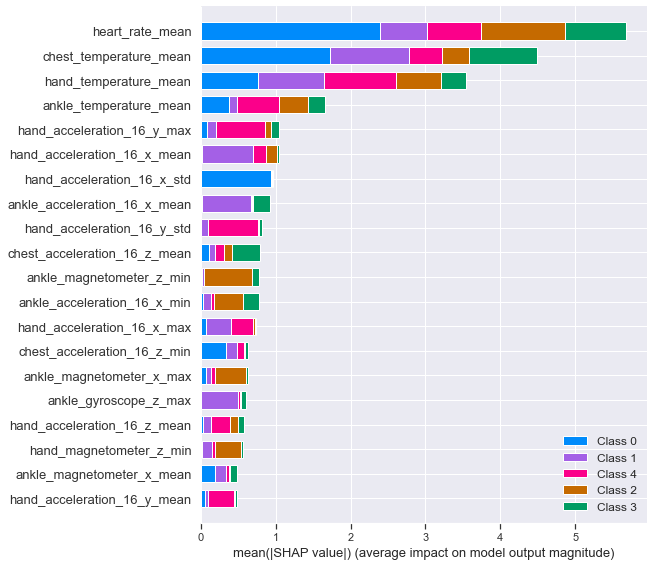

In [120]:
def generate_output_summary_plot (model_object, x_train, sample_size=1e5):
    explainer = shap.TreeExplainer(model_object)
    x_train = x_train[1:sample_size]
    shap_values = explainer.shap_values(x_train)

    print('Generating summary importance plot based on SHAP')
    
    shap.summary_plot(shap_values, x_train,  show=False)

generate_output_summary_plot (xgb, x_val, sample_size=100000)

<a id='the_73'></a> 

### 7.3 Validation

In [123]:
def evaluate(x, y):
    xgbpreds = xgb.predict(x)
    print("Accuracy",accuracy_score(y,xgbpreds))
    print(classification_report(y,xgbpreds))
    return xgbpreds
xgbpreds = evaluate(x_val, y_val)

Accuracy 0.9971116816431322
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       914
           1       1.00      1.00      1.00       369
           2       0.99      1.00      0.99       378
           3       1.00      1.00      1.00       889
           4       1.00      1.00      1.00       566

    accuracy                           1.00      3116
   macro avg       1.00      1.00      1.00      3116
weighted avg       1.00      1.00      1.00      3116



In [124]:
results = pd.DataFrame(y_val).reset_index()
results['y_pred'] = xgbpreds
results[results['activityID_max'] != results['y_pred']][['activityID_max', 'y_pred']]

activityID_max  y_pred
616                0       2
745                2       3
1175               0       2
1313               0       3
1380               0       2
1390               1       0
1553               0       2
2684               4       3
2704               0       3

The results are too good so some invistigation steps

In [125]:
# Check for duplicates between the train and validation datasets
df_copy.duplicated().sum()

0

<a id='the_74'></a> 


### 7.4 Testing

In [126]:
# Try on the testset
evaluate(x_test, y_test)

Accuracy 0.9932432432432432
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1113
           1       0.99      0.99      0.99       476
           2       1.00      0.98      0.99       524
           3       0.99      1.00      0.99      1105
           4       1.00      0.99      1.00       630

    accuracy                           0.99      3848
   macro avg       0.99      0.99      0.99      3848
weighted avg       0.99      0.99      0.99      3848



array([0, 0, 1, ..., 3, 3, 1])

In [127]:
# Try on Subject09 cause the model never seen it's data 

#df_agg_09 = create_agg_data(df_09)
df_test = target(df_agg_09)
df_test = df_test[df_test['activityID_max'] != 'other']
df_test['activityID_max'] = df_test['activityID_max'].astype(int)
vars_to_select = df_test.columns.drop(['subjectID_','activityID_max'])
x_test2 = df_test[vars_to_select]
y_test2 = df_test['activityID_max']
evaluate(x_test, y_test)

Accuracy 0.9932432432432432
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1113
           1       0.99      0.99      0.99       476
           2       1.00      0.98      0.99       524
           3       0.99      1.00      0.99      1105
           4       1.00      0.99      1.00       630

    accuracy                           0.99      3848
   macro avg       0.99      0.99      0.99      3848
weighted avg       0.99      0.99      0.99      3848



array([0, 0, 1, ..., 3, 3, 1])

<a id='the_conclusion'></a> 

## 8 Conclusion

<a id='the_81'></a> 

### 8.1 Technical Improvements

- Since the model is getting extremely good results, the features can be pruned to minimize the computational cost for the prediction and for the aggregation step
- Collecting data from different ages, the model might be having high scores because all the subjects are within the same age range. This means within the same measurements for the same activity and body parts capabilities.
- Simple model based on the first two features used by the tree can also be tried and assessed.
- PCA can be used to reduce the dimensionality and for visualizations, but the model is already accurate and the visualizations we care about are with respect to time which can be covered by 2 axes and adding coloring
- In some cases of classification performing clustering and giving it to the model as an input feature might help the evaluation metric, but in our case, that wasn't necessary.


<a id='the_82'></a> 

### 8.2 Actionable Plan

- For different ages, there are recommended physical activity guidelines including duration and intensity for different ages to achieve optimal health. They can be divided into 5 categories: Sedentary, Light, Moderate, Vigorous, and Very vigorous.
- There is a possibility of building a software solution that accurately distinguishes between the different activities without any need of a large history for the specific customer. 
- Body parts temperatures are correlated which means, we don't need all of these sensors to reach an accurate model.
- The same conclusion for every sensor’s different orientation, we can use one axis and it's a good representation of the remaining two.
